In [68]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [51]:
_docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(_docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [53]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(_docs[ix])

In [54]:
sim_mat = cosine_similarity(val_vecs, _docs)

In [56]:
best = {}
for i, vec in enumerate(tqdm_notebook(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:00<00:00, 34894.06it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


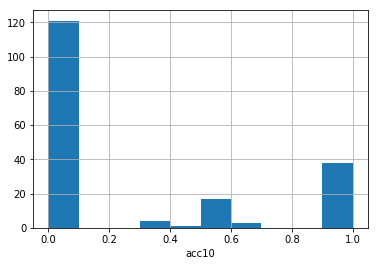

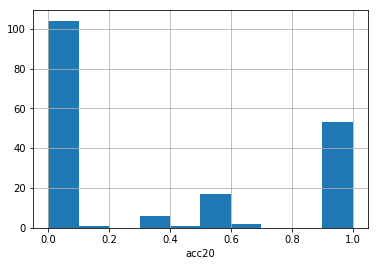

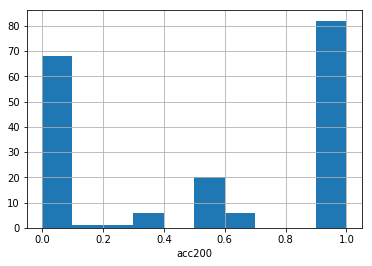

In [58]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)
gc.collect()

100%|██████████| 368458/368458 [00:04<00:00, 87415.00it/s] 


0

In [5]:
embedding_size = 300
batch_size = 64
learning_rate = 0.1
sizes=[300, 200]

In [7]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=False)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-26 12:47:31,888 [MainThread  ] [INFO ]  start training ...
2017-09-26 12:47:34,085 [MainThread  ] [INFO ]  step 0, loss 0.0246231
2017-09-26 12:47:34,108 [MainThread  ] [INFO ]  step 1, loss 0.193446
2017-09-26 12:47:34,211 [MainThread  ] [INFO ]  step 2, loss 0.138571
2017-09-26 12:47:34,223 [MainThread  ] [INFO ]  step 3, loss 0.0880808
2017-09-26 12:47:34,235 [MainThread  ] [INFO ]  step 4, loss 0.108038
2017-09-26 12:47:34,249 [MainThread  ] [INFO ]  step 5, loss 0.0834588
2017-09-26 12:47:34,262 [MainThread  ] [INFO ]  step 6, loss 0.0840769
2017-09-26 12:47:34,275 [MainThread  ] [INFO ]  step 7, loss 0.0736942
2017-09-26 12:47:34,291 [MainThread  ] [INFO ]  step 8, loss 0.0898689
2017-09-26 12:47:34,305 [MainThread  ] [INFO ]  step 9, loss 0.0562397
2017-09-26 12:47:34,318 [MainThread  ] [INFO ]  step 10, loss 0.0427516
2017-09-26 12:47:34,337 [MainThread  ] [INFO ]  step 11, loss 0.0902829
2017-09-26 12:47:34,352 [MainThread  ] [INFO ]  step 12, loss 0.0716068
2017-09-26

2017-09-26 12:47:36,618 [MainThread  ] [INFO ]  step 113, loss 0.0184822
2017-09-26 12:47:36,629 [MainThread  ] [INFO ]  step 114, loss 0.0278372
2017-09-26 12:47:36,644 [MainThread  ] [INFO ]  step 115, loss 0.00628317
2017-09-26 12:47:36,657 [MainThread  ] [INFO ]  step 116, loss 0.0225291
2017-09-26 12:47:36,669 [MainThread  ] [INFO ]  step 117, loss 0.0145395
2017-09-26 12:47:36,681 [MainThread  ] [INFO ]  step 118, loss 0.0307156
2017-09-26 12:47:36,787 [MainThread  ] [INFO ]  step 119, loss 0.0322414
2017-09-26 12:47:36,800 [MainThread  ] [INFO ]  step 120, loss 0.0119007
2017-09-26 12:47:36,813 [MainThread  ] [INFO ]  step 121, loss 0.0134013
2017-09-26 12:47:36,825 [MainThread  ] [INFO ]  step 122, loss 0.0197086
2017-09-26 12:47:36,837 [MainThread  ] [INFO ]  step 123, loss 0.0121345
2017-09-26 12:47:36,851 [MainThread  ] [INFO ]  step 124, loss 0.0123139
2017-09-26 12:47:36,864 [MainThread  ] [INFO ]  step 125, loss 0.0265566
2017-09-26 12:47:36,877 [MainThread  ] [INFO ]  st

2017-09-26 12:47:39,087 [MainThread  ] [INFO ]  step 226, loss 0.0120292
2017-09-26 12:47:39,109 [MainThread  ] [INFO ]  step 227, loss 0.00739951
2017-09-26 12:47:39,124 [MainThread  ] [INFO ]  step 228, loss 0.00624196
2017-09-26 12:47:39,139 [MainThread  ] [INFO ]  step 229, loss 0.0104164
2017-09-26 12:47:39,152 [MainThread  ] [INFO ]  step 230, loss 0.00424813
2017-09-26 12:47:39,169 [MainThread  ] [INFO ]  step 231, loss 0.00422698
2017-09-26 12:47:39,187 [MainThread  ] [INFO ]  step 232, loss 0.0273323
2017-09-26 12:47:39,198 [MainThread  ] [INFO ]  step 233, loss 0.0042448
2017-09-26 12:47:39,211 [MainThread  ] [INFO ]  step 234, loss 0.0154201
2017-09-26 12:47:39,226 [MainThread  ] [INFO ]  step 235, loss 0.00141191
2017-09-26 12:47:39,243 [MainThread  ] [INFO ]  step 236, loss 0.0103044
2017-09-26 12:47:39,257 [MainThread  ] [INFO ]  step 237, loss 0.00887779
2017-09-26 12:47:39,365 [MainThread  ] [INFO ]  step 238, loss 0.00971642
2017-09-26 12:47:39,377 [MainThread  ] [INFO

2017-09-26 12:47:41,359 [MainThread  ] [INFO ]  step 338, loss 0.0148824
2017-09-26 12:47:41,375 [MainThread  ] [INFO ]  step 339, loss 0.0149038
2017-09-26 12:47:41,391 [MainThread  ] [INFO ]  step 340, loss 0.00738497
2017-09-26 12:47:41,406 [MainThread  ] [INFO ]  step 341, loss 0.00463407
2017-09-26 12:47:41,420 [MainThread  ] [INFO ]  step 342, loss 0.0172952
2017-09-26 12:47:41,435 [MainThread  ] [INFO ]  step 343, loss 0.0110016
2017-09-26 12:47:41,450 [MainThread  ] [INFO ]  step 344, loss 0.0212926
2017-09-26 12:47:41,462 [MainThread  ] [INFO ]  step 345, loss 0.0101907
2017-09-26 12:47:41,476 [MainThread  ] [INFO ]  step 346, loss 0.0185387
2017-09-26 12:47:41,489 [MainThread  ] [INFO ]  step 347, loss 0.0187736
2017-09-26 12:47:41,499 [MainThread  ] [INFO ]  step 348, loss 0.0191992
2017-09-26 12:47:41,511 [MainThread  ] [INFO ]  step 349, loss 0.00538225
2017-09-26 12:47:41,523 [MainThread  ] [INFO ]  step 350, loss 0.0317709
2017-09-26 12:47:41,625 [MainThread  ] [INFO ]  

2017-09-26 12:47:43,954 [MainThread  ] [INFO ]  step 450, loss 0.0114766
2017-09-26 12:47:43,968 [MainThread  ] [INFO ]  step 451, loss 0.0111094
2017-09-26 12:47:43,982 [MainThread  ] [INFO ]  step 452, loss 0.0175501
2017-09-26 12:47:43,995 [MainThread  ] [INFO ]  step 453, loss 0.00722296
2017-09-26 12:47:44,008 [MainThread  ] [INFO ]  step 454, loss 0.00577932
2017-09-26 12:47:44,021 [MainThread  ] [INFO ]  step 455, loss 0.0188479
2017-09-26 12:47:44,033 [MainThread  ] [INFO ]  step 456, loss 0.0158129
2017-09-26 12:47:44,051 [MainThread  ] [INFO ]  step 457, loss 0.00126492
2017-09-26 12:47:44,067 [MainThread  ] [INFO ]  step 458, loss 0.0166821
2017-09-26 12:47:44,084 [MainThread  ] [INFO ]  step 459, loss 0.0136298
2017-09-26 12:47:44,196 [MainThread  ] [INFO ]  step 460, loss 0.00855006
2017-09-26 12:47:44,209 [MainThread  ] [INFO ]  step 461, loss 0.0200669
2017-09-26 12:47:44,222 [MainThread  ] [INFO ]  step 462, loss 0.0174302
2017-09-26 12:47:44,235 [MainThread  ] [INFO ] 

2017-09-26 12:47:46,919 [MainThread  ] [INFO ]  step 562, loss 0.0287163
2017-09-26 12:47:46,936 [MainThread  ] [INFO ]  step 563, loss 0.010571
2017-09-26 12:47:46,948 [MainThread  ] [INFO ]  step 564, loss 0.00697089
2017-09-26 12:47:47,058 [MainThread  ] [INFO ]  step 565, loss 0.00103861
2017-09-26 12:47:47,071 [MainThread  ] [INFO ]  step 566, loss 0.0254418
2017-09-26 12:47:47,085 [MainThread  ] [INFO ]  step 567, loss 0.00215087
2017-09-26 12:47:47,096 [MainThread  ] [INFO ]  step 568, loss 0.0100794
2017-09-26 12:47:47,111 [MainThread  ] [INFO ]  step 569, loss 0.00732688
2017-09-26 12:47:47,125 [MainThread  ] [INFO ]  step 570, loss 0.00529218
2017-09-26 12:47:47,142 [MainThread  ] [INFO ]  step 571, loss 0.0253353
2017-09-26 12:47:47,158 [MainThread  ] [INFO ]  step 572, loss 0.00279581
2017-09-26 12:47:47,175 [MainThread  ] [INFO ]  step 573, loss 0.00802369
2017-09-26 12:47:47,189 [MainThread  ] [INFO ]  step 574, loss 0.0200897
2017-09-26 12:47:47,294 [MainThread  ] [INFO 

2017-09-26 12:47:49,789 [MainThread  ] [INFO ]  step 674, loss 0.0102864
2017-09-26 12:47:49,802 [MainThread  ] [INFO ]  step 675, loss 0.00850224
2017-09-26 12:47:49,817 [MainThread  ] [INFO ]  step 676, loss 0.012409
2017-09-26 12:47:49,832 [MainThread  ] [INFO ]  step 677, loss 0.0249962
2017-09-26 12:47:49,863 [MainThread  ] [INFO ]  step 678, loss 0.0148806
2017-09-26 12:47:49,886 [MainThread  ] [INFO ]  step 679, loss 0.0216895
2017-09-26 12:47:49,995 [MainThread  ] [INFO ]  step 680, loss 0.00864941
2017-09-26 12:47:50,009 [MainThread  ] [INFO ]  step 681, loss 0.00878817
2017-09-26 12:47:50,022 [MainThread  ] [INFO ]  step 682, loss 0.0277813
2017-09-26 12:47:50,035 [MainThread  ] [INFO ]  step 683, loss 0.00592658
2017-09-26 12:47:50,047 [MainThread  ] [INFO ]  step 684, loss 0.00504947
2017-09-26 12:47:50,060 [MainThread  ] [INFO ]  step 685, loss 0.00866364
2017-09-26 12:47:50,073 [MainThread  ] [INFO ]  step 686, loss 0.0445322
2017-09-26 12:47:50,085 [MainThread  ] [INFO ]

2017-09-26 12:47:52,287 [MainThread  ] [INFO ]  step 786, loss 0.00400993
2017-09-26 12:47:52,399 [MainThread  ] [INFO ]  step 787, loss 0.0182161
2017-09-26 12:47:52,413 [MainThread  ] [INFO ]  step 788, loss 0.0101079
2017-09-26 12:47:52,432 [MainThread  ] [INFO ]  step 789, loss 0.0108559
2017-09-26 12:47:52,447 [MainThread  ] [INFO ]  step 790, loss 0.0205505
2017-09-26 12:47:52,464 [MainThread  ] [INFO ]  step 791, loss 0.00680516
2017-09-26 12:47:52,483 [MainThread  ] [INFO ]  step 792, loss 0.0126496
2017-09-26 12:47:52,501 [MainThread  ] [INFO ]  step 793, loss 0.0172527
2017-09-26 12:47:52,620 [MainThread  ] [INFO ]  step 794, loss 0.0114561
2017-09-26 12:47:52,636 [MainThread  ] [INFO ]  step 795, loss 0.014636
2017-09-26 12:47:52,651 [MainThread  ] [INFO ]  step 796, loss 0.0070188
2017-09-26 12:47:52,668 [MainThread  ] [INFO ]  step 797, loss 0.00218547
2017-09-26 12:47:52,683 [MainThread  ] [INFO ]  step 798, loss 0.0260312
2017-09-26 12:47:52,790 [MainThread  ] [INFO ]  s

2017-09-26 12:47:55,726 [MainThread  ] [INFO ]  step 898, loss 0.0141522
2017-09-26 12:47:55,742 [MainThread  ] [INFO ]  step 899, loss 0.0254314
2017-09-26 12:47:55,754 [MainThread  ] [INFO ]  step 900, loss 0.0103994
2017-09-26 12:47:55,767 [MainThread  ] [INFO ]  step 901, loss 0.0289371
2017-09-26 12:47:55,779 [MainThread  ] [INFO ]  step 902, loss 0.00939676
2017-09-26 12:47:55,792 [MainThread  ] [INFO ]  step 903, loss 0.0156873
2017-09-26 12:47:55,898 [MainThread  ] [INFO ]  step 904, loss 0.0217989
2017-09-26 12:47:55,910 [MainThread  ] [INFO ]  step 905, loss 0.0107429
2017-09-26 12:47:55,925 [MainThread  ] [INFO ]  step 906, loss 0.00648741
2017-09-26 12:47:55,938 [MainThread  ] [INFO ]  step 907, loss 0.0224375
2017-09-26 12:47:55,953 [MainThread  ] [INFO ]  step 908, loss 0.0214787
2017-09-26 12:47:55,966 [MainThread  ] [INFO ]  step 909, loss 0.0152672
2017-09-26 12:47:55,980 [MainThread  ] [INFO ]  step 910, loss 0.00744386
2017-09-26 12:47:55,993 [MainThread  ] [INFO ]  

2017-09-26 12:47:58,504 [MainThread  ] [INFO ]  step 1010, loss 0.00850375
2017-09-26 12:47:58,520 [MainThread  ] [INFO ]  step 1011, loss 0.0164767
2017-09-26 12:47:58,533 [MainThread  ] [INFO ]  step 1012, loss 0.0110437
2017-09-26 12:47:58,547 [MainThread  ] [INFO ]  step 1013, loss 0.00746186
2017-09-26 12:47:58,560 [MainThread  ] [INFO ]  step 1014, loss 0.0102805
2017-09-26 12:47:58,572 [MainThread  ] [INFO ]  step 1015, loss 0.0142216
2017-09-26 12:47:58,586 [MainThread  ] [INFO ]  step 1016, loss 0.0128761
2017-09-26 12:47:58,599 [MainThread  ] [INFO ]  step 1017, loss 0.0352463
2017-09-26 12:47:58,613 [MainThread  ] [INFO ]  step 1018, loss 0.0417142
2017-09-26 12:47:58,625 [MainThread  ] [INFO ]  step 1019, loss 0.0189507
2017-09-26 12:47:58,638 [MainThread  ] [INFO ]  step 1020, loss 0.0105989
2017-09-26 12:47:58,654 [MainThread  ] [INFO ]  step 1021, loss 0.00936013
2017-09-26 12:47:58,669 [MainThread  ] [INFO ]  step 1022, loss 0.00639342
2017-09-26 12:47:58,695 [MainThrea

2017-09-26 12:48:00,592 [MainThread  ] [INFO ]  step 1121, loss 0.0261647
2017-09-26 12:48:00,609 [MainThread  ] [INFO ]  step 1122, loss 0.0230346
2017-09-26 12:48:00,623 [MainThread  ] [INFO ]  step 1123, loss 0.00202822
2017-09-26 12:48:00,641 [MainThread  ] [INFO ]  step 1124, loss 0.00811098
2017-09-26 12:48:00,659 [MainThread  ] [INFO ]  step 1125, loss 0.0124574
2017-09-26 12:48:00,674 [MainThread  ] [INFO ]  step 1126, loss 0.0341806
2017-09-26 12:48:00,687 [MainThread  ] [INFO ]  step 1127, loss 0.00672009
2017-09-26 12:48:00,704 [MainThread  ] [INFO ]  step 1128, loss 0.000588837
2017-09-26 12:48:00,715 [MainThread  ] [INFO ]  step 1129, loss 0.00542118
2017-09-26 12:48:00,729 [MainThread  ] [INFO ]  step 1130, loss 0.0089914
2017-09-26 12:48:00,746 [MainThread  ] [INFO ]  step 1131, loss 0.0486997
2017-09-26 12:48:00,847 [MainThread  ] [INFO ]  step 1132, loss 0.000500496
2017-09-26 12:48:00,863 [MainThread  ] [INFO ]  step 1133, loss 0.0117296
2017-09-26 12:48:00,881 [MainT

2017-09-26 12:48:03,497 [MainThread  ] [INFO ]  step 1232, loss 0.0179248
2017-09-26 12:48:03,510 [MainThread  ] [INFO ]  step 1233, loss 0.00399898
2017-09-26 12:48:03,616 [MainThread  ] [INFO ]  step 1234, loss 0.0414895
2017-09-26 12:48:03,721 [MainThread  ] [INFO ]  step 1235, loss 0.00497759
2017-09-26 12:48:03,737 [MainThread  ] [INFO ]  step 1236, loss 0.000453376
2017-09-26 12:48:03,754 [MainThread  ] [INFO ]  step 1237, loss 0.0134421
2017-09-26 12:48:03,770 [MainThread  ] [INFO ]  step 1238, loss 0.016691
2017-09-26 12:48:03,788 [MainThread  ] [INFO ]  step 1239, loss 0.0103151
2017-09-26 12:48:03,804 [MainThread  ] [INFO ]  step 1240, loss 0.00402907
2017-09-26 12:48:03,821 [MainThread  ] [INFO ]  step 1241, loss 0.0177949
2017-09-26 12:48:03,838 [MainThread  ] [INFO ]  step 1242, loss 0.00391302
2017-09-26 12:48:03,949 [MainThread  ] [INFO ]  step 1243, loss 0.00636589
2017-09-26 12:48:03,967 [MainThread  ] [INFO ]  step 1244, loss 0.0147899
2017-09-26 12:48:03,986 [MainThr

2017-09-26 12:48:05,811 [MainThread  ] [INFO ]  step 1343, loss 0.0172428
2017-09-26 12:48:05,826 [MainThread  ] [INFO ]  step 1344, loss 0.000794506
2017-09-26 12:48:05,844 [MainThread  ] [INFO ]  step 1345, loss 0.00119218
2017-09-26 12:48:05,857 [MainThread  ] [INFO ]  step 1346, loss 0.0255709
2017-09-26 12:48:05,873 [MainThread  ] [INFO ]  step 1347, loss 0.0189604
2017-09-26 12:48:05,891 [MainThread  ] [INFO ]  step 1348, loss 0.0197286
2017-09-26 12:48:05,904 [MainThread  ] [INFO ]  step 1349, loss 0.0121754
2017-09-26 12:48:06,022 [MainThread  ] [INFO ]  step 1350, loss 0.0201047
2017-09-26 12:48:06,035 [MainThread  ] [INFO ]  step 1351, loss 0.0185273
2017-09-26 12:48:06,050 [MainThread  ] [INFO ]  step 1352, loss 0.00384533
2017-09-26 12:48:06,062 [MainThread  ] [INFO ]  step 1353, loss 0.0072618
2017-09-26 12:48:06,075 [MainThread  ] [INFO ]  step 1354, loss 0.0153268
2017-09-26 12:48:06,086 [MainThread  ] [INFO ]  step 1355, loss 0.0137203
2017-09-26 12:48:06,099 [MainThrea

2017-09-26 12:48:08,797 [MainThread  ] [INFO ]  step 1454, loss 0.0240302
2017-09-26 12:48:08,811 [MainThread  ] [INFO ]  step 1455, loss 0.0128792
2017-09-26 12:48:08,826 [MainThread  ] [INFO ]  step 1456, loss 0.0068162
2017-09-26 12:48:08,839 [MainThread  ] [INFO ]  step 1457, loss 0.0044708
2017-09-26 12:48:08,851 [MainThread  ] [INFO ]  step 1458, loss 0.0229751
2017-09-26 12:48:08,873 [MainThread  ] [INFO ]  step 1459, loss 0.00546273
2017-09-26 12:48:08,887 [MainThread  ] [INFO ]  step 1460, loss 0.0135526
2017-09-26 12:48:08,899 [MainThread  ] [INFO ]  step 1461, loss 0.0194444
2017-09-26 12:48:08,913 [MainThread  ] [INFO ]  step 1462, loss 0.015741
2017-09-26 12:48:08,926 [MainThread  ] [INFO ]  step 1463, loss 0.00799726
2017-09-26 12:48:09,036 [MainThread  ] [INFO ]  step 1464, loss 0.0126439
2017-09-26 12:48:09,048 [MainThread  ] [INFO ]  step 1465, loss 0.00776086
2017-09-26 12:48:09,154 [MainThread  ] [INFO ]  step 1466, loss 0.0158707
2017-09-26 12:48:09,176 [MainThread 

2017-09-26 12:48:11,598 [MainThread  ] [INFO ]  step 1565, loss 0.0111739
2017-09-26 12:48:11,612 [MainThread  ] [INFO ]  step 1566, loss 0.0252949
2017-09-26 12:48:11,633 [MainThread  ] [INFO ]  step 1567, loss 0.00251206
2017-09-26 12:48:11,646 [MainThread  ] [INFO ]  step 1568, loss 0.0156491
2017-09-26 12:48:11,660 [MainThread  ] [INFO ]  step 1569, loss 0.0104419
2017-09-26 12:48:11,674 [MainThread  ] [INFO ]  step 1570, loss 0.0142044
2017-09-26 12:48:11,686 [MainThread  ] [INFO ]  step 1571, loss 0.0121033
2017-09-26 12:48:11,700 [MainThread  ] [INFO ]  step 1572, loss 0.00868887
2017-09-26 12:48:11,715 [MainThread  ] [INFO ]  step 1573, loss 0.00605343
2017-09-26 12:48:11,828 [MainThread  ] [INFO ]  step 1574, loss 0.0139068
2017-09-26 12:48:11,842 [MainThread  ] [INFO ]  step 1575, loss 0.00783923
2017-09-26 12:48:11,856 [MainThread  ] [INFO ]  step 1576, loss 0.0169987
2017-09-26 12:48:11,975 [MainThread  ] [INFO ]  step 1577, loss 0.00303023
2017-09-26 12:48:12,089 [MainThre

2017-09-26 12:48:14,410 [MainThread  ] [INFO ]  step 1676, loss 0.00464832
2017-09-26 12:48:14,426 [MainThread  ] [INFO ]  step 1677, loss 0.0138964
2017-09-26 12:48:14,441 [MainThread  ] [INFO ]  step 1678, loss 0.0154131
2017-09-26 12:48:14,459 [MainThread  ] [INFO ]  step 1679, loss 0.00372375
2017-09-26 12:48:14,564 [MainThread  ] [INFO ]  step 1680, loss 0.00526717
2017-09-26 12:48:14,582 [MainThread  ] [INFO ]  step 1681, loss 0.0155293
2017-09-26 12:48:14,598 [MainThread  ] [INFO ]  step 1682, loss 0.00476889
2017-09-26 12:48:14,614 [MainThread  ] [INFO ]  step 1683, loss 0.00933077
2017-09-26 12:48:14,630 [MainThread  ] [INFO ]  step 1684, loss 0.0139114
2017-09-26 12:48:14,648 [MainThread  ] [INFO ]  step 1685, loss 0.00164778
2017-09-26 12:48:14,663 [MainThread  ] [INFO ]  step 1686, loss 0.0035956
2017-09-26 12:48:14,682 [MainThread  ] [INFO ]  step 1687, loss 0.00985829
2017-09-26 12:48:14,698 [MainThread  ] [INFO ]  step 1688, loss 0.00176614
2017-09-26 12:48:14,711 [MainT

2017-09-26 12:48:16,557 [MainThread  ] [INFO ]  step 1786, loss 0.0283925
2017-09-26 12:48:16,574 [MainThread  ] [INFO ]  step 1787, loss 0.00079976
2017-09-26 12:48:16,590 [MainThread  ] [INFO ]  step 1788, loss 0.0134975
2017-09-26 12:48:16,602 [MainThread  ] [INFO ]  step 1789, loss 0.00192086
2017-09-26 12:48:16,614 [MainThread  ] [INFO ]  step 1790, loss 0.00273365
2017-09-26 12:48:16,629 [MainThread  ] [INFO ]  step 1791, loss 0.00196204
2017-09-26 12:48:16,646 [MainThread  ] [INFO ]  step 1792, loss 0.000956218
2017-09-26 12:48:16,662 [MainThread  ] [INFO ]  step 1793, loss 0.0112875
2017-09-26 12:48:16,675 [MainThread  ] [INFO ]  step 1794, loss 0.00485156
2017-09-26 12:48:16,690 [MainThread  ] [INFO ]  step 1795, loss 0.016931
2017-09-26 12:48:16,705 [MainThread  ] [INFO ]  step 1796, loss 0.0144424
2017-09-26 12:48:16,723 [MainThread  ] [INFO ]  step 1797, loss 0.00920062
2017-09-26 12:48:16,737 [MainThread  ] [INFO ]  step 1798, loss 0.00718364
2017-09-26 12:48:16,751 [MainT

2017-09-26 12:48:18,976 [MainThread  ] [INFO ]  step 1897, loss 0.010189
2017-09-26 12:48:19,076 [MainThread  ] [INFO ]  step 1898, loss 0.0137164
2017-09-26 12:48:19,088 [MainThread  ] [INFO ]  step 1899, loss 0.0177503
2017-09-26 12:48:19,101 [MainThread  ] [INFO ]  step 1900, loss 0.00800893
2017-09-26 12:48:19,113 [MainThread  ] [INFO ]  step 1901, loss 0.00484952
2017-09-26 12:48:19,123 [MainThread  ] [INFO ]  step 1902, loss 0.012319
2017-09-26 12:48:19,134 [MainThread  ] [INFO ]  step 1903, loss 0.00684741
2017-09-26 12:48:19,144 [MainThread  ] [INFO ]  step 1904, loss 0.0162715
2017-09-26 12:48:19,243 [MainThread  ] [INFO ]  step 1905, loss 0.00344324
2017-09-26 12:48:19,257 [MainThread  ] [INFO ]  step 1906, loss 0.0154149
2017-09-26 12:48:19,269 [MainThread  ] [INFO ]  step 1907, loss 0.0265096
2017-09-26 12:48:19,281 [MainThread  ] [INFO ]  step 1908, loss 0.00534564
2017-09-26 12:48:19,294 [MainThread  ] [INFO ]  step 1909, loss 0.00582156
2017-09-26 12:48:19,307 [MainThrea

2017-09-26 12:48:21,798 [MainThread  ] [INFO ]  step 2008, loss 0.00550797
2017-09-26 12:48:21,811 [MainThread  ] [INFO ]  step 2009, loss 0.0136779
2017-09-26 12:48:21,825 [MainThread  ] [INFO ]  step 2010, loss 0.0267093
2017-09-26 12:48:21,843 [MainThread  ] [INFO ]  step 2011, loss 0.0212879
2017-09-26 12:48:21,858 [MainThread  ] [INFO ]  step 2012, loss 0.0130971
2017-09-26 12:48:21,873 [MainThread  ] [INFO ]  step 2013, loss 0.00108714
2017-09-26 12:48:21,982 [MainThread  ] [INFO ]  step 2014, loss 0.0031593
2017-09-26 12:48:21,999 [MainThread  ] [INFO ]  step 2015, loss 0.00361162
2017-09-26 12:48:22,011 [MainThread  ] [INFO ]  step 2016, loss 0.0103034
2017-09-26 12:48:22,022 [MainThread  ] [INFO ]  step 2017, loss 0.00854262
2017-09-26 12:48:22,033 [MainThread  ] [INFO ]  step 2018, loss 0.00817165
2017-09-26 12:48:22,044 [MainThread  ] [INFO ]  step 2019, loss 0.00261657
2017-09-26 12:48:22,054 [MainThread  ] [INFO ]  step 2020, loss 0.0171181
2017-09-26 12:48:22,064 [MainThr

2017-09-26 12:48:24,224 [MainThread  ] [INFO ]  step 2119, loss 0.0135035
2017-09-26 12:48:24,237 [MainThread  ] [INFO ]  step 2120, loss 0.00669609
2017-09-26 12:48:24,251 [MainThread  ] [INFO ]  step 2121, loss 0.00451618
2017-09-26 12:48:24,263 [MainThread  ] [INFO ]  step 2122, loss 0.0
2017-09-26 12:48:24,275 [MainThread  ] [INFO ]  step 2123, loss 0.0120885
2017-09-26 12:48:24,389 [MainThread  ] [INFO ]  step 2124, loss 0.00488361
2017-09-26 12:48:24,405 [MainThread  ] [INFO ]  step 2125, loss 0.0170493
2017-09-26 12:48:24,420 [MainThread  ] [INFO ]  step 2126, loss 0.00640244
2017-09-26 12:48:24,434 [MainThread  ] [INFO ]  step 2127, loss 0.0148436
2017-09-26 12:48:24,538 [MainThread  ] [INFO ]  step 2128, loss 0.00133813
2017-09-26 12:48:24,550 [MainThread  ] [INFO ]  step 2129, loss 0.00916946
2017-09-26 12:48:24,562 [MainThread  ] [INFO ]  step 2130, loss 0.0117077
2017-09-26 12:48:24,575 [MainThread  ] [INFO ]  step 2131, loss 0.000915641
2017-09-26 12:48:24,588 [MainThread 

2017-09-26 12:48:26,106 [MainThread  ] [INFO ]  step 2230, loss 0.013128
2017-09-26 12:48:26,118 [MainThread  ] [INFO ]  step 2231, loss 0.0063963
2017-09-26 12:48:26,227 [MainThread  ] [INFO ]  step 2232, loss 0.00587105
2017-09-26 12:48:26,240 [MainThread  ] [INFO ]  step 2233, loss 0.00228179
2017-09-26 12:48:26,253 [MainThread  ] [INFO ]  step 2234, loss 0.0192392
2017-09-26 12:48:26,266 [MainThread  ] [INFO ]  step 2235, loss 0.0177856
2017-09-26 12:48:26,279 [MainThread  ] [INFO ]  step 2236, loss 0.0109077
2017-09-26 12:48:26,291 [MainThread  ] [INFO ]  step 2237, loss 0.00474496
2017-09-26 12:48:26,407 [MainThread  ] [INFO ]  step 2238, loss 0.00422189
2017-09-26 12:48:26,420 [MainThread  ] [INFO ]  step 2239, loss 0.00818409
2017-09-26 12:48:26,433 [MainThread  ] [INFO ]  step 2240, loss 0.0267667
2017-09-26 12:48:26,445 [MainThread  ] [INFO ]  step 2241, loss 0.0104002
2017-09-26 12:48:26,460 [MainThread  ] [INFO ]  step 2242, loss 0.0133726
2017-09-26 12:48:26,473 [MainThrea

2017-09-26 12:48:28,571 [MainThread  ] [INFO ]  step 2340, loss 0.0163291
2017-09-26 12:48:28,592 [MainThread  ] [INFO ]  step 2341, loss 0.000242593
2017-09-26 12:48:28,608 [MainThread  ] [INFO ]  step 2342, loss 0.00756632
2017-09-26 12:48:28,627 [MainThread  ] [INFO ]  step 2343, loss 0.00234829
2017-09-26 12:48:28,645 [MainThread  ] [INFO ]  step 2344, loss 0.00298203
2017-09-26 12:48:28,758 [MainThread  ] [INFO ]  step 2345, loss 0.0096692
2017-09-26 12:48:28,775 [MainThread  ] [INFO ]  step 2346, loss 0.0112915
2017-09-26 12:48:28,789 [MainThread  ] [INFO ]  step 2347, loss 0.01276
2017-09-26 12:48:28,803 [MainThread  ] [INFO ]  step 2348, loss 0.00548892
2017-09-26 12:48:28,816 [MainThread  ] [INFO ]  step 2349, loss 0.0145165
2017-09-26 12:48:28,830 [MainThread  ] [INFO ]  step 2350, loss 0.0117736
2017-09-26 12:48:28,844 [MainThread  ] [INFO ]  step 2351, loss 0.00507794
2017-09-26 12:48:28,859 [MainThread  ] [INFO ]  step 2352, loss 0.0159187
2017-09-26 12:48:28,967 [MainThre

2017-09-26 12:48:31,560 [MainThread  ] [INFO ]  step 2450, loss 0.0165279
2017-09-26 12:48:31,572 [MainThread  ] [INFO ]  step 2451, loss 0.0151683
2017-09-26 12:48:31,584 [MainThread  ] [INFO ]  step 2452, loss 0.0209175
2017-09-26 12:48:31,595 [MainThread  ] [INFO ]  step 2453, loss 0.0111264
2017-09-26 12:48:31,606 [MainThread  ] [INFO ]  step 2454, loss 0.00688281
2017-09-26 12:48:31,618 [MainThread  ] [INFO ]  step 2455, loss 0.0141681
2017-09-26 12:48:31,629 [MainThread  ] [INFO ]  step 2456, loss 0.00216008
2017-09-26 12:48:31,734 [MainThread  ] [INFO ]  step 2457, loss 0.00804497
2017-09-26 12:48:31,749 [MainThread  ] [INFO ]  step 2458, loss 0.00273091
2017-09-26 12:48:31,764 [MainThread  ] [INFO ]  step 2459, loss 0.00522598
2017-09-26 12:48:31,776 [MainThread  ] [INFO ]  step 2460, loss 0.0164691
2017-09-26 12:48:31,788 [MainThread  ] [INFO ]  step 2461, loss 0.00580141
2017-09-26 12:48:31,799 [MainThread  ] [INFO ]  step 2462, loss 0.0160564
2017-09-26 12:48:31,810 [MainThr

2017-09-26 12:48:34,330 [MainThread  ] [INFO ]  step 2561, loss 0.0
2017-09-26 12:48:34,340 [MainThread  ] [INFO ]  step 2562, loss 0.00824277
2017-09-26 12:48:34,353 [MainThread  ] [INFO ]  step 2563, loss 0.0139788
2017-09-26 12:48:34,362 [MainThread  ] [INFO ]  step 2564, loss 0.00775299
2017-09-26 12:48:34,373 [MainThread  ] [INFO ]  step 2565, loss 0.00870594
2017-09-26 12:48:34,386 [MainThread  ] [INFO ]  step 2566, loss 0.0104469
2017-09-26 12:48:34,397 [MainThread  ] [INFO ]  step 2567, loss 0.00680817
2017-09-26 12:48:34,409 [MainThread  ] [INFO ]  step 2568, loss 0.00193207
2017-09-26 12:48:34,420 [MainThread  ] [INFO ]  step 2569, loss 0.00897151
2017-09-26 12:48:34,430 [MainThread  ] [INFO ]  step 2570, loss 0.00621919
2017-09-26 12:48:34,441 [MainThread  ] [INFO ]  step 2571, loss 0.00260458
2017-09-26 12:48:34,452 [MainThread  ] [INFO ]  step 2572, loss 0.00456553
2017-09-26 12:48:34,463 [MainThread  ] [INFO ]  step 2573, loss 0.0066507
2017-09-26 12:48:34,474 [MainThread

2017-09-26 12:48:37,103 [MainThread  ] [INFO ]  step 2672, loss 0.0129149
2017-09-26 12:48:37,115 [MainThread  ] [INFO ]  step 2673, loss 0.0113954
2017-09-26 12:48:37,127 [MainThread  ] [INFO ]  step 2674, loss 0.00568172
2017-09-26 12:48:37,142 [MainThread  ] [INFO ]  step 2675, loss 0.0119259
2017-09-26 12:48:37,164 [MainThread  ] [INFO ]  step 2676, loss 0.0076869
2017-09-26 12:48:37,178 [MainThread  ] [INFO ]  step 2677, loss 0.0116087
2017-09-26 12:48:37,193 [MainThread  ] [INFO ]  step 2678, loss 0.00683525
2017-09-26 12:48:37,205 [MainThread  ] [INFO ]  step 2679, loss 0.00415104
2017-09-26 12:48:37,218 [MainThread  ] [INFO ]  step 2680, loss 0.00441717
2017-09-26 12:48:37,230 [MainThread  ] [INFO ]  step 2681, loss 0.0
2017-09-26 12:48:37,244 [MainThread  ] [INFO ]  step 2682, loss 0.00327673
2017-09-26 12:48:37,360 [MainThread  ] [INFO ]  step 2683, loss 0.0039999
2017-09-26 12:48:37,375 [MainThread  ] [INFO ]  step 2684, loss 0.015735
2017-09-26 12:48:37,390 [MainThread  ] [

2017-09-26 12:48:39,135 [MainThread  ] [INFO ]  step 2783, loss 0.00298809
2017-09-26 12:48:39,147 [MainThread  ] [INFO ]  step 2784, loss 0.00821058
2017-09-26 12:48:39,293 [MainThread  ] [INFO ]  step 2785, loss 0.0124609
2017-09-26 12:48:39,309 [MainThread  ] [INFO ]  step 2786, loss 0.00523859
2017-09-26 12:48:39,326 [MainThread  ] [INFO ]  step 2787, loss 0.00515319
2017-09-26 12:48:39,344 [MainThread  ] [INFO ]  step 2788, loss 0.0269427
2017-09-26 12:48:39,359 [MainThread  ] [INFO ]  step 2789, loss 0.00512656
2017-09-26 12:48:39,374 [MainThread  ] [INFO ]  step 2790, loss 0.0120974
2017-09-26 12:48:39,391 [MainThread  ] [INFO ]  step 2791, loss 0.00921556
2017-09-26 12:48:39,406 [MainThread  ] [INFO ]  step 2792, loss 0.00810923
2017-09-26 12:48:39,423 [MainThread  ] [INFO ]  step 2793, loss 0.00576153
2017-09-26 12:48:39,446 [MainThread  ] [INFO ]  step 2794, loss 0.00175647
2017-09-26 12:48:39,461 [MainThread  ] [INFO ]  step 2795, loss 0.011975
2017-09-26 12:48:39,479 [MainT

2017-09-26 12:48:41,981 [MainThread  ] [INFO ]  step 2893, loss 0.0187782
2017-09-26 12:48:41,996 [MainThread  ] [INFO ]  step 2894, loss 0.00575452
2017-09-26 12:48:42,011 [MainThread  ] [INFO ]  step 2895, loss 0.00466817
2017-09-26 12:48:42,027 [MainThread  ] [INFO ]  step 2896, loss 0.00182026
2017-09-26 12:48:42,041 [MainThread  ] [INFO ]  step 2897, loss 0.0163331
2017-09-26 12:48:42,058 [MainThread  ] [INFO ]  step 2898, loss 0.00172552
2017-09-26 12:48:42,171 [MainThread  ] [INFO ]  step 2899, loss 0.00160589
2017-09-26 12:48:42,189 [MainThread  ] [INFO ]  step 2900, loss 0.00784838
2017-09-26 12:48:42,207 [MainThread  ] [INFO ]  step 2901, loss 0.00928082
2017-09-26 12:48:42,225 [MainThread  ] [INFO ]  step 2902, loss 0.00752488
2017-09-26 12:48:42,247 [MainThread  ] [INFO ]  step 2903, loss 0.00372251
2017-09-26 12:48:42,265 [MainThread  ] [INFO ]  step 2904, loss 0.00912356
2017-09-26 12:48:42,282 [MainThread  ] [INFO ]  step 2905, loss 0.0007731
2017-09-26 12:48:42,304 [Mai

2017-09-26 12:48:44,939 [MainThread  ] [INFO ]  step 3004, loss 0.0
2017-09-26 12:48:44,954 [MainThread  ] [INFO ]  step 3005, loss 0.0191323
2017-09-26 12:48:45,080 [MainThread  ] [INFO ]  step 3006, loss 0.0
2017-09-26 12:48:45,093 [MainThread  ] [INFO ]  step 3007, loss 0.00877949
2017-09-26 12:48:45,106 [MainThread  ] [INFO ]  step 3008, loss 0.0142948
2017-09-26 12:48:45,221 [MainThread  ] [INFO ]  step 3009, loss 0.00488203
2017-09-26 12:48:45,235 [MainThread  ] [INFO ]  step 3010, loss 0.00565638
2017-09-26 12:48:45,248 [MainThread  ] [INFO ]  step 3011, loss 0.00323273
2017-09-26 12:48:45,260 [MainThread  ] [INFO ]  step 3012, loss 0.000440241
2017-09-26 12:48:45,274 [MainThread  ] [INFO ]  step 3013, loss 0.0104707
2017-09-26 12:48:45,289 [MainThread  ] [INFO ]  step 3014, loss 0.00486311
2017-09-26 12:48:45,306 [MainThread  ] [INFO ]  step 3015, loss 0.011419
2017-09-26 12:48:45,321 [MainThread  ] [INFO ]  step 3016, loss 0.0194388
2017-09-26 12:48:45,430 [MainThread  ] [INFO

2017-09-26 12:48:48,161 [MainThread  ] [INFO ]  step 3115, loss 0.00741843
2017-09-26 12:48:48,176 [MainThread  ] [INFO ]  step 3116, loss 0.0084995
2017-09-26 12:48:48,188 [MainThread  ] [INFO ]  step 3117, loss 0.00560603
2017-09-26 12:48:48,200 [MainThread  ] [INFO ]  step 3118, loss 0.00358377
2017-09-26 12:48:48,216 [MainThread  ] [INFO ]  step 3119, loss 0.0
2017-09-26 12:48:48,230 [MainThread  ] [INFO ]  step 3120, loss 0.006128
2017-09-26 12:48:48,242 [MainThread  ] [INFO ]  step 3121, loss 0.0
2017-09-26 12:48:48,258 [MainThread  ] [INFO ]  step 3122, loss 0.00586022
2017-09-26 12:48:48,272 [MainThread  ] [INFO ]  step 3123, loss 0.00762028
2017-09-26 12:48:48,290 [MainThread  ] [INFO ]  step 3124, loss 0.0204234
2017-09-26 12:48:48,306 [MainThread  ] [INFO ]  step 3125, loss 0.0133238
2017-09-26 12:48:48,319 [MainThread  ] [INFO ]  step 3126, loss 0.00792511
2017-09-26 12:48:48,338 [MainThread  ] [INFO ]  step 3127, loss 0.00764437
2017-09-26 12:48:48,354 [MainThread  ] [INFO

2017-09-26 12:48:50,421 [MainThread  ] [INFO ]  step 3226, loss 0.0
2017-09-26 12:48:50,436 [MainThread  ] [INFO ]  step 3227, loss 0.0143829
2017-09-26 12:48:50,449 [MainThread  ] [INFO ]  step 3228, loss 0.0164613
2017-09-26 12:48:50,561 [MainThread  ] [INFO ]  step 3229, loss 0.00752159
2017-09-26 12:48:50,578 [MainThread  ] [INFO ]  step 3230, loss 0.00329952
2017-09-26 12:48:50,592 [MainThread  ] [INFO ]  step 3231, loss 0.0021099
2017-09-26 12:48:50,606 [MainThread  ] [INFO ]  step 3232, loss 0.00579088
2017-09-26 12:48:50,619 [MainThread  ] [INFO ]  step 3233, loss 0.00547328
2017-09-26 12:48:50,634 [MainThread  ] [INFO ]  step 3234, loss 0.00969796
2017-09-26 12:48:50,648 [MainThread  ] [INFO ]  step 3235, loss 0.000966257
2017-09-26 12:48:50,662 [MainThread  ] [INFO ]  step 3236, loss 0.00245691
2017-09-26 12:48:50,675 [MainThread  ] [INFO ]  step 3237, loss 0.00262478
2017-09-26 12:48:50,687 [MainThread  ] [INFO ]  step 3238, loss 0.00369975
2017-09-26 12:48:50,699 [MainThrea

2017-09-26 12:48:53,184 [MainThread  ] [INFO ]  step 3337, loss 0.0169367
2017-09-26 12:48:53,204 [MainThread  ] [INFO ]  step 3338, loss 0.00521493
2017-09-26 12:48:53,222 [MainThread  ] [INFO ]  step 3339, loss 0.0053524
2017-09-26 12:48:53,235 [MainThread  ] [INFO ]  step 3340, loss 0.0193136
2017-09-26 12:48:53,251 [MainThread  ] [INFO ]  step 3341, loss 0.0101329
2017-09-26 12:48:53,266 [MainThread  ] [INFO ]  step 3342, loss 0.0
2017-09-26 12:48:53,287 [MainThread  ] [INFO ]  step 3343, loss 0.00234085
2017-09-26 12:48:53,303 [MainThread  ] [INFO ]  step 3344, loss 0.000709889
2017-09-26 12:48:53,319 [MainThread  ] [INFO ]  step 3345, loss 0.0
2017-09-26 12:48:53,333 [MainThread  ] [INFO ]  step 3346, loss 0.00259505
2017-09-26 12:48:53,452 [MainThread  ] [INFO ]  step 3347, loss 0.0168123
2017-09-26 12:48:53,472 [MainThread  ] [INFO ]  step 3348, loss 0.0236313
2017-09-26 12:48:53,589 [MainThread  ] [INFO ]  step 3349, loss 0.00878754
2017-09-26 12:48:53,601 [MainThread  ] [INFO

2017-09-26 12:48:56,193 [MainThread  ] [INFO ]  step 3448, loss 0.0157691
2017-09-26 12:48:56,215 [MainThread  ] [INFO ]  step 3449, loss 0.00402159
2017-09-26 12:48:56,228 [MainThread  ] [INFO ]  step 3450, loss 0.00260571
2017-09-26 12:48:56,240 [MainThread  ] [INFO ]  step 3451, loss 0.00670888
2017-09-26 12:48:56,344 [MainThread  ] [INFO ]  step 3452, loss 0.00823705
2017-09-26 12:48:56,362 [MainThread  ] [INFO ]  step 3453, loss 0.0116756
2017-09-26 12:48:56,378 [MainThread  ] [INFO ]  step 3454, loss 0.0212224
2017-09-26 12:48:56,392 [MainThread  ] [INFO ]  step 3455, loss 0.00481217
2017-09-26 12:48:56,405 [MainThread  ] [INFO ]  step 3456, loss 0.00744006
2017-09-26 12:48:56,418 [MainThread  ] [INFO ]  step 3457, loss 0.00535252
2017-09-26 12:48:56,432 [MainThread  ] [INFO ]  step 3458, loss 0.00549396
2017-09-26 12:48:56,445 [MainThread  ] [INFO ]  step 3459, loss 0.0
2017-09-26 12:48:56,458 [MainThread  ] [INFO ]  step 3460, loss 0.00823729
2017-09-26 12:48:56,565 [MainThread

2017-09-26 12:48:59,823 [MainThread  ] [INFO ]  step 3559, loss 0.0119897
2017-09-26 12:48:59,943 [MainThread  ] [INFO ]  step 3560, loss 0.00533792
2017-09-26 12:48:59,959 [MainThread  ] [INFO ]  step 3561, loss 0.0116321
2017-09-26 12:48:59,973 [MainThread  ] [INFO ]  step 3562, loss 0.0117334
2017-09-26 12:48:59,987 [MainThread  ] [INFO ]  step 3563, loss 0.00734577
2017-09-26 12:49:00,110 [MainThread  ] [INFO ]  step 3564, loss 0.0118295
2017-09-26 12:49:00,123 [MainThread  ] [INFO ]  step 3565, loss 0.0145583
2017-09-26 12:49:00,137 [MainThread  ] [INFO ]  step 3566, loss 0.0051488
2017-09-26 12:49:00,153 [MainThread  ] [INFO ]  step 3567, loss 0.022909
2017-09-26 12:49:00,167 [MainThread  ] [INFO ]  step 3568, loss 0.0172733
2017-09-26 12:49:00,183 [MainThread  ] [INFO ]  step 3569, loss 0.00443098
2017-09-26 12:49:00,198 [MainThread  ] [INFO ]  step 3570, loss 0.0190345
2017-09-26 12:49:00,212 [MainThread  ] [INFO ]  step 3571, loss 0.00120773
2017-09-26 12:49:00,227 [MainThread

2017-09-26 12:49:02,750 [MainThread  ] [INFO ]  step 3670, loss 0.00416539
2017-09-26 12:49:02,762 [MainThread  ] [INFO ]  step 3671, loss 0.011048
2017-09-26 12:49:02,775 [MainThread  ] [INFO ]  step 3672, loss 0.00362395
2017-09-26 12:49:02,793 [MainThread  ] [INFO ]  step 3673, loss 0.00884931
2017-09-26 12:49:02,805 [MainThread  ] [INFO ]  step 3674, loss 0.0212074
2017-09-26 12:49:02,819 [MainThread  ] [INFO ]  step 3675, loss 0.000881255
2017-09-26 12:49:02,835 [MainThread  ] [INFO ]  step 3676, loss 0.0
2017-09-26 12:49:02,848 [MainThread  ] [INFO ]  step 3677, loss 0.000581841
2017-09-26 12:49:02,861 [MainThread  ] [INFO ]  step 3678, loss 0.00744427
2017-09-26 12:49:02,874 [MainThread  ] [INFO ]  step 3679, loss 0.00128834
2017-09-26 12:49:02,891 [MainThread  ] [INFO ]  step 3680, loss 0.00714706
2017-09-26 12:49:02,909 [MainThread  ] [INFO ]  step 3681, loss 0.0241593
2017-09-26 12:49:02,925 [MainThread  ] [INFO ]  step 3682, loss 0.0137869
2017-09-26 12:49:03,036 [MainThread

2017-09-26 12:49:05,129 [MainThread  ] [INFO ]  step 3781, loss 0.00597108
2017-09-26 12:49:05,142 [MainThread  ] [INFO ]  step 3782, loss 0.00338843
2017-09-26 12:49:05,154 [MainThread  ] [INFO ]  step 3783, loss 0.00598907
2017-09-26 12:49:05,165 [MainThread  ] [INFO ]  step 3784, loss 0.00368206
2017-09-26 12:49:05,177 [MainThread  ] [INFO ]  step 3785, loss 0.00580957
2017-09-26 12:49:05,193 [MainThread  ] [INFO ]  step 3786, loss 0.00242465
2017-09-26 12:49:05,310 [MainThread  ] [INFO ]  step 3787, loss 0.00480052
2017-09-26 12:49:05,327 [MainThread  ] [INFO ]  step 3788, loss 0.0082295
2017-09-26 12:49:05,343 [MainThread  ] [INFO ]  step 3789, loss 0.00322169
2017-09-26 12:49:05,358 [MainThread  ] [INFO ]  step 3790, loss 0.020103
2017-09-26 12:49:05,468 [MainThread  ] [INFO ]  step 3791, loss 0.0156404
2017-09-26 12:49:05,585 [MainThread  ] [INFO ]  step 3792, loss 0.0032236
2017-09-26 12:49:05,606 [MainThread  ] [INFO ]  step 3793, loss 0.0111618
2017-09-26 12:49:05,628 [MainTh

2017-09-26 12:49:07,376 [MainThread  ] [INFO ]  step 3892, loss 0.000213165
2017-09-26 12:49:07,393 [MainThread  ] [INFO ]  step 3893, loss 0.0199057
2017-09-26 12:49:07,409 [MainThread  ] [INFO ]  step 3894, loss 0.0222199
2017-09-26 12:49:07,424 [MainThread  ] [INFO ]  step 3895, loss 0.00403947
2017-09-26 12:49:07,439 [MainThread  ] [INFO ]  step 3896, loss 0.00571427
2017-09-26 12:49:07,453 [MainThread  ] [INFO ]  step 3897, loss 0.0122017
2017-09-26 12:49:07,467 [MainThread  ] [INFO ]  step 3898, loss 0.0053393
2017-09-26 12:49:07,482 [MainThread  ] [INFO ]  step 3899, loss 0.00515271
2017-09-26 12:49:07,590 [MainThread  ] [INFO ]  step 3900, loss 0.0125884
2017-09-26 12:49:07,603 [MainThread  ] [INFO ]  step 3901, loss 0.00693406
2017-09-26 12:49:07,618 [MainThread  ] [INFO ]  step 3902, loss 0.00175911
2017-09-26 12:49:07,630 [MainThread  ] [INFO ]  step 3903, loss 0.00487708
2017-09-26 12:49:07,733 [MainThread  ] [INFO ]  step 3904, loss 0.004444
2017-09-26 12:49:07,746 [MainTh

2017-09-26 12:49:09,613 [MainThread  ] [INFO ]  step 4003, loss 0.00630082
2017-09-26 12:49:09,719 [MainThread  ] [INFO ]  step 4004, loss 0.0154676
2017-09-26 12:49:09,733 [MainThread  ] [INFO ]  step 4005, loss 0.00682671
2017-09-26 12:49:09,747 [MainThread  ] [INFO ]  step 4006, loss 0.00184359
2017-09-26 12:49:09,761 [MainThread  ] [INFO ]  step 4007, loss 0.0185301
2017-09-26 12:49:09,774 [MainThread  ] [INFO ]  step 4008, loss 0.00764892
2017-09-26 12:49:09,787 [MainThread  ] [INFO ]  step 4009, loss 0.00252877
2017-09-26 12:49:09,800 [MainThread  ] [INFO ]  step 4010, loss 0.00277342
2017-09-26 12:49:09,815 [MainThread  ] [INFO ]  step 4011, loss 0.0137489
2017-09-26 12:49:09,827 [MainThread  ] [INFO ]  step 4012, loss 0.00957953
2017-09-26 12:49:09,842 [MainThread  ] [INFO ]  step 4013, loss 0.00335311
2017-09-26 12:49:09,856 [MainThread  ] [INFO ]  step 4014, loss 0.00950457
2017-09-26 12:49:09,870 [MainThread  ] [INFO ]  step 4015, loss 0.0103861
2017-09-26 12:49:09,978 [Main

2017-09-26 12:49:12,228 [MainThread  ] [INFO ]  step 4114, loss 0.00721457
2017-09-26 12:49:12,336 [MainThread  ] [INFO ]  step 4115, loss 0.00193182
2017-09-26 12:49:12,441 [MainThread  ] [INFO ]  step 4116, loss 0.0100061
2017-09-26 12:49:12,454 [MainThread  ] [INFO ]  step 4117, loss 0.0134025
2017-09-26 12:49:12,468 [MainThread  ] [INFO ]  step 4118, loss 0.00583097
2017-09-26 12:49:12,481 [MainThread  ] [INFO ]  step 4119, loss 0.0133658
2017-09-26 12:49:12,495 [MainThread  ] [INFO ]  step 4120, loss 0.00646016
2017-09-26 12:49:12,509 [MainThread  ] [INFO ]  step 4121, loss 0.00871266
2017-09-26 12:49:12,523 [MainThread  ] [INFO ]  step 4122, loss 0.00809538
2017-09-26 12:49:12,537 [MainThread  ] [INFO ]  step 4123, loss 0.0133103
2017-09-26 12:49:12,551 [MainThread  ] [INFO ]  step 4124, loss 0.00468767
2017-09-26 12:49:12,566 [MainThread  ] [INFO ]  step 4125, loss 0.014606
2017-09-26 12:49:12,580 [MainThread  ] [INFO ]  step 4126, loss 0.0
2017-09-26 12:49:12,696 [MainThread  ]

2017-09-26 12:49:14,561 [MainThread  ] [INFO ]  step 4225, loss 0.0027968
2017-09-26 12:49:14,575 [MainThread  ] [INFO ]  step 4226, loss 0.000112189
2017-09-26 12:49:14,591 [MainThread  ] [INFO ]  step 4227, loss 0.00119544
2017-09-26 12:49:14,604 [MainThread  ] [INFO ]  step 4228, loss 0.0143995
2017-09-26 12:49:14,710 [MainThread  ] [INFO ]  step 4229, loss 0.00811476
2017-09-26 12:49:14,723 [MainThread  ] [INFO ]  step 4230, loss 0.000313629
2017-09-26 12:49:14,735 [MainThread  ] [INFO ]  step 4231, loss 0.0181506
2017-09-26 12:49:14,749 [MainThread  ] [INFO ]  step 4232, loss 0.0194156
2017-09-26 12:49:14,760 [MainThread  ] [INFO ]  step 4233, loss 0.00720048
2017-09-26 12:49:14,771 [MainThread  ] [INFO ]  step 4234, loss 0.017719
2017-09-26 12:49:14,783 [MainThread  ] [INFO ]  step 4235, loss 0.0102303
2017-09-26 12:49:14,794 [MainThread  ] [INFO ]  step 4236, loss 0.0
2017-09-26 12:49:14,806 [MainThread  ] [INFO ]  step 4237, loss 0.00590475
2017-09-26 12:49:14,816 [MainThread  

2017-09-26 12:49:16,801 [MainThread  ] [INFO ]  step 4336, loss 0.013474
2017-09-26 12:49:16,813 [MainThread  ] [INFO ]  step 4337, loss 0.0117761
2017-09-26 12:49:16,825 [MainThread  ] [INFO ]  step 4338, loss 0.0126019
2017-09-26 12:49:16,836 [MainThread  ] [INFO ]  step 4339, loss 0.00472476
2017-09-26 12:49:16,847 [MainThread  ] [INFO ]  step 4340, loss 0.00988244
2017-09-26 12:49:16,859 [MainThread  ] [INFO ]  step 4341, loss 0.00281718
2017-09-26 12:49:16,870 [MainThread  ] [INFO ]  step 4342, loss 0.0
2017-09-26 12:49:16,881 [MainThread  ] [INFO ]  step 4343, loss 0.00381682
2017-09-26 12:49:16,985 [MainThread  ] [INFO ]  step 4344, loss 0.0123244
2017-09-26 12:49:17,089 [MainThread  ] [INFO ]  step 4345, loss 0.0100904
2017-09-26 12:49:17,099 [MainThread  ] [INFO ]  step 4346, loss 0.00837987
2017-09-26 12:49:17,201 [MainThread  ] [INFO ]  step 4347, loss 0.002288
2017-09-26 12:49:17,212 [MainThread  ] [INFO ]  step 4348, loss 0.00700373
2017-09-26 12:49:17,224 [MainThread  ] [

2017-09-26 12:49:19,115 [MainThread  ] [INFO ]  step 4447, loss 0.0131606
2017-09-26 12:49:19,126 [MainThread  ] [INFO ]  step 4448, loss 0.00405797
2017-09-26 12:49:19,137 [MainThread  ] [INFO ]  step 4449, loss 0.00270983
2017-09-26 12:49:19,149 [MainThread  ] [INFO ]  step 4450, loss 0.00699647
2017-09-26 12:49:19,161 [MainThread  ] [INFO ]  step 4451, loss 0.0068513
2017-09-26 12:49:19,172 [MainThread  ] [INFO ]  step 4452, loss 0.00426088
2017-09-26 12:49:19,279 [MainThread  ] [INFO ]  step 4453, loss 0.0175804
2017-09-26 12:49:19,293 [MainThread  ] [INFO ]  step 4454, loss 0.00398672
2017-09-26 12:49:19,307 [MainThread  ] [INFO ]  step 4455, loss 0.00666816
2017-09-26 12:49:19,318 [MainThread  ] [INFO ]  step 4456, loss 0.00617282
2017-09-26 12:49:19,331 [MainThread  ] [INFO ]  step 4457, loss 0.0
2017-09-26 12:49:19,342 [MainThread  ] [INFO ]  step 4458, loss 0.0144255
2017-09-26 12:49:19,352 [MainThread  ] [INFO ]  step 4459, loss 0.000508628
2017-09-26 12:49:19,366 [MainThread

2017-09-26 12:49:21,958 [MainThread  ] [INFO ]  step 4558, loss 0.0120517
2017-09-26 12:49:21,968 [MainThread  ] [INFO ]  step 4559, loss 0.00540706
2017-09-26 12:49:21,978 [MainThread  ] [INFO ]  step 4560, loss 0.00995445
2017-09-26 12:49:21,988 [MainThread  ] [INFO ]  step 4561, loss 0.00213825
2017-09-26 12:49:21,999 [MainThread  ] [INFO ]  step 4562, loss 0.0139281
2017-09-26 12:49:22,010 [MainThread  ] [INFO ]  step 4563, loss 0.00615076
2017-09-26 12:49:22,021 [MainThread  ] [INFO ]  step 4564, loss 0.0124614
2017-09-26 12:49:22,032 [MainThread  ] [INFO ]  step 4565, loss 0.00380339
2017-09-26 12:49:22,042 [MainThread  ] [INFO ]  step 4566, loss 0.0183813
2017-09-26 12:49:22,053 [MainThread  ] [INFO ]  step 4567, loss 0.0110048
2017-09-26 12:49:22,065 [MainThread  ] [INFO ]  step 4568, loss 0.00433898
2017-09-26 12:49:22,076 [MainThread  ] [INFO ]  step 4569, loss 0.0
2017-09-26 12:49:22,086 [MainThread  ] [INFO ]  step 4570, loss 0.00538966
2017-09-26 12:49:22,096 [MainThread  

2017-09-26 12:49:24,304 [MainThread  ] [INFO ]  step 4669, loss 0.0057832
2017-09-26 12:49:24,316 [MainThread  ] [INFO ]  step 4670, loss 0.00894289
2017-09-26 12:49:24,327 [MainThread  ] [INFO ]  step 4671, loss 0.0106462
2017-09-26 12:49:24,338 [MainThread  ] [INFO ]  step 4672, loss 0.00757244
2017-09-26 12:49:24,350 [MainThread  ] [INFO ]  step 4673, loss 0.00190311
2017-09-26 12:49:24,361 [MainThread  ] [INFO ]  step 4674, loss 0.0048531
2017-09-26 12:49:24,374 [MainThread  ] [INFO ]  step 4675, loss 0.00958971
2017-09-26 12:49:24,386 [MainThread  ] [INFO ]  step 4676, loss 0.00585054
2017-09-26 12:49:24,396 [MainThread  ] [INFO ]  step 4677, loss 0.00171771
2017-09-26 12:49:24,407 [MainThread  ] [INFO ]  step 4678, loss 0.0127648
2017-09-26 12:49:24,418 [MainThread  ] [INFO ]  step 4679, loss 0.00614227
2017-09-26 12:49:24,436 [MainThread  ] [INFO ]  step 4680, loss 0.0114137
2017-09-26 12:49:24,447 [MainThread  ] [INFO ]  step 4681, loss 0.00324424
2017-09-26 12:49:24,457 [MainT

2017-09-26 12:49:26,294 [MainThread  ] [INFO ]  step 4779, loss 0.00028094
2017-09-26 12:49:26,408 [MainThread  ] [INFO ]  step 4780, loss 0.00357765
2017-09-26 12:49:26,421 [MainThread  ] [INFO ]  step 4781, loss 0.000155821
2017-09-26 12:49:26,431 [MainThread  ] [INFO ]  step 4782, loss 0.00208974
2017-09-26 12:49:26,444 [MainThread  ] [INFO ]  step 4783, loss 0.005997
2017-09-26 12:49:26,454 [MainThread  ] [INFO ]  step 4784, loss 0.0140111
2017-09-26 12:49:26,465 [MainThread  ] [INFO ]  step 4785, loss 0.0100893
2017-09-26 12:49:26,477 [MainThread  ] [INFO ]  step 4786, loss 0.00976276
2017-09-26 12:49:26,488 [MainThread  ] [INFO ]  step 4787, loss 0.00738234
2017-09-26 12:49:26,501 [MainThread  ] [INFO ]  step 4788, loss 0.00879777
2017-09-26 12:49:26,608 [MainThread  ] [INFO ]  step 4789, loss 0.0
2017-09-26 12:49:26,622 [MainThread  ] [INFO ]  step 4790, loss 0.00529163
2017-09-26 12:49:26,636 [MainThread  ] [INFO ]  step 4791, loss 0.00467299
2017-09-26 12:49:26,650 [MainThread

2017-09-26 12:49:29,180 [MainThread  ] [INFO ]  step 4890, loss 0.0034856
2017-09-26 12:49:29,193 [MainThread  ] [INFO ]  step 4891, loss 0.00251897
2017-09-26 12:49:29,206 [MainThread  ] [INFO ]  step 4892, loss 0.00254067
2017-09-26 12:49:29,219 [MainThread  ] [INFO ]  step 4893, loss 0.00327694
2017-09-26 12:49:29,232 [MainThread  ] [INFO ]  step 4894, loss 0.00571224
2017-09-26 12:49:29,346 [MainThread  ] [INFO ]  step 4895, loss 0.00928245
2017-09-26 12:49:29,359 [MainThread  ] [INFO ]  step 4896, loss 0.0143199
2017-09-26 12:49:29,372 [MainThread  ] [INFO ]  step 4897, loss 0.00339025
2017-09-26 12:49:29,384 [MainThread  ] [INFO ]  step 4898, loss 0.00866753
2017-09-26 12:49:29,397 [MainThread  ] [INFO ]  step 4899, loss 0.00497959
2017-09-26 12:49:29,410 [MainThread  ] [INFO ]  step 4900, loss 0.00253605
2017-09-26 12:49:29,423 [MainThread  ] [INFO ]  step 4901, loss 0.00841881
2017-09-26 12:49:29,436 [MainThread  ] [INFO ]  step 4902, loss 0.0080728
2017-09-26 12:49:29,448 [Mai

2017-09-26 12:49:31,316 [MainThread  ] [INFO ]  step 5001, loss 0.00245759
2017-09-26 12:49:31,328 [MainThread  ] [INFO ]  step 5002, loss 0.00330075
2017-09-26 12:49:31,338 [MainThread  ] [INFO ]  step 5003, loss 0.0113499
2017-09-26 12:49:31,356 [MainThread  ] [INFO ]  step 5004, loss 0.00219322
2017-09-26 12:49:31,373 [MainThread  ] [INFO ]  step 5005, loss 0.0044779
2017-09-26 12:49:31,385 [MainThread  ] [INFO ]  step 5006, loss 0.0047462
2017-09-26 12:49:31,396 [MainThread  ] [INFO ]  step 5007, loss 0.00264386
2017-09-26 12:49:31,408 [MainThread  ] [INFO ]  step 5008, loss 0.0027788
2017-09-26 12:49:31,421 [MainThread  ] [INFO ]  step 5009, loss 0.00393615
2017-09-26 12:49:31,432 [MainThread  ] [INFO ]  step 5010, loss 0.00994791
2017-09-26 12:49:31,445 [MainThread  ] [INFO ]  step 5011, loss 0.00608627
2017-09-26 12:49:31,457 [MainThread  ] [INFO ]  step 5012, loss 0.00109734
2017-09-26 12:49:31,468 [MainThread  ] [INFO ]  step 5013, loss 0.00113587
2017-09-26 12:49:31,479 [Main

2017-09-26 12:49:33,222 [MainThread  ] [INFO ]  step 5111, loss 0.00635658
2017-09-26 12:49:33,234 [MainThread  ] [INFO ]  step 5112, loss 0.00848395
2017-09-26 12:49:33,245 [MainThread  ] [INFO ]  step 5113, loss 0.00371126
2017-09-26 12:49:33,257 [MainThread  ] [INFO ]  step 5114, loss 0.0154066
2017-09-26 12:49:33,268 [MainThread  ] [INFO ]  step 5115, loss 0.0125942
2017-09-26 12:49:33,278 [MainThread  ] [INFO ]  step 5116, loss 0.00297002
2017-09-26 12:49:33,291 [MainThread  ] [INFO ]  step 5117, loss 0.000179985
2017-09-26 12:49:33,302 [MainThread  ] [INFO ]  step 5118, loss 0.00243738
2017-09-26 12:49:33,314 [MainThread  ] [INFO ]  step 5119, loss 0.0103836
2017-09-26 12:49:33,326 [MainThread  ] [INFO ]  step 5120, loss 0.020385
2017-09-26 12:49:33,336 [MainThread  ] [INFO ]  step 5121, loss 0.00938488
2017-09-26 12:49:33,348 [MainThread  ] [INFO ]  step 5122, loss 0.000655678
2017-09-26 12:49:33,360 [MainThread  ] [INFO ]  step 5123, loss 0.00655471
2017-09-26 12:49:33,373 [Mai

2017-09-26 12:49:35,691 [MainThread  ] [INFO ]  step 5222, loss 0.00368722
2017-09-26 12:49:35,701 [MainThread  ] [INFO ]  step 5223, loss 0.00167207
2017-09-26 12:49:35,724 [MainThread  ] [INFO ]  step 5224, loss 0.00222422
2017-09-26 12:49:35,745 [MainThread  ] [INFO ]  step 5225, loss 0.000628375
2017-09-26 12:49:35,759 [MainThread  ] [INFO ]  step 5226, loss 0.0
2017-09-26 12:49:35,773 [MainThread  ] [INFO ]  step 5227, loss 0.0106275
2017-09-26 12:49:35,783 [MainThread  ] [INFO ]  step 5228, loss 0.00524021
2017-09-26 12:49:35,794 [MainThread  ] [INFO ]  step 5229, loss 0.0135674
2017-09-26 12:49:35,807 [MainThread  ] [INFO ]  step 5230, loss 0.00772032
2017-09-26 12:49:35,818 [MainThread  ] [INFO ]  step 5231, loss 0.00565228
2017-09-26 12:49:35,830 [MainThread  ] [INFO ]  step 5232, loss 0.0138848
2017-09-26 12:49:35,844 [MainThread  ] [INFO ]  step 5233, loss 0.00439681
2017-09-26 12:49:35,951 [MainThread  ] [INFO ]  step 5234, loss 0.00760216
2017-09-26 12:49:36,058 [MainThrea

2017-09-26 12:49:38,107 [MainThread  ] [INFO ]  step 5332, loss 0.00335989
2017-09-26 12:49:38,116 [MainThread  ] [INFO ]  step 5333, loss 0.0143555
2017-09-26 12:49:38,125 [MainThread  ] [INFO ]  step 5334, loss 0.00649753
2017-09-26 12:49:38,134 [MainThread  ] [INFO ]  step 5335, loss 0.0133959
2017-09-26 12:49:38,144 [MainThread  ] [INFO ]  step 5336, loss 0.0155245
2017-09-26 12:49:38,257 [MainThread  ] [INFO ]  step 5337, loss 0.0135714
2017-09-26 12:49:38,268 [MainThread  ] [INFO ]  step 5338, loss 0.010332
2017-09-26 12:49:38,278 [MainThread  ] [INFO ]  step 5339, loss 0.0326475
2017-09-26 12:49:38,288 [MainThread  ] [INFO ]  step 5340, loss 0.00565313
2017-09-26 12:49:38,298 [MainThread  ] [INFO ]  step 5341, loss 0.00164019
2017-09-26 12:49:38,308 [MainThread  ] [INFO ]  step 5342, loss 0.000807439
2017-09-26 12:49:38,317 [MainThread  ] [INFO ]  step 5343, loss 0.00298945
2017-09-26 12:49:38,327 [MainThread  ] [INFO ]  step 5344, loss 0.0075993
2017-09-26 12:49:38,337 [MainThr

2017-09-26 12:49:40,218 [MainThread  ] [INFO ]  step 5443, loss 0.00436686
2017-09-26 12:49:40,229 [MainThread  ] [INFO ]  step 5444, loss 0.00154176
2017-09-26 12:49:40,239 [MainThread  ] [INFO ]  step 5445, loss 0.00353913
2017-09-26 12:49:40,249 [MainThread  ] [INFO ]  step 5446, loss 0.0058807
2017-09-26 12:49:40,259 [MainThread  ] [INFO ]  step 5447, loss 0.000165386
2017-09-26 12:49:40,269 [MainThread  ] [INFO ]  step 5448, loss 0.000781435
2017-09-26 12:49:40,281 [MainThread  ] [INFO ]  step 5449, loss 0.00360071
2017-09-26 12:49:40,291 [MainThread  ] [INFO ]  step 5450, loss 0.00675287
2017-09-26 12:49:40,300 [MainThread  ] [INFO ]  step 5451, loss 0.0105153
2017-09-26 12:49:40,310 [MainThread  ] [INFO ]  step 5452, loss 0.013248
2017-09-26 12:49:40,319 [MainThread  ] [INFO ]  step 5453, loss 0.00576136
2017-09-26 12:49:40,436 [MainThread  ] [INFO ]  step 5454, loss 0.0
2017-09-26 12:49:40,554 [MainThread  ] [INFO ]  step 5455, loss 0.00163673
2017-09-26 12:49:40,565 [MainThrea

2017-09-26 12:49:41,847 [MainThread  ] [INFO ]  step 5554, loss 0.00058428
2017-09-26 12:49:41,857 [MainThread  ] [INFO ]  step 5555, loss 0.0232157
2017-09-26 12:49:41,866 [MainThread  ] [INFO ]  step 5556, loss 0.00498999
2017-09-26 12:49:41,875 [MainThread  ] [INFO ]  step 5557, loss 0.00562469
2017-09-26 12:49:41,988 [MainThread  ] [INFO ]  step 5558, loss 0.0
2017-09-26 12:49:41,999 [MainThread  ] [INFO ]  step 5559, loss 0.0016242
2017-09-26 12:49:42,010 [MainThread  ] [INFO ]  step 5560, loss 0.00975194
2017-09-26 12:49:42,021 [MainThread  ] [INFO ]  step 5561, loss 0.000177186
2017-09-26 12:49:42,033 [MainThread  ] [INFO ]  step 5562, loss 0.0113578
2017-09-26 12:49:42,046 [MainThread  ] [INFO ]  step 5563, loss 0.0031259
2017-09-26 12:49:42,058 [MainThread  ] [INFO ]  step 5564, loss 0.0
2017-09-26 12:49:42,070 [MainThread  ] [INFO ]  step 5565, loss 0.00957619
2017-09-26 12:49:42,081 [MainThread  ] [INFO ]  step 5566, loss 0.00201969
2017-09-26 12:49:42,188 [MainThread  ] [IN

2017-09-26 12:49:44,046 [MainThread  ] [INFO ]  step 5665, loss 0.00150805
2017-09-26 12:49:44,055 [MainThread  ] [INFO ]  step 5666, loss 0.00155417
2017-09-26 12:49:44,064 [MainThread  ] [INFO ]  step 5667, loss 0.00265609
2017-09-26 12:49:44,073 [MainThread  ] [INFO ]  step 5668, loss 0.0203899
2017-09-26 12:49:44,182 [MainThread  ] [INFO ]  step 5669, loss 0.00864634
2017-09-26 12:49:44,193 [MainThread  ] [INFO ]  step 5670, loss 0.0060836
2017-09-26 12:49:44,204 [MainThread  ] [INFO ]  step 5671, loss 0.000785615
2017-09-26 12:49:44,215 [MainThread  ] [INFO ]  step 5672, loss 0.00367412
2017-09-26 12:49:44,226 [MainThread  ] [INFO ]  step 5673, loss 0.0108559
2017-09-26 12:49:44,236 [MainThread  ] [INFO ]  step 5674, loss 0.00528004
2017-09-26 12:49:44,246 [MainThread  ] [INFO ]  step 5675, loss 0.000586078
2017-09-26 12:49:44,258 [MainThread  ] [INFO ]  step 5676, loss 0.00412571
2017-09-26 12:49:44,268 [MainThread  ] [INFO ]  step 5677, loss 0.00363229
2017-09-26 12:49:44,279 [M

2017-09-26 12:49:46,070 [MainThread  ] [INFO ]  step 5775, loss 0.0101198
2017-09-26 12:49:46,079 [MainThread  ] [INFO ]  step 5776, loss 0.00215927
2017-09-26 12:49:46,089 [MainThread  ] [INFO ]  step 5777, loss 0.00251568
2017-09-26 12:49:46,198 [MainThread  ] [INFO ]  step 5778, loss 0.0162689
2017-09-26 12:49:46,209 [MainThread  ] [INFO ]  step 5779, loss 0.00809274
2017-09-26 12:49:46,219 [MainThread  ] [INFO ]  step 5780, loss 0.00427295
2017-09-26 12:49:46,229 [MainThread  ] [INFO ]  step 5781, loss 0.00496864
2017-09-26 12:49:46,239 [MainThread  ] [INFO ]  step 5782, loss 0.000347069
2017-09-26 12:49:46,249 [MainThread  ] [INFO ]  step 5783, loss 0.0075936
2017-09-26 12:49:46,259 [MainThread  ] [INFO ]  step 5784, loss 0.0
2017-09-26 12:49:46,365 [MainThread  ] [INFO ]  step 5785, loss 0.0122925
2017-09-26 12:49:46,377 [MainThread  ] [INFO ]  step 5786, loss 0.00555708
2017-09-26 12:49:46,387 [MainThread  ] [INFO ]  step 5787, loss 0.0
2017-09-26 12:49:46,397 [MainThread  ] [IN

2017-09-26 12:49:48,332 [MainThread  ] [INFO ]  step 5886, loss 0.00314882
2017-09-26 12:49:48,341 [MainThread  ] [INFO ]  step 5887, loss 0.00335063
2017-09-26 12:49:48,350 [MainThread  ] [INFO ]  step 5888, loss 0.00115093
2017-09-26 12:49:48,359 [MainThread  ] [INFO ]  step 5889, loss 0.00216058
2017-09-26 12:49:48,368 [MainThread  ] [INFO ]  step 5890, loss 0.0080185
2017-09-26 12:49:48,378 [MainThread  ] [INFO ]  step 5891, loss 0.0164216
2017-09-26 12:49:48,491 [MainThread  ] [INFO ]  step 5892, loss 0.00223169
2017-09-26 12:49:48,502 [MainThread  ] [INFO ]  step 5893, loss 0.0112278
2017-09-26 12:49:48,511 [MainThread  ] [INFO ]  step 5894, loss 0.00971133
2017-09-26 12:49:48,521 [MainThread  ] [INFO ]  step 5895, loss 0.00637825
2017-09-26 12:49:48,529 [MainThread  ] [INFO ]  step 5896, loss 0.00100484
2017-09-26 12:49:48,540 [MainThread  ] [INFO ]  step 5897, loss 0.00812289
2017-09-26 12:49:48,551 [MainThread  ] [INFO ]  step 5898, loss 0.00803802
2017-09-26 12:49:48,561 [Mai

2017-09-26 12:49:50,250 [MainThread  ] [INFO ]  step 5996, loss 0.0311158
2017-09-26 12:49:50,260 [MainThread  ] [INFO ]  step 5997, loss 0.00432071
2017-09-26 12:49:50,270 [MainThread  ] [INFO ]  step 5998, loss 0.00534295
2017-09-26 12:49:50,279 [MainThread  ] [INFO ]  step 5999, loss 0.00812639
2017-09-26 12:49:50,288 [MainThread  ] [INFO ]  step 6000, loss 0.0
2017-09-26 12:49:50,298 [MainThread  ] [INFO ]  step 6001, loss 0.00489185
2017-09-26 12:49:50,310 [MainThread  ] [INFO ]  step 6002, loss 0.00667177
2017-09-26 12:49:50,321 [MainThread  ] [INFO ]  step 6003, loss 0.0183581
2017-09-26 12:49:50,331 [MainThread  ] [INFO ]  step 6004, loss 0.00422556
2017-09-26 12:49:50,345 [MainThread  ] [INFO ]  step 6005, loss 0.00125748
2017-09-26 12:49:50,354 [MainThread  ] [INFO ]  step 6006, loss 0.00619879
2017-09-26 12:49:50,364 [MainThread  ] [INFO ]  step 6007, loss 0.0046457
2017-09-26 12:49:50,374 [MainThread  ] [INFO ]  step 6008, loss 0.00979347
2017-09-26 12:49:50,383 [MainThread

2017-09-26 12:49:52,162 [MainThread  ] [INFO ]  step 6106, loss 0.0114274
2017-09-26 12:49:52,171 [MainThread  ] [INFO ]  step 6107, loss 0.0133767
2017-09-26 12:49:52,181 [MainThread  ] [INFO ]  step 6108, loss 0.0052002
2017-09-26 12:49:52,191 [MainThread  ] [INFO ]  step 6109, loss 0.00753681
2017-09-26 12:49:52,200 [MainThread  ] [INFO ]  step 6110, loss 0.01297
2017-09-26 12:49:52,210 [MainThread  ] [INFO ]  step 6111, loss 0.00861599
2017-09-26 12:49:52,220 [MainThread  ] [INFO ]  step 6112, loss 0.00208583
2017-09-26 12:49:52,228 [MainThread  ] [INFO ]  step 6113, loss 0.000807914
2017-09-26 12:49:52,237 [MainThread  ] [INFO ]  step 6114, loss 0.00335285
2017-09-26 12:49:52,246 [MainThread  ] [INFO ]  step 6115, loss 0.00538041
2017-09-26 12:49:52,254 [MainThread  ] [INFO ]  step 6116, loss 0.00285277
2017-09-26 12:49:52,263 [MainThread  ] [INFO ]  step 6117, loss 0.000306145
2017-09-26 12:49:52,271 [MainThread  ] [INFO ]  step 6118, loss 0.00241596
2017-09-26 12:49:52,280 [Main

2017-09-26 12:49:54,230 [MainThread  ] [INFO ]  step 6217, loss 0.00190363
2017-09-26 12:49:54,239 [MainThread  ] [INFO ]  step 6218, loss 0.00868091
2017-09-26 12:49:54,250 [MainThread  ] [INFO ]  step 6219, loss 0.00635789
2017-09-26 12:49:54,260 [MainThread  ] [INFO ]  step 6220, loss 0.0133593
2017-09-26 12:49:54,270 [MainThread  ] [INFO ]  step 6221, loss 0.0
2017-09-26 12:49:54,280 [MainThread  ] [INFO ]  step 6222, loss 0.00580002
2017-09-26 12:49:54,289 [MainThread  ] [INFO ]  step 6223, loss 0.016577
2017-09-26 12:49:54,299 [MainThread  ] [INFO ]  step 6224, loss 0.00898271
2017-09-26 12:49:54,309 [MainThread  ] [INFO ]  step 6225, loss 0.012102
2017-09-26 12:49:54,319 [MainThread  ] [INFO ]  step 6226, loss 0.0196954
2017-09-26 12:49:54,329 [MainThread  ] [INFO ]  step 6227, loss 0.0
2017-09-26 12:49:54,338 [MainThread  ] [INFO ]  step 6228, loss 0.00425208
2017-09-26 12:49:54,348 [MainThread  ] [INFO ]  step 6229, loss 0.00546637
2017-09-26 12:49:54,358 [MainThread  ] [INFO 

2017-09-26 12:49:56,199 [MainThread  ] [INFO ]  step 6328, loss 0.00522619
2017-09-26 12:49:56,210 [MainThread  ] [INFO ]  step 6329, loss 0.00878704
2017-09-26 12:49:56,311 [MainThread  ] [INFO ]  step 6330, loss 0.00418837
2017-09-26 12:49:56,325 [MainThread  ] [INFO ]  step 6331, loss 0.0121176
2017-09-26 12:49:56,338 [MainThread  ] [INFO ]  step 6332, loss 0.0105378
2017-09-26 12:49:56,350 [MainThread  ] [INFO ]  step 6333, loss 0.0152979
2017-09-26 12:49:56,362 [MainThread  ] [INFO ]  step 6334, loss 0.00578166
2017-09-26 12:49:56,374 [MainThread  ] [INFO ]  step 6335, loss 0.0059597
2017-09-26 12:49:56,386 [MainThread  ] [INFO ]  step 6336, loss 0.0063866
2017-09-26 12:49:56,397 [MainThread  ] [INFO ]  step 6337, loss 0.0140713
2017-09-26 12:49:56,497 [MainThread  ] [INFO ]  step 6338, loss 0.0115353
2017-09-26 12:49:56,513 [MainThread  ] [INFO ]  step 6339, loss 0.00369854
2017-09-26 12:49:56,527 [MainThread  ] [INFO ]  step 6340, loss 0.00028599
2017-09-26 12:49:56,542 [MainThr

2017-09-26 12:49:58,837 [MainThread  ] [INFO ]  step 6439, loss 0.0111116
2017-09-26 12:49:58,846 [MainThread  ] [INFO ]  step 6440, loss 0.010971
2017-09-26 12:49:58,857 [MainThread  ] [INFO ]  step 6441, loss 0.00403561
2017-09-26 12:49:58,869 [MainThread  ] [INFO ]  step 6442, loss 0.0315128
2017-09-26 12:49:58,879 [MainThread  ] [INFO ]  step 6443, loss 0.00710477
2017-09-26 12:49:58,890 [MainThread  ] [INFO ]  step 6444, loss 0.00525928
2017-09-26 12:49:58,900 [MainThread  ] [INFO ]  step 6445, loss 0.00595852
2017-09-26 12:49:58,911 [MainThread  ] [INFO ]  step 6446, loss 0.00769882
2017-09-26 12:49:58,921 [MainThread  ] [INFO ]  step 6447, loss 0.0228072
2017-09-26 12:49:58,931 [MainThread  ] [INFO ]  step 6448, loss 0.0
2017-09-26 12:49:58,942 [MainThread  ] [INFO ]  step 6449, loss 0.00256439
2017-09-26 12:49:58,954 [MainThread  ] [INFO ]  step 6450, loss 0.0046869
2017-09-26 12:49:58,964 [MainThread  ] [INFO ]  step 6451, loss 0.0068668
2017-09-26 12:49:59,065 [MainThread  ] 

2017-09-26 12:50:01,030 [MainThread  ] [INFO ]  step 6549, loss 0.000840994
2017-09-26 12:50:01,043 [MainThread  ] [INFO ]  step 6550, loss 0.00976841
2017-09-26 12:50:01,053 [MainThread  ] [INFO ]  step 6551, loss 0.0123301
2017-09-26 12:50:01,063 [MainThread  ] [INFO ]  step 6552, loss 0.0
2017-09-26 12:50:01,075 [MainThread  ] [INFO ]  step 6553, loss 0.013113
2017-09-26 12:50:01,085 [MainThread  ] [INFO ]  step 6554, loss 0.0139523
2017-09-26 12:50:01,098 [MainThread  ] [INFO ]  step 6555, loss 0.00333459
2017-09-26 12:50:01,114 [MainThread  ] [INFO ]  step 6556, loss 0.00663893
2017-09-26 12:50:01,125 [MainThread  ] [INFO ]  step 6557, loss 0.00607281
2017-09-26 12:50:01,236 [MainThread  ] [INFO ]  step 6558, loss 0.00150684
2017-09-26 12:50:01,249 [MainThread  ] [INFO ]  step 6559, loss 0.00124666
2017-09-26 12:50:01,360 [MainThread  ] [INFO ]  step 6560, loss 0.00028218
2017-09-26 12:50:01,373 [MainThread  ] [INFO ]  step 6561, loss 0.00139559
2017-09-26 12:50:01,385 [MainThread

2017-09-26 12:50:03,548 [MainThread  ] [INFO ]  step 6660, loss 0.0
2017-09-26 12:50:03,560 [MainThread  ] [INFO ]  step 6661, loss 0.00318583
2017-09-26 12:50:03,569 [MainThread  ] [INFO ]  step 6662, loss 0.00239835
2017-09-26 12:50:03,578 [MainThread  ] [INFO ]  step 6663, loss 0.000507258
2017-09-26 12:50:03,587 [MainThread  ] [INFO ]  step 6664, loss 0.0
2017-09-26 12:50:03,596 [MainThread  ] [INFO ]  step 6665, loss 0.00531353
2017-09-26 12:50:03,605 [MainThread  ] [INFO ]  step 6666, loss 0.00838709
2017-09-26 12:50:03,613 [MainThread  ] [INFO ]  step 6667, loss 0.00444471
2017-09-26 12:50:03,622 [MainThread  ] [INFO ]  step 6668, loss 0.0125266
2017-09-26 12:50:03,630 [MainThread  ] [INFO ]  step 6669, loss 0.00441149
2017-09-26 12:50:03,640 [MainThread  ] [INFO ]  step 6670, loss 0.0043047
2017-09-26 12:50:03,745 [MainThread  ] [INFO ]  step 6671, loss 0.00399282
2017-09-26 12:50:03,755 [MainThread  ] [INFO ]  step 6672, loss 0.00591036
2017-09-26 12:50:03,765 [MainThread  ] [

2017-09-26 12:50:05,444 [MainThread  ] [INFO ]  step 6771, loss 0.00685859
2017-09-26 12:50:05,454 [MainThread  ] [INFO ]  step 6772, loss 0.000794006
2017-09-26 12:50:05,464 [MainThread  ] [INFO ]  step 6773, loss 0.00174069
2017-09-26 12:50:05,583 [MainThread  ] [INFO ]  step 6774, loss 0.0
2017-09-26 12:50:05,597 [MainThread  ] [INFO ]  step 6775, loss 0.00501018
2017-09-26 12:50:05,609 [MainThread  ] [INFO ]  step 6776, loss 0.0
2017-09-26 12:50:05,727 [MainThread  ] [INFO ]  step 6777, loss 0.0119559
2017-09-26 12:50:05,738 [MainThread  ] [INFO ]  step 6778, loss 0.00702578
2017-09-26 12:50:05,750 [MainThread  ] [INFO ]  step 6779, loss 0.00486881
2017-09-26 12:50:05,763 [MainThread  ] [INFO ]  step 6780, loss 0.0013228
2017-09-26 12:50:05,777 [MainThread  ] [INFO ]  step 6781, loss 0.0153527
2017-09-26 12:50:05,791 [MainThread  ] [INFO ]  step 6782, loss 0.00472586
2017-09-26 12:50:05,801 [MainThread  ] [INFO ]  step 6783, loss 0.0014909
2017-09-26 12:50:05,921 [MainThread  ] [IN

2017-09-26 12:50:07,963 [MainThread  ] [INFO ]  step 6882, loss 0.0246269
2017-09-26 12:50:07,972 [MainThread  ] [INFO ]  step 6883, loss 0.0055131
2017-09-26 12:50:07,981 [MainThread  ] [INFO ]  step 6884, loss 0.000925004
2017-09-26 12:50:07,990 [MainThread  ] [INFO ]  step 6885, loss 0.00846572
2017-09-26 12:50:08,000 [MainThread  ] [INFO ]  step 6886, loss 0.00857935
2017-09-26 12:50:08,009 [MainThread  ] [INFO ]  step 6887, loss 0.0134447
2017-09-26 12:50:08,017 [MainThread  ] [INFO ]  step 6888, loss 0.00158821
2017-09-26 12:50:08,029 [MainThread  ] [INFO ]  step 6889, loss 0.000707956
2017-09-26 12:50:08,043 [MainThread  ] [INFO ]  step 6890, loss 0.00611188
2017-09-26 12:50:08,053 [MainThread  ] [INFO ]  step 6891, loss 0.0115644
2017-09-26 12:50:08,067 [MainThread  ] [INFO ]  step 6892, loss 0.00421851
2017-09-26 12:50:08,077 [MainThread  ] [INFO ]  step 6893, loss 0.00786842
2017-09-26 12:50:08,087 [MainThread  ] [INFO ]  step 6894, loss 0.00701445
2017-09-26 12:50:08,098 [Ma

2017-09-26 12:50:09,480 [MainThread  ] [INFO ]  step 6993, loss 0.00133066
2017-09-26 12:50:09,490 [MainThread  ] [INFO ]  step 6994, loss 0.00301686
2017-09-26 12:50:09,595 [MainThread  ] [INFO ]  step 6995, loss 0.000868391
2017-09-26 12:50:09,607 [MainThread  ] [INFO ]  step 6996, loss 0.00139638
2017-09-26 12:50:09,618 [MainThread  ] [INFO ]  step 6997, loss 4.78346e-05
2017-09-26 12:50:09,631 [MainThread  ] [INFO ]  step 6998, loss 0.00763055
2017-09-26 12:50:09,642 [MainThread  ] [INFO ]  step 6999, loss 0.0104995
2017-09-26 12:50:09,652 [MainThread  ] [INFO ]  step 7000, loss 0.00627588
2017-09-26 12:50:09,662 [MainThread  ] [INFO ]  step 7001, loss 0.0167907
2017-09-26 12:50:09,769 [MainThread  ] [INFO ]  step 7002, loss 0.0108417
2017-09-26 12:50:09,782 [MainThread  ] [INFO ]  step 7003, loss 0.0160476
2017-09-26 12:50:09,794 [MainThread  ] [INFO ]  step 7004, loss 0.00838108
2017-09-26 12:50:09,806 [MainThread  ] [INFO ]  step 7005, loss 0.0015434
2017-09-26 12:50:09,915 [Mai

2017-09-26 12:50:11,609 [MainThread  ] [INFO ]  step 7103, loss 0.00160237
2017-09-26 12:50:11,621 [MainThread  ] [INFO ]  step 7104, loss 0.00152141
2017-09-26 12:50:11,631 [MainThread  ] [INFO ]  step 7105, loss 0.00224132
2017-09-26 12:50:11,641 [MainThread  ] [INFO ]  step 7106, loss 0.00578883
2017-09-26 12:50:11,651 [MainThread  ] [INFO ]  step 7107, loss 0.0098637
2017-09-26 12:50:11,662 [MainThread  ] [INFO ]  step 7108, loss 0.0026717
2017-09-26 12:50:11,672 [MainThread  ] [INFO ]  step 7109, loss 0.0111767
2017-09-26 12:50:11,683 [MainThread  ] [INFO ]  step 7110, loss 0.00460888
2017-09-26 12:50:11,693 [MainThread  ] [INFO ]  step 7111, loss 0.00995403
2017-09-26 12:50:11,800 [MainThread  ] [INFO ]  step 7112, loss 0.00111698
2017-09-26 12:50:11,810 [MainThread  ] [INFO ]  step 7113, loss 0.00604026
2017-09-26 12:50:11,820 [MainThread  ] [INFO ]  step 7114, loss 0.00529283
2017-09-26 12:50:11,830 [MainThread  ] [INFO ]  step 7115, loss 0.00503779
2017-09-26 12:50:11,839 [Mai

2017-09-26 12:50:13,357 [MainThread  ] [INFO ]  step 7214, loss 0.0118202
2017-09-26 12:50:13,368 [MainThread  ] [INFO ]  step 7215, loss 0.00172809
2017-09-26 12:50:13,378 [MainThread  ] [INFO ]  step 7216, loss 0.00426079
2017-09-26 12:50:13,389 [MainThread  ] [INFO ]  step 7217, loss 0.00108432
2017-09-26 12:50:13,399 [MainThread  ] [INFO ]  step 7218, loss 0.015581
2017-09-26 12:50:13,409 [MainThread  ] [INFO ]  step 7219, loss 0.0318626
2017-09-26 12:50:13,419 [MainThread  ] [INFO ]  step 7220, loss 0.0130578
2017-09-26 12:50:13,429 [MainThread  ] [INFO ]  step 7221, loss 0.00912129
2017-09-26 12:50:13,438 [MainThread  ] [INFO ]  step 7222, loss 0.00928679
2017-09-26 12:50:13,447 [MainThread  ] [INFO ]  step 7223, loss 0.0
2017-09-26 12:50:13,457 [MainThread  ] [INFO ]  step 7224, loss 0.000559938
2017-09-26 12:50:13,467 [MainThread  ] [INFO ]  step 7225, loss 0.00245707
2017-09-26 12:50:13,476 [MainThread  ] [INFO ]  step 7226, loss 0.00386922
2017-09-26 12:50:13,486 [MainThread 

2017-09-26 12:50:15,161 [MainThread  ] [INFO ]  step 7325, loss 0.00985778
2017-09-26 12:50:15,170 [MainThread  ] [INFO ]  step 7326, loss 0.0
2017-09-26 12:50:15,178 [MainThread  ] [INFO ]  step 7327, loss 0.0176835
2017-09-26 12:50:15,285 [MainThread  ] [INFO ]  step 7328, loss 0.00429463
2017-09-26 12:50:15,296 [MainThread  ] [INFO ]  step 7329, loss 0.0018117
2017-09-26 12:50:15,306 [MainThread  ] [INFO ]  step 7330, loss 0.0185953
2017-09-26 12:50:15,315 [MainThread  ] [INFO ]  step 7331, loss 0.00840984
2017-09-26 12:50:15,324 [MainThread  ] [INFO ]  step 7332, loss 0.00639843
2017-09-26 12:50:15,433 [MainThread  ] [INFO ]  step 7333, loss 0.0156132
2017-09-26 12:50:15,446 [MainThread  ] [INFO ]  step 7334, loss 0.0134785
2017-09-26 12:50:15,556 [MainThread  ] [INFO ]  step 7335, loss 0.00187178
2017-09-26 12:50:15,667 [MainThread  ] [INFO ]  step 7336, loss 0.00782572
2017-09-26 12:50:15,678 [MainThread  ] [INFO ]  step 7337, loss 0.0120618
2017-09-26 12:50:15,690 [MainThread  ]

2017-09-26 12:50:17,841 [MainThread  ] [INFO ]  step 7437, loss 0.00827076
2017-09-26 12:50:17,851 [MainThread  ] [INFO ]  step 7438, loss 0.00197554
2017-09-26 12:50:17,860 [MainThread  ] [INFO ]  step 7439, loss 0.00217702
2017-09-26 12:50:17,870 [MainThread  ] [INFO ]  step 7440, loss 0.0199426
2017-09-26 12:50:17,883 [MainThread  ] [INFO ]  step 7441, loss 0.0128951
2017-09-26 12:50:17,894 [MainThread  ] [INFO ]  step 7442, loss 0.00127433
2017-09-26 12:50:17,906 [MainThread  ] [INFO ]  step 7443, loss 0.00226509
2017-09-26 12:50:17,916 [MainThread  ] [INFO ]  step 7444, loss 0.00810663
2017-09-26 12:50:17,926 [MainThread  ] [INFO ]  step 7445, loss 0.0245007
2017-09-26 12:50:17,935 [MainThread  ] [INFO ]  step 7446, loss 0.0159034
2017-09-26 12:50:17,945 [MainThread  ] [INFO ]  step 7447, loss 7.34241e-05
2017-09-26 12:50:17,956 [MainThread  ] [INFO ]  step 7448, loss 0.0187475
2017-09-26 12:50:17,967 [MainThread  ] [INFO ]  step 7449, loss 0.00657118
2017-09-26 12:50:17,979 [Main

2017-09-26 12:50:19,827 [MainThread  ] [INFO ]  step 7548, loss 0.00916
2017-09-26 12:50:19,836 [MainThread  ] [INFO ]  step 7549, loss 0.0170581
2017-09-26 12:50:19,845 [MainThread  ] [INFO ]  step 7550, loss 0.00337867
2017-09-26 12:50:19,855 [MainThread  ] [INFO ]  step 7551, loss 0.00872276
2017-09-26 12:50:19,864 [MainThread  ] [INFO ]  step 7552, loss 0.00786718
2017-09-26 12:50:19,879 [MainThread  ] [INFO ]  step 7553, loss 0.00362926
2017-09-26 12:50:19,892 [MainThread  ] [INFO ]  step 7554, loss 0.0107803
2017-09-26 12:50:19,902 [MainThread  ] [INFO ]  step 7555, loss 0.0165808
2017-09-26 12:50:19,912 [MainThread  ] [INFO ]  step 7556, loss 0.00446839
2017-09-26 12:50:19,927 [MainThread  ] [INFO ]  step 7557, loss 0.0199736
2017-09-26 12:50:19,937 [MainThread  ] [INFO ]  step 7558, loss 0.000430644
2017-09-26 12:50:19,946 [MainThread  ] [INFO ]  step 7559, loss 0.0126618
2017-09-26 12:50:19,959 [MainThread  ] [INFO ]  step 7560, loss 0.00735333
2017-09-26 12:50:19,969 [MainThr

2017-09-26 12:50:22,273 [MainThread  ] [INFO ]  step 7659, loss 0.00193216
2017-09-26 12:50:22,283 [MainThread  ] [INFO ]  step 7660, loss 0.00893412
2017-09-26 12:50:22,292 [MainThread  ] [INFO ]  step 7661, loss 0.0116312
2017-09-26 12:50:22,399 [MainThread  ] [INFO ]  step 7662, loss 0.00780581
2017-09-26 12:50:22,409 [MainThread  ] [INFO ]  step 7663, loss 0.015556
2017-09-26 12:50:22,418 [MainThread  ] [INFO ]  step 7664, loss 0.00600444
2017-09-26 12:50:22,527 [MainThread  ] [INFO ]  step 7665, loss 0.0027121
2017-09-26 12:50:22,537 [MainThread  ] [INFO ]  step 7666, loss 0.00376063
2017-09-26 12:50:22,546 [MainThread  ] [INFO ]  step 7667, loss 0.0113624
2017-09-26 12:50:22,555 [MainThread  ] [INFO ]  step 7668, loss 0.0
2017-09-26 12:50:22,564 [MainThread  ] [INFO ]  step 7669, loss 0.00894601
2017-09-26 12:50:22,572 [MainThread  ] [INFO ]  step 7670, loss 0.0333406
2017-09-26 12:50:22,582 [MainThread  ] [INFO ]  step 7671, loss 0.000300889
2017-09-26 12:50:22,591 [MainThread  

2017-09-26 12:50:24,505 [MainThread  ] [INFO ]  step 7770, loss 0.0161979
2017-09-26 12:50:24,517 [MainThread  ] [INFO ]  step 7771, loss 0.00679632
2017-09-26 12:50:24,528 [MainThread  ] [INFO ]  step 7772, loss 0.0170569
2017-09-26 12:50:24,539 [MainThread  ] [INFO ]  step 7773, loss 0.00710982
2017-09-26 12:50:24,551 [MainThread  ] [INFO ]  step 7774, loss 0.0124487
2017-09-26 12:50:24,664 [MainThread  ] [INFO ]  step 7775, loss 0.0112794
2017-09-26 12:50:24,680 [MainThread  ] [INFO ]  step 7776, loss 0.00811863
2017-09-26 12:50:24,694 [MainThread  ] [INFO ]  step 7777, loss 0.00397194
2017-09-26 12:50:24,706 [MainThread  ] [INFO ]  step 7778, loss 0.00313833
2017-09-26 12:50:24,716 [MainThread  ] [INFO ]  step 7779, loss 0.00662351
2017-09-26 12:50:24,730 [MainThread  ] [INFO ]  step 7780, loss 0.0177819
2017-09-26 12:50:24,744 [MainThread  ] [INFO ]  step 7781, loss 0.000626337
2017-09-26 12:50:24,754 [MainThread  ] [INFO ]  step 7782, loss 0.000710444
2017-09-26 12:50:24,767 [Mai

2017-09-26 12:50:27,039 [MainThread  ] [INFO ]  step 7881, loss 0.00634189
2017-09-26 12:50:27,055 [MainThread  ] [INFO ]  step 7882, loss 0.00655219
2017-09-26 12:50:27,072 [MainThread  ] [INFO ]  step 7883, loss 0.00228319
2017-09-26 12:50:27,083 [MainThread  ] [INFO ]  step 7884, loss 0.00351734
2017-09-26 12:50:27,094 [MainThread  ] [INFO ]  step 7885, loss 0.00246623
2017-09-26 12:50:27,105 [MainThread  ] [INFO ]  step 7886, loss 0.00597764
2017-09-26 12:50:27,119 [MainThread  ] [INFO ]  step 7887, loss 0.0171888
2017-09-26 12:50:27,132 [MainThread  ] [INFO ]  step 7888, loss 0.0103241
2017-09-26 12:50:27,143 [MainThread  ] [INFO ]  step 7889, loss 0.0
2017-09-26 12:50:27,255 [MainThread  ] [INFO ]  step 7890, loss 0.000803662
2017-09-26 12:50:27,267 [MainThread  ] [INFO ]  step 7891, loss 0.00852497
2017-09-26 12:50:27,280 [MainThread  ] [INFO ]  step 7892, loss 0.00771733
2017-09-26 12:50:27,293 [MainThread  ] [INFO ]  step 7893, loss 0.00997524
2017-09-26 12:50:27,307 [MainThre

2017-09-26 12:50:29,024 [MainThread  ] [INFO ]  step 7992, loss 0.0188182
2017-09-26 12:50:29,036 [MainThread  ] [INFO ]  step 7993, loss 0.00701099
2017-09-26 12:50:29,048 [MainThread  ] [INFO ]  step 7994, loss 0.00299746
2017-09-26 12:50:29,059 [MainThread  ] [INFO ]  step 7995, loss 0.00558051
2017-09-26 12:50:29,071 [MainThread  ] [INFO ]  step 7996, loss 0.00218226
2017-09-26 12:50:29,083 [MainThread  ] [INFO ]  step 7997, loss 0.00747916
2017-09-26 12:50:29,095 [MainThread  ] [INFO ]  step 7998, loss 0.011853
2017-09-26 12:50:29,105 [MainThread  ] [INFO ]  step 7999, loss 0.00164039
2017-09-26 12:50:29,117 [MainThread  ] [INFO ]  step 8000, loss 0.00395926
2017-09-26 12:50:29,128 [MainThread  ] [INFO ]  step 8001, loss 0.00905061
2017-09-26 12:50:29,139 [MainThread  ] [INFO ]  step 8002, loss 0.0066582
2017-09-26 12:50:29,152 [MainThread  ] [INFO ]  step 8003, loss 0.00774929
2017-09-26 12:50:29,163 [MainThread  ] [INFO ]  step 8004, loss 0.00474972
2017-09-26 12:50:29,173 [Main

2017-09-26 12:50:32,171 [MainThread  ] [INFO ]  step 8103, loss 0.0068887
2017-09-26 12:50:32,182 [MainThread  ] [INFO ]  step 8104, loss 0.00289168
2017-09-26 12:50:32,194 [MainThread  ] [INFO ]  step 8105, loss 0.00405866
2017-09-26 12:50:32,203 [MainThread  ] [INFO ]  step 8106, loss 0.00558498
2017-09-26 12:50:32,216 [MainThread  ] [INFO ]  step 8107, loss 0.0145064
2017-09-26 12:50:32,231 [MainThread  ] [INFO ]  step 8108, loss 0.0102495
2017-09-26 12:50:32,241 [MainThread  ] [INFO ]  step 8109, loss 0.00883817
2017-09-26 12:50:32,252 [MainThread  ] [INFO ]  step 8110, loss 0.0
2017-09-26 12:50:32,264 [MainThread  ] [INFO ]  step 8111, loss 0.00414212
2017-09-26 12:50:32,275 [MainThread  ] [INFO ]  step 8112, loss 0.00649499
2017-09-26 12:50:32,287 [MainThread  ] [INFO ]  step 8113, loss 0.00282894
2017-09-26 12:50:32,301 [MainThread  ] [INFO ]  step 8114, loss 0.0117648
2017-09-26 12:50:32,310 [MainThread  ] [INFO ]  step 8115, loss 0.00172261
2017-09-26 12:50:32,322 [MainThread 

2017-09-26 12:50:35,165 [MainThread  ] [INFO ]  step 8214, loss 0.00576902
2017-09-26 12:50:35,176 [MainThread  ] [INFO ]  step 8215, loss 0.00440686
2017-09-26 12:50:35,189 [MainThread  ] [INFO ]  step 8216, loss 0.0094531
2017-09-26 12:50:35,301 [MainThread  ] [INFO ]  step 8217, loss 0.00571022
2017-09-26 12:50:35,315 [MainThread  ] [INFO ]  step 8218, loss 0.00509207
2017-09-26 12:50:35,327 [MainThread  ] [INFO ]  step 8219, loss 0.00100552
2017-09-26 12:50:35,339 [MainThread  ] [INFO ]  step 8220, loss 0.000644602
2017-09-26 12:50:35,352 [MainThread  ] [INFO ]  step 8221, loss 0.0
2017-09-26 12:50:35,362 [MainThread  ] [INFO ]  step 8222, loss 0.0
2017-09-26 12:50:35,373 [MainThread  ] [INFO ]  step 8223, loss 0.00360284
2017-09-26 12:50:35,386 [MainThread  ] [INFO ]  step 8224, loss 0.0125401
2017-09-26 12:50:35,396 [MainThread  ] [INFO ]  step 8225, loss 0.00854824
2017-09-26 12:50:35,408 [MainThread  ] [INFO ]  step 8226, loss 0.00242103
2017-09-26 12:50:35,524 [MainThread  ] [

2017-09-26 12:50:38,251 [MainThread  ] [INFO ]  step 8326, loss 0.00368736
2017-09-26 12:50:38,265 [MainThread  ] [INFO ]  step 8327, loss 0.00182827
2017-09-26 12:50:38,277 [MainThread  ] [INFO ]  step 8328, loss 0.00804269
2017-09-26 12:50:38,288 [MainThread  ] [INFO ]  step 8329, loss 0.00357826
2017-09-26 12:50:38,302 [MainThread  ] [INFO ]  step 8330, loss 0.0031439
2017-09-26 12:50:38,312 [MainThread  ] [INFO ]  step 8331, loss 0.0021583
2017-09-26 12:50:38,325 [MainThread  ] [INFO ]  step 8332, loss 0.0223406
2017-09-26 12:50:38,334 [MainThread  ] [INFO ]  step 8333, loss 0.000451001
2017-09-26 12:50:38,451 [MainThread  ] [INFO ]  step 8334, loss 0.00575249
2017-09-26 12:50:38,565 [MainThread  ] [INFO ]  step 8335, loss 0.0121363
2017-09-26 12:50:38,577 [MainThread  ] [INFO ]  step 8336, loss 0.00250924
2017-09-26 12:50:38,592 [MainThread  ] [INFO ]  step 8337, loss 0.005185
2017-09-26 12:50:38,605 [MainThread  ] [INFO ]  step 8338, loss 0.00182406
2017-09-26 12:50:38,619 [MainT

2017-09-26 12:50:41,047 [MainThread  ] [INFO ]  step 8437, loss 0.000109861
2017-09-26 12:50:41,164 [MainThread  ] [INFO ]  step 8438, loss 0.00726879
2017-09-26 12:50:41,177 [MainThread  ] [INFO ]  step 8439, loss 0.00442322
2017-09-26 12:50:41,188 [MainThread  ] [INFO ]  step 8440, loss 0.0
2017-09-26 12:50:41,200 [MainThread  ] [INFO ]  step 8441, loss 0.00294939
2017-09-26 12:50:41,210 [MainThread  ] [INFO ]  step 8442, loss 0.00439172
2017-09-26 12:50:41,221 [MainThread  ] [INFO ]  step 8443, loss 0.00287373
2017-09-26 12:50:41,232 [MainThread  ] [INFO ]  step 8444, loss 0.00213674
2017-09-26 12:50:41,243 [MainThread  ] [INFO ]  step 8445, loss 0.0118313
2017-09-26 12:50:41,254 [MainThread  ] [INFO ]  step 8446, loss 0.00158027
2017-09-26 12:50:41,268 [MainThread  ] [INFO ]  step 8447, loss 0.0106464
2017-09-26 12:50:41,280 [MainThread  ] [INFO ]  step 8448, loss 0.000537072
2017-09-26 12:50:41,289 [MainThread  ] [INFO ]  step 8449, loss 0.00804954
2017-09-26 12:50:41,302 [MainThr

2017-09-26 12:50:43,780 [MainThread  ] [INFO ]  step 8547, loss 0.0141491
2017-09-26 12:50:43,798 [MainThread  ] [INFO ]  step 8548, loss 0.00825342
2017-09-26 12:50:43,811 [MainThread  ] [INFO ]  step 8549, loss 0.00721405
2017-09-26 12:50:43,827 [MainThread  ] [INFO ]  step 8550, loss 0.00144503
2017-09-26 12:50:43,844 [MainThread  ] [INFO ]  step 8551, loss 0.0118961
2017-09-26 12:50:43,858 [MainThread  ] [INFO ]  step 8552, loss 0.0064503
2017-09-26 12:50:43,877 [MainThread  ] [INFO ]  step 8553, loss 0.00491216
2017-09-26 12:50:43,892 [MainThread  ] [INFO ]  step 8554, loss 0.00626332
2017-09-26 12:50:43,911 [MainThread  ] [INFO ]  step 8555, loss 0.0
2017-09-26 12:50:43,925 [MainThread  ] [INFO ]  step 8556, loss 0.00382488
2017-09-26 12:50:43,938 [MainThread  ] [INFO ]  step 8557, loss 0.0159936
2017-09-26 12:50:44,057 [MainThread  ] [INFO ]  step 8558, loss 0.00170535
2017-09-26 12:50:44,070 [MainThread  ] [INFO ]  step 8559, loss 0.0145265
2017-09-26 12:50:44,085 [MainThread  

2017-09-26 12:50:46,638 [MainThread  ] [INFO ]  step 8658, loss 0.00263197
2017-09-26 12:50:46,652 [MainThread  ] [INFO ]  step 8659, loss 0.010233
2017-09-26 12:50:46,664 [MainThread  ] [INFO ]  step 8660, loss 0.0138813
2017-09-26 12:50:46,679 [MainThread  ] [INFO ]  step 8661, loss 0.0075593
2017-09-26 12:50:46,694 [MainThread  ] [INFO ]  step 8662, loss 0.0021002
2017-09-26 12:50:46,707 [MainThread  ] [INFO ]  step 8663, loss 0.00708464
2017-09-26 12:50:46,821 [MainThread  ] [INFO ]  step 8664, loss 0.000367546
2017-09-26 12:50:46,834 [MainThread  ] [INFO ]  step 8665, loss 0.00553698
2017-09-26 12:50:46,846 [MainThread  ] [INFO ]  step 8666, loss 0.0164179
2017-09-26 12:50:46,957 [MainThread  ] [INFO ]  step 8667, loss 0.00342698
2017-09-26 12:50:47,069 [MainThread  ] [INFO ]  step 8668, loss 0.0105228
2017-09-26 12:50:47,082 [MainThread  ] [INFO ]  step 8669, loss 0.00468505
2017-09-26 12:50:47,096 [MainThread  ] [INFO ]  step 8670, loss 0.0110088
2017-09-26 12:50:47,108 [MainThr

2017-09-26 12:50:49,435 [MainThread  ] [INFO ]  step 8769, loss 0.0109358
2017-09-26 12:50:49,447 [MainThread  ] [INFO ]  step 8770, loss 0.000240974
2017-09-26 12:50:49,461 [MainThread  ] [INFO ]  step 8771, loss 0.000988765
2017-09-26 12:50:49,474 [MainThread  ] [INFO ]  step 8772, loss 0.0
2017-09-26 12:50:49,492 [MainThread  ] [INFO ]  step 8773, loss 0.0
2017-09-26 12:50:49,504 [MainThread  ] [INFO ]  step 8774, loss 0.00155609
2017-09-26 12:50:49,514 [MainThread  ] [INFO ]  step 8775, loss 0.0114755
2017-09-26 12:50:49,528 [MainThread  ] [INFO ]  step 8776, loss 4.19067e-05
2017-09-26 12:50:49,542 [MainThread  ] [INFO ]  step 8777, loss 0.00424318
2017-09-26 12:50:49,556 [MainThread  ] [INFO ]  step 8778, loss 0.0154488
2017-09-26 12:50:49,568 [MainThread  ] [INFO ]  step 8779, loss 0.00302632
2017-09-26 12:50:49,580 [MainThread  ] [INFO ]  step 8780, loss 0.00731394
2017-09-26 12:50:49,595 [MainThread  ] [INFO ]  step 8781, loss 0.00683501
2017-09-26 12:50:49,608 [MainThread  ] 

2017-09-26 12:50:51,525 [MainThread  ] [INFO ]  step 8880, loss 0.00616805
2017-09-26 12:50:51,539 [MainThread  ] [INFO ]  step 8881, loss 0.00141146
2017-09-26 12:50:51,550 [MainThread  ] [INFO ]  step 8882, loss 0.00576005
2017-09-26 12:50:51,562 [MainThread  ] [INFO ]  step 8883, loss 0.00815601
2017-09-26 12:50:51,575 [MainThread  ] [INFO ]  step 8884, loss 0.000518282
2017-09-26 12:50:51,586 [MainThread  ] [INFO ]  step 8885, loss 0.00960812
2017-09-26 12:50:51,697 [MainThread  ] [INFO ]  step 8886, loss 0.00300114
2017-09-26 12:50:51,810 [MainThread  ] [INFO ]  step 8887, loss 0.0193435
2017-09-26 12:50:51,822 [MainThread  ] [INFO ]  step 8888, loss 0.0159578
2017-09-26 12:50:51,834 [MainThread  ] [INFO ]  step 8889, loss 0.0104934
2017-09-26 12:50:51,849 [MainThread  ] [INFO ]  step 8890, loss 0.00460241
2017-09-26 12:50:51,860 [MainThread  ] [INFO ]  step 8891, loss 0.0
2017-09-26 12:50:51,871 [MainThread  ] [INFO ]  step 8892, loss 0.01452
2017-09-26 12:50:51,883 [MainThread  

2017-09-26 12:50:54,478 [MainThread  ] [INFO ]  step 8991, loss 0.0100707
2017-09-26 12:50:54,492 [MainThread  ] [INFO ]  step 8992, loss 0.0
2017-09-26 12:50:54,503 [MainThread  ] [INFO ]  step 8993, loss 0.00237927
2017-09-26 12:50:54,517 [MainThread  ] [INFO ]  step 8994, loss 0.00412819
2017-09-26 12:50:54,529 [MainThread  ] [INFO ]  step 8995, loss 0.0
2017-09-26 12:50:54,540 [MainThread  ] [INFO ]  step 8996, loss 0.00633498
2017-09-26 12:50:54,552 [MainThread  ] [INFO ]  step 8997, loss 0.00202648
2017-09-26 12:50:54,564 [MainThread  ] [INFO ]  step 8998, loss 0.00416208
2017-09-26 12:50:54,575 [MainThread  ] [INFO ]  step 8999, loss 0.00782123
2017-09-26 12:50:54,586 [MainThread  ] [INFO ]  step 9000, loss 0.0
2017-09-26 12:50:54,698 [MainThread  ] [INFO ]  step 9001, loss 0.00291407
2017-09-26 12:50:54,710 [MainThread  ] [INFO ]  step 9002, loss 0.0
2017-09-26 12:50:54,722 [MainThread  ] [INFO ]  step 9003, loss 0.00421471
2017-09-26 12:50:54,835 [MainThread  ] [INFO ]  step 9

2017-09-26 12:50:57,062 [MainThread  ] [INFO ]  step 9103, loss 0.00642347
2017-09-26 12:50:57,076 [MainThread  ] [INFO ]  step 9104, loss 0.00659941
2017-09-26 12:50:57,088 [MainThread  ] [INFO ]  step 9105, loss 0.0019328
2017-09-26 12:50:57,205 [MainThread  ] [INFO ]  step 9106, loss 0.0029734
2017-09-26 12:50:57,221 [MainThread  ] [INFO ]  step 9107, loss 0.0103926
2017-09-26 12:50:57,237 [MainThread  ] [INFO ]  step 9108, loss 0.000247901
2017-09-26 12:50:57,353 [MainThread  ] [INFO ]  step 9109, loss 0.0
2017-09-26 12:50:57,367 [MainThread  ] [INFO ]  step 9110, loss 0.0223272
2017-09-26 12:50:57,381 [MainThread  ] [INFO ]  step 9111, loss 0.00433644
2017-09-26 12:50:57,393 [MainThread  ] [INFO ]  step 9112, loss 0.0105238
2017-09-26 12:50:57,404 [MainThread  ] [INFO ]  step 9113, loss 0.00938636
2017-09-26 12:50:57,515 [MainThread  ] [INFO ]  step 9114, loss 0.0
2017-09-26 12:50:57,528 [MainThread  ] [INFO ]  step 9115, loss 0.00930483
2017-09-26 12:50:57,538 [MainThread  ] [INF

2017-09-26 12:50:59,832 [MainThread  ] [INFO ]  step 9214, loss 0.0073784
2017-09-26 12:50:59,846 [MainThread  ] [INFO ]  step 9215, loss 0.0072415
2017-09-26 12:50:59,855 [MainThread  ] [INFO ]  step 9216, loss 0.0125931
2017-09-26 12:50:59,869 [MainThread  ] [INFO ]  step 9217, loss 0.00175632
2017-09-26 12:50:59,883 [MainThread  ] [INFO ]  step 9218, loss 0.00474176
2017-09-26 12:50:59,899 [MainThread  ] [INFO ]  step 9219, loss 0.0107404
2017-09-26 12:50:59,913 [MainThread  ] [INFO ]  step 9220, loss 0.00079972
2017-09-26 12:50:59,925 [MainThread  ] [INFO ]  step 9221, loss 0.0245088
2017-09-26 12:50:59,943 [MainThread  ] [INFO ]  step 9222, loss 0.00849067
2017-09-26 12:50:59,957 [MainThread  ] [INFO ]  step 9223, loss 0.0024792
2017-09-26 12:50:59,972 [MainThread  ] [INFO ]  step 9224, loss 0.00364682
2017-09-26 12:50:59,989 [MainThread  ] [INFO ]  step 9225, loss 0.00877313
2017-09-26 12:51:00,003 [MainThread  ] [INFO ]  step 9226, loss 0.0
2017-09-26 12:51:00,022 [MainThread  ]

2017-09-26 12:51:02,532 [MainThread  ] [INFO ]  step 9325, loss 0.0112388
2017-09-26 12:51:02,546 [MainThread  ] [INFO ]  step 9326, loss 0.00623758
2017-09-26 12:51:02,562 [MainThread  ] [INFO ]  step 9327, loss 0.00205205
2017-09-26 12:51:02,578 [MainThread  ] [INFO ]  step 9328, loss 0.0120695
2017-09-26 12:51:02,592 [MainThread  ] [INFO ]  step 9329, loss 0.0100543
2017-09-26 12:51:02,607 [MainThread  ] [INFO ]  step 9330, loss 0.0132064
2017-09-26 12:51:02,625 [MainThread  ] [INFO ]  step 9331, loss 0.0043351
2017-09-26 12:51:02,744 [MainThread  ] [INFO ]  step 9332, loss 0.0126893
2017-09-26 12:51:02,756 [MainThread  ] [INFO ]  step 9333, loss 0.00595515
2017-09-26 12:51:02,770 [MainThread  ] [INFO ]  step 9334, loss 0.00363972
2017-09-26 12:51:02,783 [MainThread  ] [INFO ]  step 9335, loss 0.000813826
2017-09-26 12:51:02,795 [MainThread  ] [INFO ]  step 9336, loss 0.00296155
2017-09-26 12:51:02,805 [MainThread  ] [INFO ]  step 9337, loss 0.00029033
2017-09-26 12:51:02,919 [MainT

2017-09-26 12:51:05,015 [MainThread  ] [INFO ]  step 9436, loss 0.00524339
2017-09-26 12:51:05,031 [MainThread  ] [INFO ]  step 9437, loss 0.0173661
2017-09-26 12:51:05,045 [MainThread  ] [INFO ]  step 9438, loss 0.000351683
2017-09-26 12:51:05,056 [MainThread  ] [INFO ]  step 9439, loss 0.00844184
2017-09-26 12:51:05,068 [MainThread  ] [INFO ]  step 9440, loss 0.00734876
2017-09-26 12:51:05,181 [MainThread  ] [INFO ]  step 9441, loss 0.00230096
2017-09-26 12:51:05,195 [MainThread  ] [INFO ]  step 9442, loss 0.0112841
2017-09-26 12:51:05,205 [MainThread  ] [INFO ]  step 9443, loss 0.0111374
2017-09-26 12:51:05,220 [MainThread  ] [INFO ]  step 9444, loss 0.00332144
2017-09-26 12:51:05,236 [MainThread  ] [INFO ]  step 9445, loss 0.0
2017-09-26 12:51:05,356 [MainThread  ] [INFO ]  step 9446, loss 1.70954e-05
2017-09-26 12:51:05,482 [MainThread  ] [INFO ]  step 9447, loss 0.0107864
2017-09-26 12:51:05,499 [MainThread  ] [INFO ]  step 9448, loss 0.00124127
2017-09-26 12:51:05,512 [MainThrea

2017-09-26 12:51:07,889 [MainThread  ] [INFO ]  step 9547, loss 0.00576526
2017-09-26 12:51:07,905 [MainThread  ] [INFO ]  step 9548, loss 0.00363733
2017-09-26 12:51:07,920 [MainThread  ] [INFO ]  step 9549, loss 0.0118911
2017-09-26 12:51:07,932 [MainThread  ] [INFO ]  step 9550, loss 0.000629194
2017-09-26 12:51:07,946 [MainThread  ] [INFO ]  step 9551, loss 0.00662891
2017-09-26 12:51:07,959 [MainThread  ] [INFO ]  step 9552, loss 0.00260432
2017-09-26 12:51:07,971 [MainThread  ] [INFO ]  step 9553, loss 0.00607688
2017-09-26 12:51:07,985 [MainThread  ] [INFO ]  step 9554, loss 0.00334092
2017-09-26 12:51:07,998 [MainThread  ] [INFO ]  step 9555, loss 0.00976229
2017-09-26 12:51:08,012 [MainThread  ] [INFO ]  step 9556, loss 0.00493711
2017-09-26 12:51:08,022 [MainThread  ] [INFO ]  step 9557, loss 0.00389972
2017-09-26 12:51:08,035 [MainThread  ] [INFO ]  step 9558, loss 0.00188141
2017-09-26 12:51:08,051 [MainThread  ] [INFO ]  step 9559, loss 0.00769481
2017-09-26 12:51:08,066 [

2017-09-26 12:51:10,326 [MainThread  ] [INFO ]  step 9658, loss 0.00945609
2017-09-26 12:51:10,341 [MainThread  ] [INFO ]  step 9659, loss 0.00496148
2017-09-26 12:51:10,354 [MainThread  ] [INFO ]  step 9660, loss 0.0113199
2017-09-26 12:51:10,367 [MainThread  ] [INFO ]  step 9661, loss 0.000615336
2017-09-26 12:51:10,404 [MainThread  ] [INFO ]  step 9662, loss 0.0323749
2017-09-26 12:51:10,435 [MainThread  ] [INFO ]  step 9663, loss 0.0088186
2017-09-26 12:51:10,471 [MainThread  ] [INFO ]  step 9664, loss 0.00380545
2017-09-26 12:51:10,504 [MainThread  ] [INFO ]  step 9665, loss 0.0
2017-09-26 12:51:10,540 [MainThread  ] [INFO ]  step 9666, loss 0.0115747
2017-09-26 12:51:10,586 [MainThread  ] [INFO ]  step 9667, loss 0.00536226
2017-09-26 12:51:10,617 [MainThread  ] [INFO ]  step 9668, loss 0.00461395
2017-09-26 12:51:10,633 [MainThread  ] [INFO ]  step 9669, loss 0.00165007
2017-09-26 12:51:10,647 [MainThread  ] [INFO ]  step 9670, loss 0.006632
2017-09-26 12:51:10,660 [MainThread  

In [14]:
step

618

# Test

In [11]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [12]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [16]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-26 12:55:43,822 [MainThread  ] [INFO ]  len(chunked) = 422379


['5984be6db6b1137db5638517' '5984b84fb6b1132eeb638535']


In [18]:
doc_embeds, fnames = [], []

In [19]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        phase = tf.placeholder(tf.bool, name='phase') 
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, chunked[:], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {phase: 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-26 12:51:10.804202-9681


2017-09-26 12:56:56,964 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-26 12:51:10.804202-9681
2017-09-26 12:56:57,212 [MainThread  ] [INFO ]  step 0, loss 0.257319
2017-09-26 12:56:57,218 [MainThread  ] [INFO ]  step 1, loss 0.287141
2017-09-26 12:56:57,226 [MainThread  ] [INFO ]  step 2, loss 0.363591
2017-09-26 12:56:57,232 [MainThread  ] [INFO ]  step 3, loss 0.280779
2017-09-26 12:56:57,236 [MainThread  ] [INFO ]  step 4, loss 0.253656
2017-09-26 12:56:57,242 [MainThread  ] [INFO ]  step 5, loss 0.284008
2017-09-26 12:56:57,247 [MainThread  ] [INFO ]  step 6, loss 0.248001
2017-09-26 12:56:57,254 [MainThread  ] [INFO ]  step 7, loss 0.29703
2017-09-26 12:56:57,259 [MainThread  ] [INFO ]  step 8, loss 0.307777
2017-09-26 12:56:57,264 [MainThread  ] [INFO ]  step 9, loss 0.336021
2017-09-26 12:56:57,269 [MainThread  ] [INFO ]  step 10, loss 0.346482
2017-09-26 12:56:57,276 [MainThread  ] [INFO ]  step 11, loss 0.302627
2017-09-26 12:56:57,282 [MainThread  ]

2017-09-26 12:56:57,932 [MainThread  ] [INFO ]  step 114, loss 0.267688
2017-09-26 12:56:57,937 [MainThread  ] [INFO ]  step 115, loss 0.310836
2017-09-26 12:56:57,945 [MainThread  ] [INFO ]  step 116, loss 0.293735
2017-09-26 12:56:57,951 [MainThread  ] [INFO ]  step 117, loss 0.267383
2017-09-26 12:56:57,956 [MainThread  ] [INFO ]  step 118, loss 0.366014
2017-09-26 12:56:57,967 [MainThread  ] [INFO ]  step 119, loss 0.28321
2017-09-26 12:56:57,975 [MainThread  ] [INFO ]  step 120, loss 0.32859
2017-09-26 12:56:57,982 [MainThread  ] [INFO ]  step 121, loss 0.210676
2017-09-26 12:56:57,987 [MainThread  ] [INFO ]  step 122, loss 0.341107
2017-09-26 12:56:57,995 [MainThread  ] [INFO ]  step 123, loss 0.31964
2017-09-26 12:56:58,000 [MainThread  ] [INFO ]  step 124, loss 0.255688
2017-09-26 12:56:58,010 [MainThread  ] [INFO ]  step 125, loss 0.235176
2017-09-26 12:56:58,016 [MainThread  ] [INFO ]  step 126, loss 0.328932
2017-09-26 12:56:58,021 [MainThread  ] [INFO ]  step 127, loss 0.30

2017-09-26 12:56:58,630 [MainThread  ] [INFO ]  step 228, loss 0.244266
2017-09-26 12:56:58,636 [MainThread  ] [INFO ]  step 229, loss 0.235225
2017-09-26 12:56:58,642 [MainThread  ] [INFO ]  step 230, loss 0.174427
2017-09-26 12:56:58,646 [MainThread  ] [INFO ]  step 231, loss 0.305284
2017-09-26 12:56:58,653 [MainThread  ] [INFO ]  step 232, loss 0.291161
2017-09-26 12:56:58,658 [MainThread  ] [INFO ]  step 233, loss 0.250914
2017-09-26 12:56:58,663 [MainThread  ] [INFO ]  step 234, loss 0.335464
2017-09-26 12:56:58,668 [MainThread  ] [INFO ]  step 235, loss 0.27598
2017-09-26 12:56:58,673 [MainThread  ] [INFO ]  step 236, loss 0.243047
2017-09-26 12:56:58,678 [MainThread  ] [INFO ]  step 237, loss 0.284374
2017-09-26 12:56:58,683 [MainThread  ] [INFO ]  step 238, loss 0.310516
2017-09-26 12:56:58,688 [MainThread  ] [INFO ]  step 239, loss 0.297557
2017-09-26 12:56:58,695 [MainThread  ] [INFO ]  step 240, loss 0.34344
2017-09-26 12:56:58,700 [MainThread  ] [INFO ]  step 241, loss 0.3

2017-09-26 12:56:59,267 [MainThread  ] [INFO ]  step 342, loss 0.276036
2017-09-26 12:56:59,273 [MainThread  ] [INFO ]  step 343, loss 0.342952
2017-09-26 12:56:59,278 [MainThread  ] [INFO ]  step 344, loss 0.280219
2017-09-26 12:56:59,285 [MainThread  ] [INFO ]  step 345, loss 0.319444
2017-09-26 12:56:59,289 [MainThread  ] [INFO ]  step 346, loss 0.335802
2017-09-26 12:56:59,295 [MainThread  ] [INFO ]  step 347, loss 0.298651
2017-09-26 12:56:59,302 [MainThread  ] [INFO ]  step 348, loss 0.261089
2017-09-26 12:56:59,306 [MainThread  ] [INFO ]  step 349, loss 0.310678
2017-09-26 12:56:59,311 [MainThread  ] [INFO ]  step 350, loss 0.275271
2017-09-26 12:56:59,317 [MainThread  ] [INFO ]  step 351, loss 0.376898
2017-09-26 12:56:59,322 [MainThread  ] [INFO ]  step 352, loss 0.22593
2017-09-26 12:56:59,327 [MainThread  ] [INFO ]  step 353, loss 0.258831
2017-09-26 12:56:59,332 [MainThread  ] [INFO ]  step 354, loss 0.248285
2017-09-26 12:56:59,336 [MainThread  ] [INFO ]  step 355, loss 0.

2017-09-26 12:56:59,910 [MainThread  ] [INFO ]  step 456, loss 0.235809
2017-09-26 12:56:59,914 [MainThread  ] [INFO ]  step 457, loss 0.262307
2017-09-26 12:56:59,920 [MainThread  ] [INFO ]  step 458, loss 0.244324
2017-09-26 12:56:59,927 [MainThread  ] [INFO ]  step 459, loss 0.319758
2017-09-26 12:56:59,933 [MainThread  ] [INFO ]  step 460, loss 0.328396
2017-09-26 12:56:59,938 [MainThread  ] [INFO ]  step 461, loss 0.301795
2017-09-26 12:56:59,943 [MainThread  ] [INFO ]  step 462, loss 0.305398
2017-09-26 12:56:59,948 [MainThread  ] [INFO ]  step 463, loss 0.294425
2017-09-26 12:56:59,953 [MainThread  ] [INFO ]  step 464, loss 0.222769
2017-09-26 12:56:59,958 [MainThread  ] [INFO ]  step 465, loss 0.299827
2017-09-26 12:56:59,964 [MainThread  ] [INFO ]  step 466, loss 0.310803
2017-09-26 12:56:59,971 [MainThread  ] [INFO ]  step 467, loss 0.290388
2017-09-26 12:56:59,977 [MainThread  ] [INFO ]  step 468, loss 0.253436
2017-09-26 12:56:59,984 [MainThread  ] [INFO ]  step 469, loss 0

2017-09-26 12:57:00,564 [MainThread  ] [INFO ]  step 570, loss 0.295738
2017-09-26 12:57:00,571 [MainThread  ] [INFO ]  step 571, loss 0.265999
2017-09-26 12:57:00,577 [MainThread  ] [INFO ]  step 572, loss 0.223627
2017-09-26 12:57:00,582 [MainThread  ] [INFO ]  step 573, loss 0.260667
2017-09-26 12:57:00,590 [MainThread  ] [INFO ]  step 574, loss 0.255184
2017-09-26 12:57:00,597 [MainThread  ] [INFO ]  step 575, loss 0.252371
2017-09-26 12:57:00,602 [MainThread  ] [INFO ]  step 576, loss 0.259099
2017-09-26 12:57:00,607 [MainThread  ] [INFO ]  step 577, loss 0.303824
2017-09-26 12:57:00,616 [MainThread  ] [INFO ]  step 578, loss 0.29416
2017-09-26 12:57:00,623 [MainThread  ] [INFO ]  step 579, loss 0.314351
2017-09-26 12:57:00,628 [MainThread  ] [INFO ]  step 580, loss 0.274933
2017-09-26 12:57:00,634 [MainThread  ] [INFO ]  step 581, loss 0.252093
2017-09-26 12:57:00,639 [MainThread  ] [INFO ]  step 582, loss 0.232256
2017-09-26 12:57:00,644 [MainThread  ] [INFO ]  step 583, loss 0.

2017-09-26 12:57:01,212 [MainThread  ] [INFO ]  step 684, loss 0.226591
2017-09-26 12:57:01,218 [MainThread  ] [INFO ]  step 685, loss 0.231969
2017-09-26 12:57:01,224 [MainThread  ] [INFO ]  step 686, loss 0.361346
2017-09-26 12:57:01,229 [MainThread  ] [INFO ]  step 687, loss 0.390143
2017-09-26 12:57:01,236 [MainThread  ] [INFO ]  step 688, loss 0.321884
2017-09-26 12:57:01,242 [MainThread  ] [INFO ]  step 689, loss 0.273085
2017-09-26 12:57:01,248 [MainThread  ] [INFO ]  step 690, loss 0.293202
2017-09-26 12:57:01,253 [MainThread  ] [INFO ]  step 691, loss 0.336
2017-09-26 12:57:01,260 [MainThread  ] [INFO ]  step 692, loss 0.266817
2017-09-26 12:57:01,265 [MainThread  ] [INFO ]  step 693, loss 0.368683
2017-09-26 12:57:01,271 [MainThread  ] [INFO ]  step 694, loss 0.233158
2017-09-26 12:57:01,276 [MainThread  ] [INFO ]  step 695, loss 0.27531
2017-09-26 12:57:01,283 [MainThread  ] [INFO ]  step 696, loss 0.293139
2017-09-26 12:57:01,287 [MainThread  ] [INFO ]  step 697, loss 0.271

2017-09-26 12:57:01,843 [MainThread  ] [INFO ]  step 798, loss 0.27948
2017-09-26 12:57:01,852 [MainThread  ] [INFO ]  step 799, loss 0.262725
2017-09-26 12:57:01,859 [MainThread  ] [INFO ]  step 800, loss 0.224104
2017-09-26 12:57:01,866 [MainThread  ] [INFO ]  step 801, loss 0.259708
2017-09-26 12:57:01,872 [MainThread  ] [INFO ]  step 802, loss 0.303792
2017-09-26 12:57:01,878 [MainThread  ] [INFO ]  step 803, loss 0.274969
2017-09-26 12:57:01,884 [MainThread  ] [INFO ]  step 804, loss 0.253479
2017-09-26 12:57:01,888 [MainThread  ] [INFO ]  step 805, loss 0.281826
2017-09-26 12:57:01,897 [MainThread  ] [INFO ]  step 806, loss 0.291432
2017-09-26 12:57:01,902 [MainThread  ] [INFO ]  step 807, loss 0.285785
2017-09-26 12:57:01,907 [MainThread  ] [INFO ]  step 808, loss 0.264302
2017-09-26 12:57:01,913 [MainThread  ] [INFO ]  step 809, loss 0.314947
2017-09-26 12:57:01,918 [MainThread  ] [INFO ]  step 810, loss 0.30466
2017-09-26 12:57:01,923 [MainThread  ] [INFO ]  step 811, loss 0.2

2017-09-26 12:57:02,497 [MainThread  ] [INFO ]  step 912, loss 0.270916
2017-09-26 12:57:02,506 [MainThread  ] [INFO ]  step 913, loss 0.305462
2017-09-26 12:57:02,512 [MainThread  ] [INFO ]  step 914, loss 0.291956
2017-09-26 12:57:02,517 [MainThread  ] [INFO ]  step 915, loss 0.231467
2017-09-26 12:57:02,522 [MainThread  ] [INFO ]  step 916, loss 0.295766
2017-09-26 12:57:02,527 [MainThread  ] [INFO ]  step 917, loss 0.274898
2017-09-26 12:57:02,534 [MainThread  ] [INFO ]  step 918, loss 0.262494
2017-09-26 12:57:02,539 [MainThread  ] [INFO ]  step 919, loss 0.284994
2017-09-26 12:57:02,547 [MainThread  ] [INFO ]  step 920, loss 0.265225
2017-09-26 12:57:02,553 [MainThread  ] [INFO ]  step 921, loss 0.227159
2017-09-26 12:57:02,559 [MainThread  ] [INFO ]  step 922, loss 0.346911
2017-09-26 12:57:02,566 [MainThread  ] [INFO ]  step 923, loss 0.273875
2017-09-26 12:57:02,572 [MainThread  ] [INFO ]  step 924, loss 0.310905
2017-09-26 12:57:02,577 [MainThread  ] [INFO ]  step 925, loss 0

2017-09-26 12:57:03,146 [MainThread  ] [INFO ]  step 1026, loss 0.345767
2017-09-26 12:57:03,150 [MainThread  ] [INFO ]  step 1027, loss 0.27604
2017-09-26 12:57:03,157 [MainThread  ] [INFO ]  step 1028, loss 0.243846
2017-09-26 12:57:03,162 [MainThread  ] [INFO ]  step 1029, loss 0.28347
2017-09-26 12:57:03,169 [MainThread  ] [INFO ]  step 1030, loss 0.272162
2017-09-26 12:57:03,174 [MainThread  ] [INFO ]  step 1031, loss 0.274805
2017-09-26 12:57:03,180 [MainThread  ] [INFO ]  step 1032, loss 0.281646
2017-09-26 12:57:03,185 [MainThread  ] [INFO ]  step 1033, loss 0.385893
2017-09-26 12:57:03,191 [MainThread  ] [INFO ]  step 1034, loss 0.324389
2017-09-26 12:57:03,196 [MainThread  ] [INFO ]  step 1035, loss 0.227508
2017-09-26 12:57:03,203 [MainThread  ] [INFO ]  step 1036, loss 0.374397
2017-09-26 12:57:03,208 [MainThread  ] [INFO ]  step 1037, loss 0.280449
2017-09-26 12:57:03,214 [MainThread  ] [INFO ]  step 1038, loss 0.244815
2017-09-26 12:57:03,220 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:03,798 [MainThread  ] [INFO ]  step 1139, loss 0.256648
2017-09-26 12:57:03,803 [MainThread  ] [INFO ]  step 1140, loss 0.321782
2017-09-26 12:57:03,809 [MainThread  ] [INFO ]  step 1141, loss 0.258415
2017-09-26 12:57:03,814 [MainThread  ] [INFO ]  step 1142, loss 0.318203
2017-09-26 12:57:03,819 [MainThread  ] [INFO ]  step 1143, loss 0.256101
2017-09-26 12:57:03,824 [MainThread  ] [INFO ]  step 1144, loss 0.352933
2017-09-26 12:57:03,830 [MainThread  ] [INFO ]  step 1145, loss 0.261051
2017-09-26 12:57:03,834 [MainThread  ] [INFO ]  step 1146, loss 0.320574
2017-09-26 12:57:03,839 [MainThread  ] [INFO ]  step 1147, loss 0.259574
2017-09-26 12:57:03,845 [MainThread  ] [INFO ]  step 1148, loss 0.350509
2017-09-26 12:57:03,850 [MainThread  ] [INFO ]  step 1149, loss 0.237572
2017-09-26 12:57:03,856 [MainThread  ] [INFO ]  step 1150, loss 0.30558
2017-09-26 12:57:03,863 [MainThread  ] [INFO ]  step 1151, loss 0.264977
2017-09-26 12:57:03,869 [MainThread  ] [INFO ]  step

2017-09-26 12:57:04,528 [MainThread  ] [INFO ]  step 1252, loss 0.278815
2017-09-26 12:57:04,533 [MainThread  ] [INFO ]  step 1253, loss 0.296384
2017-09-26 12:57:04,543 [MainThread  ] [INFO ]  step 1254, loss 0.290394
2017-09-26 12:57:04,548 [MainThread  ] [INFO ]  step 1255, loss 0.336806
2017-09-26 12:57:04,554 [MainThread  ] [INFO ]  step 1256, loss 0.356829
2017-09-26 12:57:04,560 [MainThread  ] [INFO ]  step 1257, loss 0.277791
2017-09-26 12:57:04,565 [MainThread  ] [INFO ]  step 1258, loss 0.348268
2017-09-26 12:57:04,571 [MainThread  ] [INFO ]  step 1259, loss 0.190956
2017-09-26 12:57:04,578 [MainThread  ] [INFO ]  step 1260, loss 0.277063
2017-09-26 12:57:04,582 [MainThread  ] [INFO ]  step 1261, loss 0.262423
2017-09-26 12:57:04,590 [MainThread  ] [INFO ]  step 1262, loss 0.334649
2017-09-26 12:57:04,599 [MainThread  ] [INFO ]  step 1263, loss 0.303376
2017-09-26 12:57:04,609 [MainThread  ] [INFO ]  step 1264, loss 0.263044
2017-09-26 12:57:04,615 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:05,238 [MainThread  ] [INFO ]  step 1365, loss 0.261313
2017-09-26 12:57:05,244 [MainThread  ] [INFO ]  step 1366, loss 0.284901
2017-09-26 12:57:05,248 [MainThread  ] [INFO ]  step 1367, loss 0.335829
2017-09-26 12:57:05,254 [MainThread  ] [INFO ]  step 1368, loss 0.244093
2017-09-26 12:57:05,260 [MainThread  ] [INFO ]  step 1369, loss 0.22829
2017-09-26 12:57:05,264 [MainThread  ] [INFO ]  step 1370, loss 0.278321
2017-09-26 12:57:05,270 [MainThread  ] [INFO ]  step 1371, loss 0.22289
2017-09-26 12:57:05,277 [MainThread  ] [INFO ]  step 1372, loss 0.308535
2017-09-26 12:57:05,284 [MainThread  ] [INFO ]  step 1373, loss 0.207273
2017-09-26 12:57:05,289 [MainThread  ] [INFO ]  step 1374, loss 0.28209
2017-09-26 12:57:05,295 [MainThread  ] [INFO ]  step 1375, loss 0.241814
2017-09-26 12:57:05,302 [MainThread  ] [INFO ]  step 1376, loss 0.314318
2017-09-26 12:57:05,306 [MainThread  ] [INFO ]  step 1377, loss 0.276446
2017-09-26 12:57:05,311 [MainThread  ] [INFO ]  step 1

2017-09-26 12:57:05,883 [MainThread  ] [INFO ]  step 1478, loss 0.293421
2017-09-26 12:57:05,892 [MainThread  ] [INFO ]  step 1479, loss 0.283487
2017-09-26 12:57:05,897 [MainThread  ] [INFO ]  step 1480, loss 0.296613
2017-09-26 12:57:05,903 [MainThread  ] [INFO ]  step 1481, loss 0.268647
2017-09-26 12:57:05,908 [MainThread  ] [INFO ]  step 1482, loss 0.221686
2017-09-26 12:57:05,916 [MainThread  ] [INFO ]  step 1483, loss 0.261578
2017-09-26 12:57:05,923 [MainThread  ] [INFO ]  step 1484, loss 0.217547
2017-09-26 12:57:05,931 [MainThread  ] [INFO ]  step 1485, loss 0.329459
2017-09-26 12:57:05,937 [MainThread  ] [INFO ]  step 1486, loss 0.287675
2017-09-26 12:57:05,944 [MainThread  ] [INFO ]  step 1487, loss 0.260082
2017-09-26 12:57:05,951 [MainThread  ] [INFO ]  step 1488, loss 0.300228
2017-09-26 12:57:05,959 [MainThread  ] [INFO ]  step 1489, loss 0.372079
2017-09-26 12:57:05,965 [MainThread  ] [INFO ]  step 1490, loss 0.267614
2017-09-26 12:57:05,971 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:06,594 [MainThread  ] [INFO ]  step 1591, loss 0.308153
2017-09-26 12:57:06,601 [MainThread  ] [INFO ]  step 1592, loss 0.288151
2017-09-26 12:57:06,606 [MainThread  ] [INFO ]  step 1593, loss 0.303165
2017-09-26 12:57:06,611 [MainThread  ] [INFO ]  step 1594, loss 0.298545
2017-09-26 12:57:06,616 [MainThread  ] [INFO ]  step 1595, loss 0.236922
2017-09-26 12:57:06,620 [MainThread  ] [INFO ]  step 1596, loss 0.34427
2017-09-26 12:57:06,627 [MainThread  ] [INFO ]  step 1597, loss 0.31363
2017-09-26 12:57:06,632 [MainThread  ] [INFO ]  step 1598, loss 0.381615
2017-09-26 12:57:06,636 [MainThread  ] [INFO ]  step 1599, loss 0.26322
2017-09-26 12:57:06,643 [MainThread  ] [INFO ]  step 1600, loss 0.298289
2017-09-26 12:57:06,647 [MainThread  ] [INFO ]  step 1601, loss 0.306097
2017-09-26 12:57:06,652 [MainThread  ] [INFO ]  step 1602, loss 0.26971
2017-09-26 12:57:06,660 [MainThread  ] [INFO ]  step 1603, loss 0.311756
2017-09-26 12:57:06,665 [MainThread  ] [INFO ]  step 16

2017-09-26 12:57:07,298 [MainThread  ] [INFO ]  step 1704, loss 0.270189
2017-09-26 12:57:07,306 [MainThread  ] [INFO ]  step 1705, loss 0.260735
2017-09-26 12:57:07,313 [MainThread  ] [INFO ]  step 1706, loss 0.31437
2017-09-26 12:57:07,319 [MainThread  ] [INFO ]  step 1707, loss 0.268834
2017-09-26 12:57:07,326 [MainThread  ] [INFO ]  step 1708, loss 0.289994
2017-09-26 12:57:07,331 [MainThread  ] [INFO ]  step 1709, loss 0.256003
2017-09-26 12:57:07,336 [MainThread  ] [INFO ]  step 1710, loss 0.379945
2017-09-26 12:57:07,341 [MainThread  ] [INFO ]  step 1711, loss 0.315843
2017-09-26 12:57:07,353 [MainThread  ] [INFO ]  step 1712, loss 0.314474
2017-09-26 12:57:07,358 [MainThread  ] [INFO ]  step 1713, loss 0.235392
2017-09-26 12:57:07,363 [MainThread  ] [INFO ]  step 1714, loss 0.285848
2017-09-26 12:57:07,368 [MainThread  ] [INFO ]  step 1715, loss 0.203923
2017-09-26 12:57:07,375 [MainThread  ] [INFO ]  step 1716, loss 0.277436
2017-09-26 12:57:07,380 [MainThread  ] [INFO ]  step

2017-09-26 12:57:07,960 [MainThread  ] [INFO ]  step 1817, loss 0.35476
2017-09-26 12:57:07,965 [MainThread  ] [INFO ]  step 1818, loss 0.288128
2017-09-26 12:57:07,970 [MainThread  ] [INFO ]  step 1819, loss 0.308682
2017-09-26 12:57:07,976 [MainThread  ] [INFO ]  step 1820, loss 0.249381
2017-09-26 12:57:07,981 [MainThread  ] [INFO ]  step 1821, loss 0.324855
2017-09-26 12:57:07,987 [MainThread  ] [INFO ]  step 1822, loss 0.281976
2017-09-26 12:57:07,993 [MainThread  ] [INFO ]  step 1823, loss 0.278628
2017-09-26 12:57:07,998 [MainThread  ] [INFO ]  step 1824, loss 0.307642
2017-09-26 12:57:08,003 [MainThread  ] [INFO ]  step 1825, loss 0.294455
2017-09-26 12:57:08,010 [MainThread  ] [INFO ]  step 1826, loss 0.269583
2017-09-26 12:57:08,015 [MainThread  ] [INFO ]  step 1827, loss 0.365044
2017-09-26 12:57:08,020 [MainThread  ] [INFO ]  step 1828, loss 0.30642
2017-09-26 12:57:08,027 [MainThread  ] [INFO ]  step 1829, loss 0.277336
2017-09-26 12:57:08,035 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:08,635 [MainThread  ] [INFO ]  step 1930, loss 0.331636
2017-09-26 12:57:08,639 [MainThread  ] [INFO ]  step 1931, loss 0.297014
2017-09-26 12:57:08,645 [MainThread  ] [INFO ]  step 1932, loss 0.271339
2017-09-26 12:57:08,651 [MainThread  ] [INFO ]  step 1933, loss 0.255797
2017-09-26 12:57:08,656 [MainThread  ] [INFO ]  step 1934, loss 0.313138
2017-09-26 12:57:08,662 [MainThread  ] [INFO ]  step 1935, loss 0.28776
2017-09-26 12:57:08,667 [MainThread  ] [INFO ]  step 1936, loss 0.295227
2017-09-26 12:57:08,671 [MainThread  ] [INFO ]  step 1937, loss 0.249186
2017-09-26 12:57:08,678 [MainThread  ] [INFO ]  step 1938, loss 0.229746
2017-09-26 12:57:08,683 [MainThread  ] [INFO ]  step 1939, loss 0.311741
2017-09-26 12:57:08,689 [MainThread  ] [INFO ]  step 1940, loss 0.311526
2017-09-26 12:57:08,696 [MainThread  ] [INFO ]  step 1941, loss 0.249143
2017-09-26 12:57:08,701 [MainThread  ] [INFO ]  step 1942, loss 0.275238
2017-09-26 12:57:08,706 [MainThread  ] [INFO ]  step

2017-09-26 12:57:09,281 [MainThread  ] [INFO ]  step 2043, loss 0.308294
2017-09-26 12:57:09,289 [MainThread  ] [INFO ]  step 2044, loss 0.277743
2017-09-26 12:57:09,294 [MainThread  ] [INFO ]  step 2045, loss 0.328463
2017-09-26 12:57:09,300 [MainThread  ] [INFO ]  step 2046, loss 0.187859
2017-09-26 12:57:09,308 [MainThread  ] [INFO ]  step 2047, loss 0.335502
2017-09-26 12:57:09,314 [MainThread  ] [INFO ]  step 2048, loss 0.248078
2017-09-26 12:57:09,321 [MainThread  ] [INFO ]  step 2049, loss 0.319362
2017-09-26 12:57:09,327 [MainThread  ] [INFO ]  step 2050, loss 0.323141
2017-09-26 12:57:09,334 [MainThread  ] [INFO ]  step 2051, loss 0.245099
2017-09-26 12:57:09,344 [MainThread  ] [INFO ]  step 2052, loss 0.302086
2017-09-26 12:57:09,350 [MainThread  ] [INFO ]  step 2053, loss 0.266839
2017-09-26 12:57:09,357 [MainThread  ] [INFO ]  step 2054, loss 0.293082
2017-09-26 12:57:09,364 [MainThread  ] [INFO ]  step 2055, loss 0.236601
2017-09-26 12:57:09,369 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:09,921 [MainThread  ] [INFO ]  step 2156, loss 0.314941
2017-09-26 12:57:09,927 [MainThread  ] [INFO ]  step 2157, loss 0.241012
2017-09-26 12:57:09,933 [MainThread  ] [INFO ]  step 2158, loss 0.355663
2017-09-26 12:57:09,938 [MainThread  ] [INFO ]  step 2159, loss 0.28253
2017-09-26 12:57:09,944 [MainThread  ] [INFO ]  step 2160, loss 0.284752
2017-09-26 12:57:09,949 [MainThread  ] [INFO ]  step 2161, loss 0.260876
2017-09-26 12:57:09,954 [MainThread  ] [INFO ]  step 2162, loss 0.254114
2017-09-26 12:57:09,961 [MainThread  ] [INFO ]  step 2163, loss 0.245594
2017-09-26 12:57:09,967 [MainThread  ] [INFO ]  step 2164, loss 0.269574
2017-09-26 12:57:09,971 [MainThread  ] [INFO ]  step 2165, loss 0.252591
2017-09-26 12:57:09,978 [MainThread  ] [INFO ]  step 2166, loss 0.342662
2017-09-26 12:57:09,982 [MainThread  ] [INFO ]  step 2167, loss 0.223983
2017-09-26 12:57:09,987 [MainThread  ] [INFO ]  step 2168, loss 0.317353
2017-09-26 12:57:09,994 [MainThread  ] [INFO ]  step

2017-09-26 12:57:10,570 [MainThread  ] [INFO ]  step 2269, loss 0.337994
2017-09-26 12:57:10,575 [MainThread  ] [INFO ]  step 2270, loss 0.227289
2017-09-26 12:57:10,581 [MainThread  ] [INFO ]  step 2271, loss 0.333252
2017-09-26 12:57:10,586 [MainThread  ] [INFO ]  step 2272, loss 0.349488
2017-09-26 12:57:10,591 [MainThread  ] [INFO ]  step 2273, loss 0.248178
2017-09-26 12:57:10,597 [MainThread  ] [INFO ]  step 2274, loss 0.263131
2017-09-26 12:57:10,603 [MainThread  ] [INFO ]  step 2275, loss 0.327645
2017-09-26 12:57:10,609 [MainThread  ] [INFO ]  step 2276, loss 0.389745
2017-09-26 12:57:10,614 [MainThread  ] [INFO ]  step 2277, loss 0.277451
2017-09-26 12:57:10,620 [MainThread  ] [INFO ]  step 2278, loss 0.290591
2017-09-26 12:57:10,625 [MainThread  ] [INFO ]  step 2279, loss 0.27526
2017-09-26 12:57:10,633 [MainThread  ] [INFO ]  step 2280, loss 0.302662
2017-09-26 12:57:10,639 [MainThread  ] [INFO ]  step 2281, loss 0.364555
2017-09-26 12:57:10,644 [MainThread  ] [INFO ]  step

2017-09-26 12:57:11,220 [MainThread  ] [INFO ]  step 2382, loss 0.282904
2017-09-26 12:57:11,226 [MainThread  ] [INFO ]  step 2383, loss 0.242953
2017-09-26 12:57:11,231 [MainThread  ] [INFO ]  step 2384, loss 0.273517
2017-09-26 12:57:11,238 [MainThread  ] [INFO ]  step 2385, loss 0.270855
2017-09-26 12:57:11,243 [MainThread  ] [INFO ]  step 2386, loss 0.315982
2017-09-26 12:57:11,250 [MainThread  ] [INFO ]  step 2387, loss 0.263559
2017-09-26 12:57:11,257 [MainThread  ] [INFO ]  step 2388, loss 0.304776
2017-09-26 12:57:11,263 [MainThread  ] [INFO ]  step 2389, loss 0.368183
2017-09-26 12:57:11,269 [MainThread  ] [INFO ]  step 2390, loss 0.290713
2017-09-26 12:57:11,275 [MainThread  ] [INFO ]  step 2391, loss 0.235671
2017-09-26 12:57:11,285 [MainThread  ] [INFO ]  step 2392, loss 0.326725
2017-09-26 12:57:11,289 [MainThread  ] [INFO ]  step 2393, loss 0.266426
2017-09-26 12:57:11,302 [MainThread  ] [INFO ]  step 2394, loss 0.276389
2017-09-26 12:57:11,313 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:11,866 [MainThread  ] [INFO ]  step 2495, loss 0.245449
2017-09-26 12:57:11,870 [MainThread  ] [INFO ]  step 2496, loss 0.253151
2017-09-26 12:57:11,874 [MainThread  ] [INFO ]  step 2497, loss 0.245372
2017-09-26 12:57:11,877 [MainThread  ] [INFO ]  step 2498, loss 0.289017
2017-09-26 12:57:11,881 [MainThread  ] [INFO ]  step 2499, loss 0.27849
2017-09-26 12:57:11,886 [MainThread  ] [INFO ]  step 2500, loss 0.306479
2017-09-26 12:57:11,890 [MainThread  ] [INFO ]  step 2501, loss 0.277097
2017-09-26 12:57:11,894 [MainThread  ] [INFO ]  step 2502, loss 0.293278
2017-09-26 12:57:11,898 [MainThread  ] [INFO ]  step 2503, loss 0.28253
2017-09-26 12:57:11,903 [MainThread  ] [INFO ]  step 2504, loss 0.248549
2017-09-26 12:57:11,908 [MainThread  ] [INFO ]  step 2505, loss 0.341876
2017-09-26 12:57:11,913 [MainThread  ] [INFO ]  step 2506, loss 0.23229
2017-09-26 12:57:11,918 [MainThread  ] [INFO ]  step 2507, loss 0.288763
2017-09-26 12:57:11,922 [MainThread  ] [INFO ]  step 2

2017-09-26 12:57:12,359 [MainThread  ] [INFO ]  step 2608, loss 0.290123
2017-09-26 12:57:12,364 [MainThread  ] [INFO ]  step 2609, loss 0.294737
2017-09-26 12:57:12,368 [MainThread  ] [INFO ]  step 2610, loss 0.249113
2017-09-26 12:57:12,373 [MainThread  ] [INFO ]  step 2611, loss 0.283917
2017-09-26 12:57:12,378 [MainThread  ] [INFO ]  step 2612, loss 0.196282
2017-09-26 12:57:12,383 [MainThread  ] [INFO ]  step 2613, loss 0.280456
2017-09-26 12:57:12,387 [MainThread  ] [INFO ]  step 2614, loss 0.265663
2017-09-26 12:57:12,393 [MainThread  ] [INFO ]  step 2615, loss 0.258305
2017-09-26 12:57:12,398 [MainThread  ] [INFO ]  step 2616, loss 0.248808
2017-09-26 12:57:12,403 [MainThread  ] [INFO ]  step 2617, loss 0.294654
2017-09-26 12:57:12,407 [MainThread  ] [INFO ]  step 2618, loss 0.2999
2017-09-26 12:57:12,412 [MainThread  ] [INFO ]  step 2619, loss 0.299324
2017-09-26 12:57:12,416 [MainThread  ] [INFO ]  step 2620, loss 0.261062
2017-09-26 12:57:12,422 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:12,917 [MainThread  ] [INFO ]  step 2721, loss 0.296578
2017-09-26 12:57:12,922 [MainThread  ] [INFO ]  step 2722, loss 0.277361
2017-09-26 12:57:12,928 [MainThread  ] [INFO ]  step 2723, loss 0.284205
2017-09-26 12:57:12,933 [MainThread  ] [INFO ]  step 2724, loss 0.302159
2017-09-26 12:57:12,938 [MainThread  ] [INFO ]  step 2725, loss 0.319526
2017-09-26 12:57:12,945 [MainThread  ] [INFO ]  step 2726, loss 0.369719
2017-09-26 12:57:12,950 [MainThread  ] [INFO ]  step 2727, loss 0.266039
2017-09-26 12:57:12,954 [MainThread  ] [INFO ]  step 2728, loss 0.31557
2017-09-26 12:57:12,959 [MainThread  ] [INFO ]  step 2729, loss 0.296138
2017-09-26 12:57:12,964 [MainThread  ] [INFO ]  step 2730, loss 0.306747
2017-09-26 12:57:12,969 [MainThread  ] [INFO ]  step 2731, loss 0.313343
2017-09-26 12:57:12,973 [MainThread  ] [INFO ]  step 2732, loss 0.284259
2017-09-26 12:57:12,979 [MainThread  ] [INFO ]  step 2733, loss 0.289053
2017-09-26 12:57:12,984 [MainThread  ] [INFO ]  step

2017-09-26 12:57:13,547 [MainThread  ] [INFO ]  step 2834, loss 0.310786
2017-09-26 12:57:13,551 [MainThread  ] [INFO ]  step 2835, loss 0.252059
2017-09-26 12:57:13,556 [MainThread  ] [INFO ]  step 2836, loss 0.287979
2017-09-26 12:57:13,561 [MainThread  ] [INFO ]  step 2837, loss 0.269952
2017-09-26 12:57:13,565 [MainThread  ] [INFO ]  step 2838, loss 0.242693
2017-09-26 12:57:13,569 [MainThread  ] [INFO ]  step 2839, loss 0.326623
2017-09-26 12:57:13,574 [MainThread  ] [INFO ]  step 2840, loss 0.188382
2017-09-26 12:57:13,579 [MainThread  ] [INFO ]  step 2841, loss 0.29126
2017-09-26 12:57:13,583 [MainThread  ] [INFO ]  step 2842, loss 0.255997
2017-09-26 12:57:13,588 [MainThread  ] [INFO ]  step 2843, loss 0.314131
2017-09-26 12:57:13,593 [MainThread  ] [INFO ]  step 2844, loss 0.247755
2017-09-26 12:57:13,598 [MainThread  ] [INFO ]  step 2845, loss 0.269252
2017-09-26 12:57:13,602 [MainThread  ] [INFO ]  step 2846, loss 0.323946
2017-09-26 12:57:13,607 [MainThread  ] [INFO ]  step

2017-09-26 12:57:14,107 [MainThread  ] [INFO ]  step 2947, loss 0.224674
2017-09-26 12:57:14,113 [MainThread  ] [INFO ]  step 2948, loss 0.291624
2017-09-26 12:57:14,118 [MainThread  ] [INFO ]  step 2949, loss 0.242123
2017-09-26 12:57:14,123 [MainThread  ] [INFO ]  step 2950, loss 0.278429
2017-09-26 12:57:14,127 [MainThread  ] [INFO ]  step 2951, loss 0.341612
2017-09-26 12:57:14,131 [MainThread  ] [INFO ]  step 2952, loss 0.301221
2017-09-26 12:57:14,136 [MainThread  ] [INFO ]  step 2953, loss 0.293957
2017-09-26 12:57:14,141 [MainThread  ] [INFO ]  step 2954, loss 0.327946
2017-09-26 12:57:14,145 [MainThread  ] [INFO ]  step 2955, loss 0.209972
2017-09-26 12:57:14,150 [MainThread  ] [INFO ]  step 2956, loss 0.29945
2017-09-26 12:57:14,155 [MainThread  ] [INFO ]  step 2957, loss 0.264735
2017-09-26 12:57:14,160 [MainThread  ] [INFO ]  step 2958, loss 0.314793
2017-09-26 12:57:14,164 [MainThread  ] [INFO ]  step 2959, loss 0.353136
2017-09-26 12:57:14,169 [MainThread  ] [INFO ]  step

2017-09-26 12:57:14,651 [MainThread  ] [INFO ]  step 3060, loss 0.257015
2017-09-26 12:57:14,657 [MainThread  ] [INFO ]  step 3061, loss 0.287592
2017-09-26 12:57:14,663 [MainThread  ] [INFO ]  step 3062, loss 0.284391
2017-09-26 12:57:14,669 [MainThread  ] [INFO ]  step 3063, loss 0.308418
2017-09-26 12:57:14,675 [MainThread  ] [INFO ]  step 3064, loss 0.266104
2017-09-26 12:57:14,680 [MainThread  ] [INFO ]  step 3065, loss 0.246762
2017-09-26 12:57:14,687 [MainThread  ] [INFO ]  step 3066, loss 0.294598
2017-09-26 12:57:14,692 [MainThread  ] [INFO ]  step 3067, loss 0.298102
2017-09-26 12:57:14,696 [MainThread  ] [INFO ]  step 3068, loss 0.238409
2017-09-26 12:57:14,700 [MainThread  ] [INFO ]  step 3069, loss 0.313286
2017-09-26 12:57:14,705 [MainThread  ] [INFO ]  step 3070, loss 0.30003
2017-09-26 12:57:14,709 [MainThread  ] [INFO ]  step 3071, loss 0.245785
2017-09-26 12:57:14,713 [MainThread  ] [INFO ]  step 3072, loss 0.363487
2017-09-26 12:57:14,718 [MainThread  ] [INFO ]  step

2017-09-26 12:57:15,321 [MainThread  ] [INFO ]  step 3173, loss 0.298525
2017-09-26 12:57:15,329 [MainThread  ] [INFO ]  step 3174, loss 0.2293
2017-09-26 12:57:15,335 [MainThread  ] [INFO ]  step 3175, loss 0.295929
2017-09-26 12:57:15,340 [MainThread  ] [INFO ]  step 3176, loss 0.284744
2017-09-26 12:57:15,346 [MainThread  ] [INFO ]  step 3177, loss 0.26609
2017-09-26 12:57:15,353 [MainThread  ] [INFO ]  step 3178, loss 0.291902
2017-09-26 12:57:15,360 [MainThread  ] [INFO ]  step 3179, loss 0.354097
2017-09-26 12:57:15,366 [MainThread  ] [INFO ]  step 3180, loss 0.318362
2017-09-26 12:57:15,371 [MainThread  ] [INFO ]  step 3181, loss 0.303563
2017-09-26 12:57:15,378 [MainThread  ] [INFO ]  step 3182, loss 0.308267
2017-09-26 12:57:15,384 [MainThread  ] [INFO ]  step 3183, loss 0.301876
2017-09-26 12:57:15,390 [MainThread  ] [INFO ]  step 3184, loss 0.298354
2017-09-26 12:57:15,396 [MainThread  ] [INFO ]  step 3185, loss 0.34711
2017-09-26 12:57:15,401 [MainThread  ] [INFO ]  step 31

2017-09-26 12:57:16,097 [MainThread  ] [INFO ]  step 3286, loss 0.228036
2017-09-26 12:57:16,104 [MainThread  ] [INFO ]  step 3287, loss 0.278522
2017-09-26 12:57:16,109 [MainThread  ] [INFO ]  step 3288, loss 0.293826
2017-09-26 12:57:16,114 [MainThread  ] [INFO ]  step 3289, loss 0.321224
2017-09-26 12:57:16,118 [MainThread  ] [INFO ]  step 3290, loss 0.291497
2017-09-26 12:57:16,123 [MainThread  ] [INFO ]  step 3291, loss 0.298649
2017-09-26 12:57:16,128 [MainThread  ] [INFO ]  step 3292, loss 0.248851
2017-09-26 12:57:16,132 [MainThread  ] [INFO ]  step 3293, loss 0.326987
2017-09-26 12:57:16,138 [MainThread  ] [INFO ]  step 3294, loss 0.306819
2017-09-26 12:57:16,143 [MainThread  ] [INFO ]  step 3295, loss 0.226886
2017-09-26 12:57:16,149 [MainThread  ] [INFO ]  step 3296, loss 0.324775
2017-09-26 12:57:16,154 [MainThread  ] [INFO ]  step 3297, loss 0.301931
2017-09-26 12:57:16,159 [MainThread  ] [INFO ]  step 3298, loss 0.300933
2017-09-26 12:57:16,166 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:16,705 [MainThread  ] [INFO ]  step 3399, loss 0.259733
2017-09-26 12:57:16,710 [MainThread  ] [INFO ]  step 3400, loss 0.33051
2017-09-26 12:57:16,717 [MainThread  ] [INFO ]  step 3401, loss 0.299056
2017-09-26 12:57:16,723 [MainThread  ] [INFO ]  step 3402, loss 0.352018
2017-09-26 12:57:16,730 [MainThread  ] [INFO ]  step 3403, loss 0.294006
2017-09-26 12:57:16,736 [MainThread  ] [INFO ]  step 3404, loss 0.27079
2017-09-26 12:57:16,743 [MainThread  ] [INFO ]  step 3405, loss 0.286636
2017-09-26 12:57:16,752 [MainThread  ] [INFO ]  step 3406, loss 0.272739
2017-09-26 12:57:16,756 [MainThread  ] [INFO ]  step 3407, loss 0.261587
2017-09-26 12:57:16,761 [MainThread  ] [INFO ]  step 3408, loss 0.296257
2017-09-26 12:57:16,767 [MainThread  ] [INFO ]  step 3409, loss 0.275634
2017-09-26 12:57:16,772 [MainThread  ] [INFO ]  step 3410, loss 0.29314
2017-09-26 12:57:16,777 [MainThread  ] [INFO ]  step 3411, loss 0.265619
2017-09-26 12:57:16,783 [MainThread  ] [INFO ]  step 3

2017-09-26 12:57:17,341 [MainThread  ] [INFO ]  step 3512, loss 0.273775
2017-09-26 12:57:17,346 [MainThread  ] [INFO ]  step 3513, loss 0.268503
2017-09-26 12:57:17,353 [MainThread  ] [INFO ]  step 3514, loss 0.254126
2017-09-26 12:57:17,358 [MainThread  ] [INFO ]  step 3515, loss 0.293691
2017-09-26 12:57:17,362 [MainThread  ] [INFO ]  step 3516, loss 0.358773
2017-09-26 12:57:17,369 [MainThread  ] [INFO ]  step 3517, loss 0.275116
2017-09-26 12:57:17,374 [MainThread  ] [INFO ]  step 3518, loss 0.268502
2017-09-26 12:57:17,381 [MainThread  ] [INFO ]  step 3519, loss 0.268138
2017-09-26 12:57:17,386 [MainThread  ] [INFO ]  step 3520, loss 0.275603
2017-09-26 12:57:17,390 [MainThread  ] [INFO ]  step 3521, loss 0.325017
2017-09-26 12:57:17,395 [MainThread  ] [INFO ]  step 3522, loss 0.292861
2017-09-26 12:57:17,400 [MainThread  ] [INFO ]  step 3523, loss 0.324142
2017-09-26 12:57:17,405 [MainThread  ] [INFO ]  step 3524, loss 0.285042
2017-09-26 12:57:17,410 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:17,975 [MainThread  ] [INFO ]  step 3625, loss 0.292708
2017-09-26 12:57:17,980 [MainThread  ] [INFO ]  step 3626, loss 0.354066
2017-09-26 12:57:17,986 [MainThread  ] [INFO ]  step 3627, loss 0.302882
2017-09-26 12:57:17,993 [MainThread  ] [INFO ]  step 3628, loss 0.334598
2017-09-26 12:57:17,998 [MainThread  ] [INFO ]  step 3629, loss 0.382959
2017-09-26 12:57:18,004 [MainThread  ] [INFO ]  step 3630, loss 0.351336
2017-09-26 12:57:18,009 [MainThread  ] [INFO ]  step 3631, loss 0.217841
2017-09-26 12:57:18,015 [MainThread  ] [INFO ]  step 3632, loss 0.270241
2017-09-26 12:57:18,020 [MainThread  ] [INFO ]  step 3633, loss 0.264959
2017-09-26 12:57:18,024 [MainThread  ] [INFO ]  step 3634, loss 0.301747
2017-09-26 12:57:18,029 [MainThread  ] [INFO ]  step 3635, loss 0.262742
2017-09-26 12:57:18,034 [MainThread  ] [INFO ]  step 3636, loss 0.25411
2017-09-26 12:57:18,039 [MainThread  ] [INFO ]  step 3637, loss 0.256734
2017-09-26 12:57:18,045 [MainThread  ] [INFO ]  step

2017-09-26 12:57:18,579 [MainThread  ] [INFO ]  step 3738, loss 0.291158
2017-09-26 12:57:18,585 [MainThread  ] [INFO ]  step 3739, loss 0.294401
2017-09-26 12:57:18,591 [MainThread  ] [INFO ]  step 3740, loss 0.271913
2017-09-26 12:57:18,596 [MainThread  ] [INFO ]  step 3741, loss 0.218717
2017-09-26 12:57:18,600 [MainThread  ] [INFO ]  step 3742, loss 0.225947
2017-09-26 12:57:18,607 [MainThread  ] [INFO ]  step 3743, loss 0.269791
2017-09-26 12:57:18,612 [MainThread  ] [INFO ]  step 3744, loss 0.285097
2017-09-26 12:57:18,618 [MainThread  ] [INFO ]  step 3745, loss 0.278982
2017-09-26 12:57:18,623 [MainThread  ] [INFO ]  step 3746, loss 0.282119
2017-09-26 12:57:18,628 [MainThread  ] [INFO ]  step 3747, loss 0.28895
2017-09-26 12:57:18,633 [MainThread  ] [INFO ]  step 3748, loss 0.244616
2017-09-26 12:57:18,637 [MainThread  ] [INFO ]  step 3749, loss 0.272741
2017-09-26 12:57:18,643 [MainThread  ] [INFO ]  step 3750, loss 0.342554
2017-09-26 12:57:18,649 [MainThread  ] [INFO ]  step

2017-09-26 12:57:19,225 [MainThread  ] [INFO ]  step 3851, loss 0.255356
2017-09-26 12:57:19,229 [MainThread  ] [INFO ]  step 3852, loss 0.278871
2017-09-26 12:57:19,235 [MainThread  ] [INFO ]  step 3853, loss 0.240979
2017-09-26 12:57:19,240 [MainThread  ] [INFO ]  step 3854, loss 0.305986
2017-09-26 12:57:19,245 [MainThread  ] [INFO ]  step 3855, loss 0.302257
2017-09-26 12:57:19,251 [MainThread  ] [INFO ]  step 3856, loss 0.333752
2017-09-26 12:57:19,256 [MainThread  ] [INFO ]  step 3857, loss 0.268425
2017-09-26 12:57:19,261 [MainThread  ] [INFO ]  step 3858, loss 0.268798
2017-09-26 12:57:19,267 [MainThread  ] [INFO ]  step 3859, loss 0.265138
2017-09-26 12:57:19,272 [MainThread  ] [INFO ]  step 3860, loss 0.295313
2017-09-26 12:57:19,277 [MainThread  ] [INFO ]  step 3861, loss 0.269793
2017-09-26 12:57:19,283 [MainThread  ] [INFO ]  step 3862, loss 0.232205
2017-09-26 12:57:19,288 [MainThread  ] [INFO ]  step 3863, loss 0.28553
2017-09-26 12:57:19,292 [MainThread  ] [INFO ]  step

2017-09-26 12:57:19,847 [MainThread  ] [INFO ]  step 3964, loss 0.253433
2017-09-26 12:57:19,853 [MainThread  ] [INFO ]  step 3965, loss 0.297281
2017-09-26 12:57:19,859 [MainThread  ] [INFO ]  step 3966, loss 0.275454
2017-09-26 12:57:19,864 [MainThread  ] [INFO ]  step 3967, loss 0.28305
2017-09-26 12:57:19,869 [MainThread  ] [INFO ]  step 3968, loss 0.339453
2017-09-26 12:57:19,875 [MainThread  ] [INFO ]  step 3969, loss 0.277217
2017-09-26 12:57:19,880 [MainThread  ] [INFO ]  step 3970, loss 0.329939
2017-09-26 12:57:19,886 [MainThread  ] [INFO ]  step 3971, loss 0.341483
2017-09-26 12:57:19,891 [MainThread  ] [INFO ]  step 3972, loss 0.307898
2017-09-26 12:57:19,895 [MainThread  ] [INFO ]  step 3973, loss 0.228862
2017-09-26 12:57:19,901 [MainThread  ] [INFO ]  step 3974, loss 0.295239
2017-09-26 12:57:19,907 [MainThread  ] [INFO ]  step 3975, loss 0.266774
2017-09-26 12:57:19,914 [MainThread  ] [INFO ]  step 3976, loss 0.280777
2017-09-26 12:57:19,919 [MainThread  ] [INFO ]  step

2017-09-26 12:57:20,497 [MainThread  ] [INFO ]  step 4077, loss 0.227159
2017-09-26 12:57:20,502 [MainThread  ] [INFO ]  step 4078, loss 0.288246
2017-09-26 12:57:20,508 [MainThread  ] [INFO ]  step 4079, loss 0.291671
2017-09-26 12:57:20,514 [MainThread  ] [INFO ]  step 4080, loss 0.264998
2017-09-26 12:57:20,522 [MainThread  ] [INFO ]  step 4081, loss 0.312854
2017-09-26 12:57:20,531 [MainThread  ] [INFO ]  step 4082, loss 0.352667
2017-09-26 12:57:20,537 [MainThread  ] [INFO ]  step 4083, loss 0.305297
2017-09-26 12:57:20,546 [MainThread  ] [INFO ]  step 4084, loss 0.296809
2017-09-26 12:57:20,551 [MainThread  ] [INFO ]  step 4085, loss 0.259719
2017-09-26 12:57:20,557 [MainThread  ] [INFO ]  step 4086, loss 0.271098
2017-09-26 12:57:20,563 [MainThread  ] [INFO ]  step 4087, loss 0.267477
2017-09-26 12:57:20,569 [MainThread  ] [INFO ]  step 4088, loss 0.280111
2017-09-26 12:57:20,577 [MainThread  ] [INFO ]  step 4089, loss 0.305096
2017-09-26 12:57:20,584 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:21,147 [MainThread  ] [INFO ]  step 4190, loss 0.273736
2017-09-26 12:57:21,152 [MainThread  ] [INFO ]  step 4191, loss 0.323817
2017-09-26 12:57:21,159 [MainThread  ] [INFO ]  step 4192, loss 0.318546
2017-09-26 12:57:21,164 [MainThread  ] [INFO ]  step 4193, loss 0.304422
2017-09-26 12:57:21,170 [MainThread  ] [INFO ]  step 4194, loss 0.268089
2017-09-26 12:57:21,176 [MainThread  ] [INFO ]  step 4195, loss 0.253432
2017-09-26 12:57:21,180 [MainThread  ] [INFO ]  step 4196, loss 0.298821
2017-09-26 12:57:21,186 [MainThread  ] [INFO ]  step 4197, loss 0.307481
2017-09-26 12:57:21,191 [MainThread  ] [INFO ]  step 4198, loss 0.26479
2017-09-26 12:57:21,196 [MainThread  ] [INFO ]  step 4199, loss 0.302154
2017-09-26 12:57:21,201 [MainThread  ] [INFO ]  step 4200, loss 0.315532
2017-09-26 12:57:21,206 [MainThread  ] [INFO ]  step 4201, loss 0.30536
2017-09-26 12:57:21,211 [MainThread  ] [INFO ]  step 4202, loss 0.287077
2017-09-26 12:57:21,216 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:21,778 [MainThread  ] [INFO ]  step 4303, loss 0.191234
2017-09-26 12:57:21,782 [MainThread  ] [INFO ]  step 4304, loss 0.313721
2017-09-26 12:57:21,789 [MainThread  ] [INFO ]  step 4305, loss 0.282856
2017-09-26 12:57:21,794 [MainThread  ] [INFO ]  step 4306, loss 0.302506
2017-09-26 12:57:21,798 [MainThread  ] [INFO ]  step 4307, loss 0.31123
2017-09-26 12:57:21,805 [MainThread  ] [INFO ]  step 4308, loss 0.192548
2017-09-26 12:57:21,811 [MainThread  ] [INFO ]  step 4309, loss 0.285682
2017-09-26 12:57:21,816 [MainThread  ] [INFO ]  step 4310, loss 0.239486
2017-09-26 12:57:21,823 [MainThread  ] [INFO ]  step 4311, loss 0.34312
2017-09-26 12:57:21,829 [MainThread  ] [INFO ]  step 4312, loss 0.302127
2017-09-26 12:57:21,837 [MainThread  ] [INFO ]  step 4313, loss 0.341475
2017-09-26 12:57:21,845 [MainThread  ] [INFO ]  step 4314, loss 0.233829
2017-09-26 12:57:21,851 [MainThread  ] [INFO ]  step 4315, loss 0.288355
2017-09-26 12:57:21,857 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:22,426 [MainThread  ] [INFO ]  step 4416, loss 0.301626
2017-09-26 12:57:22,431 [MainThread  ] [INFO ]  step 4417, loss 0.252202
2017-09-26 12:57:22,438 [MainThread  ] [INFO ]  step 4418, loss 0.295049
2017-09-26 12:57:22,443 [MainThread  ] [INFO ]  step 4419, loss 0.288853
2017-09-26 12:57:22,448 [MainThread  ] [INFO ]  step 4420, loss 0.321071
2017-09-26 12:57:22,455 [MainThread  ] [INFO ]  step 4421, loss 0.307348
2017-09-26 12:57:22,461 [MainThread  ] [INFO ]  step 4422, loss 0.297975
2017-09-26 12:57:22,467 [MainThread  ] [INFO ]  step 4423, loss 0.309704
2017-09-26 12:57:22,472 [MainThread  ] [INFO ]  step 4424, loss 0.27496
2017-09-26 12:57:22,477 [MainThread  ] [INFO ]  step 4425, loss 0.263024
2017-09-26 12:57:22,482 [MainThread  ] [INFO ]  step 4426, loss 0.265702
2017-09-26 12:57:22,487 [MainThread  ] [INFO ]  step 4427, loss 0.331977
2017-09-26 12:57:22,493 [MainThread  ] [INFO ]  step 4428, loss 0.338924
2017-09-26 12:57:22,499 [MainThread  ] [INFO ]  step

2017-09-26 12:57:23,074 [MainThread  ] [INFO ]  step 4529, loss 0.298166
2017-09-26 12:57:23,078 [MainThread  ] [INFO ]  step 4530, loss 0.2509
2017-09-26 12:57:23,086 [MainThread  ] [INFO ]  step 4531, loss 0.275037
2017-09-26 12:57:23,092 [MainThread  ] [INFO ]  step 4532, loss 0.264538
2017-09-26 12:57:23,096 [MainThread  ] [INFO ]  step 4533, loss 0.343448
2017-09-26 12:57:23,102 [MainThread  ] [INFO ]  step 4534, loss 0.258739
2017-09-26 12:57:23,109 [MainThread  ] [INFO ]  step 4535, loss 0.25763
2017-09-26 12:57:23,114 [MainThread  ] [INFO ]  step 4536, loss 0.270561
2017-09-26 12:57:23,120 [MainThread  ] [INFO ]  step 4537, loss 0.334412
2017-09-26 12:57:23,126 [MainThread  ] [INFO ]  step 4538, loss 0.256842
2017-09-26 12:57:23,131 [MainThread  ] [INFO ]  step 4539, loss 0.294461
2017-09-26 12:57:23,137 [MainThread  ] [INFO ]  step 4540, loss 0.27627
2017-09-26 12:57:23,143 [MainThread  ] [INFO ]  step 4541, loss 0.32103
2017-09-26 12:57:23,150 [MainThread  ] [INFO ]  step 454

2017-09-26 12:57:23,723 [MainThread  ] [INFO ]  step 4642, loss 0.250405
2017-09-26 12:57:23,729 [MainThread  ] [INFO ]  step 4643, loss 0.237006
2017-09-26 12:57:23,735 [MainThread  ] [INFO ]  step 4644, loss 0.250438
2017-09-26 12:57:23,740 [MainThread  ] [INFO ]  step 4645, loss 0.36558
2017-09-26 12:57:23,745 [MainThread  ] [INFO ]  step 4646, loss 0.250584
2017-09-26 12:57:23,751 [MainThread  ] [INFO ]  step 4647, loss 0.27803
2017-09-26 12:57:23,756 [MainThread  ] [INFO ]  step 4648, loss 0.246677
2017-09-26 12:57:23,762 [MainThread  ] [INFO ]  step 4649, loss 0.231431
2017-09-26 12:57:23,767 [MainThread  ] [INFO ]  step 4650, loss 0.376359
2017-09-26 12:57:23,772 [MainThread  ] [INFO ]  step 4651, loss 0.289159
2017-09-26 12:57:23,777 [MainThread  ] [INFO ]  step 4652, loss 0.312175
2017-09-26 12:57:23,785 [MainThread  ] [INFO ]  step 4653, loss 0.181587
2017-09-26 12:57:23,790 [MainThread  ] [INFO ]  step 4654, loss 0.293388
2017-09-26 12:57:23,795 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:24,413 [MainThread  ] [INFO ]  step 4755, loss 0.283755
2017-09-26 12:57:24,420 [MainThread  ] [INFO ]  step 4756, loss 0.297136
2017-09-26 12:57:24,425 [MainThread  ] [INFO ]  step 4757, loss 0.277574
2017-09-26 12:57:24,430 [MainThread  ] [INFO ]  step 4758, loss 0.299781
2017-09-26 12:57:24,436 [MainThread  ] [INFO ]  step 4759, loss 0.273803
2017-09-26 12:57:24,442 [MainThread  ] [INFO ]  step 4760, loss 0.386045
2017-09-26 12:57:24,447 [MainThread  ] [INFO ]  step 4761, loss 0.301029
2017-09-26 12:57:24,452 [MainThread  ] [INFO ]  step 4762, loss 0.330248
2017-09-26 12:57:24,458 [MainThread  ] [INFO ]  step 4763, loss 0.269247
2017-09-26 12:57:24,463 [MainThread  ] [INFO ]  step 4764, loss 0.267174
2017-09-26 12:57:24,469 [MainThread  ] [INFO ]  step 4765, loss 0.345652
2017-09-26 12:57:24,473 [MainThread  ] [INFO ]  step 4766, loss 0.281937
2017-09-26 12:57:24,478 [MainThread  ] [INFO ]  step 4767, loss 0.283576
2017-09-26 12:57:24,484 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:25,023 [MainThread  ] [INFO ]  step 4868, loss 0.277899
2017-09-26 12:57:25,028 [MainThread  ] [INFO ]  step 4869, loss 0.296837
2017-09-26 12:57:25,033 [MainThread  ] [INFO ]  step 4870, loss 0.268769
2017-09-26 12:57:25,039 [MainThread  ] [INFO ]  step 4871, loss 0.303875
2017-09-26 12:57:25,045 [MainThread  ] [INFO ]  step 4872, loss 0.239677
2017-09-26 12:57:25,050 [MainThread  ] [INFO ]  step 4873, loss 0.310421
2017-09-26 12:57:25,055 [MainThread  ] [INFO ]  step 4874, loss 0.260096
2017-09-26 12:57:25,060 [MainThread  ] [INFO ]  step 4875, loss 0.307473
2017-09-26 12:57:25,066 [MainThread  ] [INFO ]  step 4876, loss 0.287661
2017-09-26 12:57:25,071 [MainThread  ] [INFO ]  step 4877, loss 0.27835
2017-09-26 12:57:25,077 [MainThread  ] [INFO ]  step 4878, loss 0.299674
2017-09-26 12:57:25,083 [MainThread  ] [INFO ]  step 4879, loss 0.297371
2017-09-26 12:57:25,088 [MainThread  ] [INFO ]  step 4880, loss 0.349987
2017-09-26 12:57:25,093 [MainThread  ] [INFO ]  step

2017-09-26 12:57:25,709 [MainThread  ] [INFO ]  step 4981, loss 0.277977
2017-09-26 12:57:25,713 [MainThread  ] [INFO ]  step 4982, loss 0.261937
2017-09-26 12:57:25,719 [MainThread  ] [INFO ]  step 4983, loss 0.217479
2017-09-26 12:57:25,724 [MainThread  ] [INFO ]  step 4984, loss 0.264373
2017-09-26 12:57:25,729 [MainThread  ] [INFO ]  step 4985, loss 0.235936
2017-09-26 12:57:25,734 [MainThread  ] [INFO ]  step 4986, loss 0.271655
2017-09-26 12:57:25,739 [MainThread  ] [INFO ]  step 4987, loss 0.248009
2017-09-26 12:57:25,745 [MainThread  ] [INFO ]  step 4988, loss 0.233545
2017-09-26 12:57:25,751 [MainThread  ] [INFO ]  step 4989, loss 0.315704
2017-09-26 12:57:25,755 [MainThread  ] [INFO ]  step 4990, loss 0.280102
2017-09-26 12:57:25,761 [MainThread  ] [INFO ]  step 4991, loss 0.287053
2017-09-26 12:57:25,766 [MainThread  ] [INFO ]  step 4992, loss 0.290961
2017-09-26 12:57:25,770 [MainThread  ] [INFO ]  step 4993, loss 0.255085
2017-09-26 12:57:25,775 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:26,318 [MainThread  ] [INFO ]  step 5094, loss 0.328868
2017-09-26 12:57:26,323 [MainThread  ] [INFO ]  step 5095, loss 0.261127
2017-09-26 12:57:26,328 [MainThread  ] [INFO ]  step 5096, loss 0.319889
2017-09-26 12:57:26,332 [MainThread  ] [INFO ]  step 5097, loss 0.300028
2017-09-26 12:57:26,340 [MainThread  ] [INFO ]  step 5098, loss 0.318582
2017-09-26 12:57:26,347 [MainThread  ] [INFO ]  step 5099, loss 0.351357
2017-09-26 12:57:26,353 [MainThread  ] [INFO ]  step 5100, loss 0.314117
2017-09-26 12:57:26,358 [MainThread  ] [INFO ]  step 5101, loss 0.28576
2017-09-26 12:57:26,365 [MainThread  ] [INFO ]  step 5102, loss 0.226605
2017-09-26 12:57:26,370 [MainThread  ] [INFO ]  step 5103, loss 0.318119
2017-09-26 12:57:26,375 [MainThread  ] [INFO ]  step 5104, loss 0.272899
2017-09-26 12:57:26,381 [MainThread  ] [INFO ]  step 5105, loss 0.30866
2017-09-26 12:57:26,385 [MainThread  ] [INFO ]  step 5106, loss 0.264724
2017-09-26 12:57:26,391 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:26,931 [MainThread  ] [INFO ]  step 5207, loss 0.250553
2017-09-26 12:57:26,937 [MainThread  ] [INFO ]  step 5208, loss 0.277082
2017-09-26 12:57:26,942 [MainThread  ] [INFO ]  step 5209, loss 0.315558
2017-09-26 12:57:26,947 [MainThread  ] [INFO ]  step 5210, loss 0.246965
2017-09-26 12:57:26,954 [MainThread  ] [INFO ]  step 5211, loss 0.249399
2017-09-26 12:57:26,961 [MainThread  ] [INFO ]  step 5212, loss 0.291706
2017-09-26 12:57:26,966 [MainThread  ] [INFO ]  step 5213, loss 0.329901
2017-09-26 12:57:26,971 [MainThread  ] [INFO ]  step 5214, loss 0.3445
2017-09-26 12:57:26,977 [MainThread  ] [INFO ]  step 5215, loss 0.303336
2017-09-26 12:57:26,983 [MainThread  ] [INFO ]  step 5216, loss 0.303664
2017-09-26 12:57:26,988 [MainThread  ] [INFO ]  step 5217, loss 0.319766
2017-09-26 12:57:26,997 [MainThread  ] [INFO ]  step 5218, loss 0.239828
2017-09-26 12:57:27,002 [MainThread  ] [INFO ]  step 5219, loss 0.262148
2017-09-26 12:57:27,007 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:27,577 [MainThread  ] [INFO ]  step 5320, loss 0.265126
2017-09-26 12:57:27,582 [MainThread  ] [INFO ]  step 5321, loss 0.267489
2017-09-26 12:57:27,588 [MainThread  ] [INFO ]  step 5322, loss 0.352818
2017-09-26 12:57:27,593 [MainThread  ] [INFO ]  step 5323, loss 0.272427
2017-09-26 12:57:27,599 [MainThread  ] [INFO ]  step 5324, loss 0.252247
2017-09-26 12:57:27,604 [MainThread  ] [INFO ]  step 5325, loss 0.289248
2017-09-26 12:57:27,610 [MainThread  ] [INFO ]  step 5326, loss 0.295128
2017-09-26 12:57:27,616 [MainThread  ] [INFO ]  step 5327, loss 0.294382
2017-09-26 12:57:27,621 [MainThread  ] [INFO ]  step 5328, loss 0.283045
2017-09-26 12:57:27,628 [MainThread  ] [INFO ]  step 5329, loss 0.285601
2017-09-26 12:57:27,633 [MainThread  ] [INFO ]  step 5330, loss 0.260433
2017-09-26 12:57:27,638 [MainThread  ] [INFO ]  step 5331, loss 0.275892
2017-09-26 12:57:27,643 [MainThread  ] [INFO ]  step 5332, loss 0.352312
2017-09-26 12:57:27,648 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:28,217 [MainThread  ] [INFO ]  step 5433, loss 0.326264
2017-09-26 12:57:28,221 [MainThread  ] [INFO ]  step 5434, loss 0.318023
2017-09-26 12:57:28,228 [MainThread  ] [INFO ]  step 5435, loss 0.285924
2017-09-26 12:57:28,232 [MainThread  ] [INFO ]  step 5436, loss 0.351325
2017-09-26 12:57:28,237 [MainThread  ] [INFO ]  step 5437, loss 0.264298
2017-09-26 12:57:28,242 [MainThread  ] [INFO ]  step 5438, loss 0.328997
2017-09-26 12:57:28,248 [MainThread  ] [INFO ]  step 5439, loss 0.319176
2017-09-26 12:57:28,254 [MainThread  ] [INFO ]  step 5440, loss 0.251824
2017-09-26 12:57:28,262 [MainThread  ] [INFO ]  step 5441, loss 0.229923
2017-09-26 12:57:28,267 [MainThread  ] [INFO ]  step 5442, loss 0.291485
2017-09-26 12:57:28,273 [MainThread  ] [INFO ]  step 5443, loss 0.264257
2017-09-26 12:57:28,279 [MainThread  ] [INFO ]  step 5444, loss 0.265921
2017-09-26 12:57:28,284 [MainThread  ] [INFO ]  step 5445, loss 0.270737
2017-09-26 12:57:28,289 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:28,839 [MainThread  ] [INFO ]  step 5546, loss 0.247271
2017-09-26 12:57:28,845 [MainThread  ] [INFO ]  step 5547, loss 0.335085
2017-09-26 12:57:28,849 [MainThread  ] [INFO ]  step 5548, loss 0.300196
2017-09-26 12:57:28,856 [MainThread  ] [INFO ]  step 5549, loss 0.261513
2017-09-26 12:57:28,864 [MainThread  ] [INFO ]  step 5550, loss 0.220779
2017-09-26 12:57:28,870 [MainThread  ] [INFO ]  step 5551, loss 0.254055
2017-09-26 12:57:28,874 [MainThread  ] [INFO ]  step 5552, loss 0.328856
2017-09-26 12:57:28,879 [MainThread  ] [INFO ]  step 5553, loss 0.28177
2017-09-26 12:57:28,885 [MainThread  ] [INFO ]  step 5554, loss 0.275384
2017-09-26 12:57:28,889 [MainThread  ] [INFO ]  step 5555, loss 0.288819
2017-09-26 12:57:28,894 [MainThread  ] [INFO ]  step 5556, loss 0.292266
2017-09-26 12:57:28,900 [MainThread  ] [INFO ]  step 5557, loss 0.300323
2017-09-26 12:57:28,907 [MainThread  ] [INFO ]  step 5558, loss 0.268605
2017-09-26 12:57:28,912 [MainThread  ] [INFO ]  step

2017-09-26 12:57:29,499 [MainThread  ] [INFO ]  step 5659, loss 0.274577
2017-09-26 12:57:29,505 [MainThread  ] [INFO ]  step 5660, loss 0.240979
2017-09-26 12:57:29,512 [MainThread  ] [INFO ]  step 5661, loss 0.228963
2017-09-26 12:57:29,517 [MainThread  ] [INFO ]  step 5662, loss 0.38224
2017-09-26 12:57:29,522 [MainThread  ] [INFO ]  step 5663, loss 0.241473
2017-09-26 12:57:29,528 [MainThread  ] [INFO ]  step 5664, loss 0.311068
2017-09-26 12:57:29,533 [MainThread  ] [INFO ]  step 5665, loss 0.34009
2017-09-26 12:57:29,538 [MainThread  ] [INFO ]  step 5666, loss 0.337848
2017-09-26 12:57:29,545 [MainThread  ] [INFO ]  step 5667, loss 0.232099
2017-09-26 12:57:29,549 [MainThread  ] [INFO ]  step 5668, loss 0.301398
2017-09-26 12:57:29,558 [MainThread  ] [INFO ]  step 5669, loss 0.297857
2017-09-26 12:57:29,568 [MainThread  ] [INFO ]  step 5670, loss 0.264156
2017-09-26 12:57:29,572 [MainThread  ] [INFO ]  step 5671, loss 0.333809
2017-09-26 12:57:29,578 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:30,196 [MainThread  ] [INFO ]  step 5772, loss 0.31358
2017-09-26 12:57:30,201 [MainThread  ] [INFO ]  step 5773, loss 0.249165
2017-09-26 12:57:30,208 [MainThread  ] [INFO ]  step 5774, loss 0.350074
2017-09-26 12:57:30,213 [MainThread  ] [INFO ]  step 5775, loss 0.3342
2017-09-26 12:57:30,218 [MainThread  ] [INFO ]  step 5776, loss 0.391665
2017-09-26 12:57:30,223 [MainThread  ] [INFO ]  step 5777, loss 0.323618
2017-09-26 12:57:30,232 [MainThread  ] [INFO ]  step 5778, loss 0.264756
2017-09-26 12:57:30,237 [MainThread  ] [INFO ]  step 5779, loss 0.327854
2017-09-26 12:57:30,242 [MainThread  ] [INFO ]  step 5780, loss 0.294111
2017-09-26 12:57:30,246 [MainThread  ] [INFO ]  step 5781, loss 0.296121
2017-09-26 12:57:30,253 [MainThread  ] [INFO ]  step 5782, loss 0.341659
2017-09-26 12:57:30,257 [MainThread  ] [INFO ]  step 5783, loss 0.29675
2017-09-26 12:57:30,266 [MainThread  ] [INFO ]  step 5784, loss 0.231178
2017-09-26 12:57:30,273 [MainThread  ] [INFO ]  step 57

2017-09-26 12:57:30,825 [MainThread  ] [INFO ]  step 5885, loss 0.277786
2017-09-26 12:57:30,830 [MainThread  ] [INFO ]  step 5886, loss 0.317466
2017-09-26 12:57:30,834 [MainThread  ] [INFO ]  step 5887, loss 0.333084
2017-09-26 12:57:30,840 [MainThread  ] [INFO ]  step 5888, loss 0.224819
2017-09-26 12:57:30,846 [MainThread  ] [INFO ]  step 5889, loss 0.256283
2017-09-26 12:57:30,852 [MainThread  ] [INFO ]  step 5890, loss 0.308077
2017-09-26 12:57:30,857 [MainThread  ] [INFO ]  step 5891, loss 0.287902
2017-09-26 12:57:30,862 [MainThread  ] [INFO ]  step 5892, loss 0.224137
2017-09-26 12:57:30,867 [MainThread  ] [INFO ]  step 5893, loss 0.260485
2017-09-26 12:57:30,876 [MainThread  ] [INFO ]  step 5894, loss 0.277674
2017-09-26 12:57:30,881 [MainThread  ] [INFO ]  step 5895, loss 0.251072
2017-09-26 12:57:30,886 [MainThread  ] [INFO ]  step 5896, loss 0.301668
2017-09-26 12:57:30,891 [MainThread  ] [INFO ]  step 5897, loss 0.313471
2017-09-26 12:57:30,896 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:31,479 [MainThread  ] [INFO ]  step 5998, loss 0.315104
2017-09-26 12:57:31,484 [MainThread  ] [INFO ]  step 5999, loss 0.267661
2017-09-26 12:57:31,491 [MainThread  ] [INFO ]  step 6000, loss 0.273417
2017-09-26 12:57:31,497 [MainThread  ] [INFO ]  step 6001, loss 0.298722
2017-09-26 12:57:31,503 [MainThread  ] [INFO ]  step 6002, loss 0.289744
2017-09-26 12:57:31,508 [MainThread  ] [INFO ]  step 6003, loss 0.235135
2017-09-26 12:57:31,514 [MainThread  ] [INFO ]  step 6004, loss 0.22084
2017-09-26 12:57:31,519 [MainThread  ] [INFO ]  step 6005, loss 0.317108
2017-09-26 12:57:31,524 [MainThread  ] [INFO ]  step 6006, loss 0.289997
2017-09-26 12:57:31,530 [MainThread  ] [INFO ]  step 6007, loss 0.308689
2017-09-26 12:57:31,536 [MainThread  ] [INFO ]  step 6008, loss 0.270145
2017-09-26 12:57:31,540 [MainThread  ] [INFO ]  step 6009, loss 0.284417
2017-09-26 12:57:31,545 [MainThread  ] [INFO ]  step 6010, loss 0.303752
2017-09-26 12:57:31,551 [MainThread  ] [INFO ]  step

2017-09-26 12:57:32,113 [MainThread  ] [INFO ]  step 6111, loss 0.327304
2017-09-26 12:57:32,118 [MainThread  ] [INFO ]  step 6112, loss 0.329649
2017-09-26 12:57:32,123 [MainThread  ] [INFO ]  step 6113, loss 0.276749
2017-09-26 12:57:32,129 [MainThread  ] [INFO ]  step 6114, loss 0.264977
2017-09-26 12:57:32,133 [MainThread  ] [INFO ]  step 6115, loss 0.304372
2017-09-26 12:57:32,141 [MainThread  ] [INFO ]  step 6116, loss 0.330554
2017-09-26 12:57:32,147 [MainThread  ] [INFO ]  step 6117, loss 0.278287
2017-09-26 12:57:32,153 [MainThread  ] [INFO ]  step 6118, loss 0.357861
2017-09-26 12:57:32,158 [MainThread  ] [INFO ]  step 6119, loss 0.305679
2017-09-26 12:57:32,164 [MainThread  ] [INFO ]  step 6120, loss 0.337735
2017-09-26 12:57:32,169 [MainThread  ] [INFO ]  step 6121, loss 0.261536
2017-09-26 12:57:32,175 [MainThread  ] [INFO ]  step 6122, loss 0.33554
2017-09-26 12:57:32,181 [MainThread  ] [INFO ]  step 6123, loss 0.32946
2017-09-26 12:57:32,186 [MainThread  ] [INFO ]  step 

2017-09-26 12:57:32,735 [MainThread  ] [INFO ]  step 6224, loss 0.222974
2017-09-26 12:57:32,741 [MainThread  ] [INFO ]  step 6225, loss 0.334531
2017-09-26 12:57:32,747 [MainThread  ] [INFO ]  step 6226, loss 0.264529
2017-09-26 12:57:32,752 [MainThread  ] [INFO ]  step 6227, loss 0.281841
2017-09-26 12:57:32,758 [MainThread  ] [INFO ]  step 6228, loss 0.279684
2017-09-26 12:57:32,763 [MainThread  ] [INFO ]  step 6229, loss 0.239728
2017-09-26 12:57:32,770 [MainThread  ] [INFO ]  step 6230, loss 0.308065
2017-09-26 12:57:32,776 [MainThread  ] [INFO ]  step 6231, loss 0.235175
2017-09-26 12:57:32,782 [MainThread  ] [INFO ]  step 6232, loss 0.286608
2017-09-26 12:57:32,788 [MainThread  ] [INFO ]  step 6233, loss 0.287444
2017-09-26 12:57:32,793 [MainThread  ] [INFO ]  step 6234, loss 0.323119
2017-09-26 12:57:32,799 [MainThread  ] [INFO ]  step 6235, loss 0.253999
2017-09-26 12:57:32,804 [MainThread  ] [INFO ]  step 6236, loss 0.329996
2017-09-26 12:57:32,809 [MainThread  ] [INFO ]  ste

2017-09-26 12:57:33,395 [MainThread  ] [INFO ]  step 6337, loss 0.31463
2017-09-26 12:57:33,401 [MainThread  ] [INFO ]  step 6338, loss 0.30411
2017-09-26 12:57:33,407 [MainThread  ] [INFO ]  step 6339, loss 0.217874
2017-09-26 12:57:33,412 [MainThread  ] [INFO ]  step 6340, loss 0.32546
2017-09-26 12:57:33,418 [MainThread  ] [INFO ]  step 6341, loss 0.332026
2017-09-26 12:57:33,423 [MainThread  ] [INFO ]  step 6342, loss 0.294784
2017-09-26 12:57:33,427 [MainThread  ] [INFO ]  step 6343, loss 0.364401
2017-09-26 12:57:33,433 [MainThread  ] [INFO ]  step 6344, loss 0.320758
2017-09-26 12:57:33,438 [MainThread  ] [INFO ]  step 6345, loss 0.213832
2017-09-26 12:57:33,444 [MainThread  ] [INFO ]  step 6346, loss 0.25366
2017-09-26 12:57:33,449 [MainThread  ] [INFO ]  step 6347, loss 0.228108
2017-09-26 12:57:33,454 [MainThread  ] [INFO ]  step 6348, loss 0.270474
2017-09-26 12:57:33,458 [MainThread  ] [INFO ]  step 6349, loss 0.339485
2017-09-26 12:57:33,463 [MainThread  ] [INFO ]  step 63

2017-09-26 12:57:34,026 [MainThread  ] [INFO ]  step 6450, loss 0.290765
2017-09-26 12:57:34,031 [MainThread  ] [INFO ]  step 6451, loss 0.323231
2017-09-26 12:57:34,038 [MainThread  ] [INFO ]  step 6452, loss 0.27537
2017-09-26 12:57:34,043 [MainThread  ] [INFO ]  step 6453, loss 0.276861
2017-09-26 12:57:34,049 [MainThread  ] [INFO ]  step 6454, loss 0.31722
2017-09-26 12:57:34,054 [MainThread  ] [INFO ]  step 6455, loss 0.313705
2017-09-26 12:57:34,060 [MainThread  ] [INFO ]  step 6456, loss 0.228267
2017-09-26 12:57:34,065 [MainThread  ] [INFO ]  step 6457, loss 0.359889
2017-09-26 12:57:34,071 [MainThread  ] [INFO ]  step 6458, loss 0.30053
2017-09-26 12:57:34,077 [MainThread  ] [INFO ]  step 6459, loss 0.208318
2017-09-26 12:57:34,083 [MainThread  ] [INFO ]  step 6460, loss 0.310623
2017-09-26 12:57:34,088 [MainThread  ] [INFO ]  step 6461, loss 0.229582
2017-09-26 12:57:34,093 [MainThread  ] [INFO ]  step 6462, loss 0.248538
2017-09-26 12:57:34,098 [MainThread  ] [INFO ]  step 6

2017-09-26 12:57:34,671 [MainThread  ] [INFO ]  step 6563, loss 0.312211
2017-09-26 12:57:34,676 [MainThread  ] [INFO ]  step 6564, loss 0.346751
2017-09-26 12:57:34,686 [MainThread  ] [INFO ]  step 6565, loss 0.256199
2017-09-26 12:57:34,692 [MainThread  ] [INFO ]  step 6566, loss 0.274957
2017-09-26 12:57:34,697 [MainThread  ] [INFO ]  step 6567, loss 0.32229
2017-09-26 12:57:34,702 [MainThread  ] [INFO ]  step 6568, loss 0.28506
2017-09-26 12:57:34,709 [MainThread  ] [INFO ]  step 6569, loss 0.235745
2017-09-26 12:57:34,716 [MainThread  ] [INFO ]  step 6570, loss 0.273601
2017-09-26 12:57:34,722 [MainThread  ] [INFO ]  step 6571, loss 0.278341
2017-09-26 12:57:34,729 [MainThread  ] [INFO ]  step 6572, loss 0.306518
2017-09-26 12:57:34,735 [MainThread  ] [INFO ]  step 6573, loss 0.3142
2017-09-26 12:57:34,740 [MainThread  ] [INFO ]  step 6574, loss 0.282849
2017-09-26 12:57:34,747 [MainThread  ] [INFO ]  step 6575, loss 0.307841
2017-09-26 12:57:34,753 [MainThread  ] [INFO ]  step 65

In [28]:
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, sizes[-1]])

In [29]:
# margin = 0.2
# np.save('../data/doc_embeds_reshaped_1ep_tfidf_0.2.npy', doc_embeds_reshaped)

In [37]:
doc_embeds_reshaped = np.load('../data/doc_embeds_reshaped_1ep_tfidf_0.2.npy')
fnames = ids[:-2]

# Get stat 

In [66]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [69]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 30050.31it/s]


median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.151268
acc20     0.192935
acc200    0.351087
dtype: float64


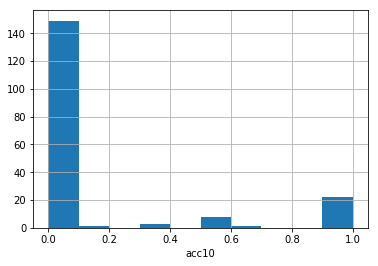

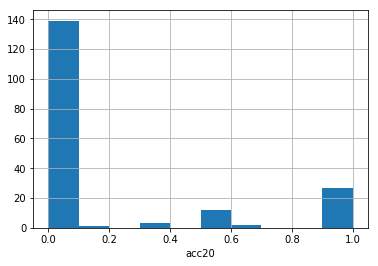

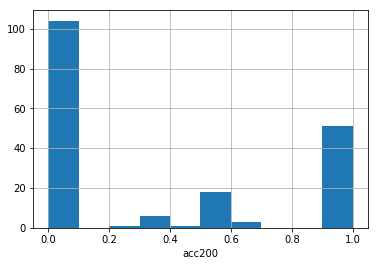

In [71]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [72]:
k = '59a7bc6a782b1b893a56a87e'
print(k)
preds[k]

59a7bc6a782b1b893a56a87e


['5984cf94b6b11336826384f7',
 '5984d255b6b113502e638505',
 '5984dd40b6b11333bc6384f9',
 '5984d809b6b11308f96384f7',
 '5984d808b6b11308f36384f2',
 '5984d809b6b11308f96384f6',
 '5984ba57b6b1134c4463851c',
 '5984d4fbb6b1136a5363850d',
 '5984d0c0b6b113406f638501',
 '5984cb09b6b1130b8e638508',
 '5984bdd5b6b1137588638508',
 '5984c712b6b113633963850b',
 '5984d808b6b11308f36384f5',
 '5984cd24b6b1132019638521',
 '5984c4ddb6b11349ac638508',
 '5984df2cb6b1133e9263851f',
 '5984d80cb6b11308fc63850c',
 '5984baaab6b1134e9f63854b',
 '5984befab6b11303e4638520',
 '5984d248b6b1134f2263852c',
 '5984bdfbb6b11376f2638504',
 '5984d714b6b1137f35638521',
 '5984d25db6b113504a63851c',
 '5984d25ab6b113503c638518',
 '5984d425b6b11363a363851e',
 '5984defbb6b1133d3963852c',
 '5984bd53b6b11370ca63851f',
 '5984cad9b6b11309676384f1',
 '5984bff7b6b1130db163853a',
 '5984be6db6b1137db763850a',
 '5984bbb0b6b1135c366384fe',
 '5984d233b6b1134e44638510',
 '5984c17cb6b1132203638526',
 '5984c3e2b6b113412d6384ff',
 '5984ce68b6b1

In [73]:
predict([k], lim=10**9)[k].index('5984ccc4b6b1131d6a63850e')

354

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808